# Analysis of the ultrabroad source in field aa

The coordinates are roughly (ironically) 17:45:57.7530532310 -28:57:10.7694483833 ICRS.

## Detections

There are three confident (SNR > 10) lines detected (see [Fit lines](#Fit_lines)).

These are CS 2-1, SO 3(2)-2(1), SO 2(2)-1(1), and SO2 2(2,0)-3(1,3), in rough order of brightness (SO 32 may be brighter than CS 2-1).

No other lines are detected, and the H-bearing species appear to have restrictive upper limits (see [Overplot](# Overplot all the lines (to show nondetections)).

The pair of SO lines gives a temperature of roughly 15K.

The SO lines are optically thin, but at $\tau\sim0.1-0.2$, so it is not likely that the filling factor is small.  That puts the gas size at the source size, which is roughly 1".  The beam size is 1.5", but the source may be slightly resolved, giving a deconvolved size ~0.8".


In [1]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 14

In [2]:
from spectral_cube import SpectralCube
from astropy import units as u, constants
from astropy.coordinates import SkyCoord
import pyspeckit
import glob
import radio_beam

g++ -std=c++11   -Ofast -fopenmp -DNDEBUG -DHAVE_INLINE -MMD -MP -fPIC   -c -o pwind_geom.o pwind_geom.cpp


In file included from pwind_geom.cpp:2:
pwind_util.H:9:10: fatal error: gsl/gsl_sf_erf.h: No such file or directory
    9 | #include <gsl/gsl_sf_erf.h>
      |          ^~~~~~~~~~~~~~~~~~
compilation terminated.
make: *** [<builtin>: pwind_geom.o] Error 1


In [3]:
from astropy import stats

In [4]:
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
import numpy as np
from astropy.table import Table

In [5]:
import latex_info

In [6]:
path = '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/'

In [7]:
cd $path

/orange/adamginsburg/ACES/rawdata/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working


In [8]:
ls -d *image

uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw25.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw27.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw29.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw31.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw33.cube.I.iter1.reclean.image@
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw35.cube.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw25.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw27.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw29.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw31.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw33.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw35.mfs.I.iter1.image/


In [9]:
coord = SkyCoord("17:45:57.7530532310 -28:57:10.7694483833", unit=(u.h, u.deg), frame='icrs')
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [10]:
import regions

In [11]:
region = regions.RectangleSkyRegion(center=coord, width=15*u.arcsec, height=15*u.arcsec)
cutregion = regions.CircleSkyRegion(center=coord, radius=15*u.arcsec) # circumscribe the above region so we can match RA/Dec to Galactic

In [12]:
bigregion = regions.RectangleSkyRegion(center=coord, width=35*u.arcsec, height=35*u.arcsec)
bigcircregion = regions.CircleSkyRegion(center=coord, radius=35*u.arcsec)

In [13]:
biggerregion = regions.RectangleSkyRegion(center=coord, width=65*u.arcsec, height=65*u.arcsec)

In [14]:
# measure the surrounding ISM in an annulus
annulus = regions.CircleAnnulusSkyRegion(center=coord, inner_radius=3*u.arcsec, outer_radius=6*u.arcsec)

In [15]:
circle = regions.CircleSkyRegion(center=coord, radius=3*u.arcsec)

In [16]:
imgs = sorted(glob.glob("*.cube.*.image"))

In [17]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubes = [SpectralCube.read(fn) for fn in imgs]

In [18]:
scubes = [cube.subcube_from_regions([region]) for cube in cubes]

In [19]:
pxcrd = [cube.wcs.celestial.world_to_pixel(coord) for cube in cubes]
spectra = [cube[:, int(y), int(x)].to(u.K) for cube, (x,y) in zip(cubes, pxcrd)]

In [20]:
pspectra = pyspeckit.Spectra([pyspeckit.Spectrum.from_hdu(sp.hdu) for sp in spectra])

INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]


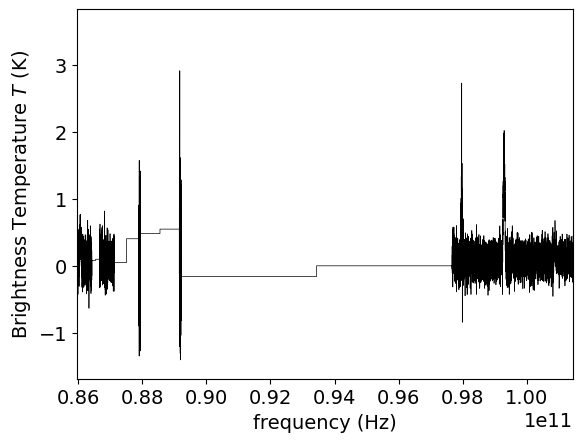

In [21]:
pspectra.plotter()

# Fit lines

In [22]:
from astroquery.splatalogue import Splatalogue
from astroquery.splatalogue.utils import minimize_table

In [23]:
#Splatalogue.query_lines(97.98095 * (1-30/3e5) *u.GHz, 97.98095 * (1+30/3e5)*u.GHz, energy_max=100, energy_type='eu_k')

In [24]:
nurest_so32 = 99.29987e9*u.Hz	
nurest_34so32 = 97.715317e9*u.Hz
nurest_so21 = 86.09395e9*u.Hz
nurest_cs21 = 97.98095e9*u.Hz
nurest_so45 = 100.02956e9*u.Hz
nurest_h13cop = 86.7543*u.GHz
nurest_c34s21 = 96.412951*u.GHz

### Table

In [25]:
measurement_table = []

### spw33 

In [26]:
# rough Jy to Kelvin estimate to change my guesses, that were in Jy, to K
JtoK = cubes[0].beam.jtok(cubes[0].spectral_axis).mean().value
JtoK

54.2808632681691

In [27]:
b3beam = cubes[0].beam
b3beam

Beam: BMAJ=1.9257872153987963 arcsec BMIN=1.5734451566902963 arcsec BPA=-71.8496817278145 deg

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.916434 +/-       0.0275603 
Param #1       SHIFT0 =  9.79603e+10 +/-          668082 
Param #2       WIDTH0 =  1.92385e+07 +/-          668082   Range:   [0,inf)
Param #3   AMPLITUDE1 =      1.71866 +/-       0.0253826 
Param #4       SHIFT1 =  9.92861e+10 +/-          386802 
Param #5       WIDTH1 =  2.26814e+07 +/-          386802   Range:   [0,inf) 
 Velocity width sigma(CS) = 58.87640757884788 km / s  FWHM(CS) =  138.35955781029253 km / s  VLSR(CS) =  63.288838560016764 km / s  SNR :  33.251929764963656 
 Velocity width sigma(SO) = 68.48604440209336 km / s  FWHM(SO) =  160.94220434491936 km / s  VLSR(SO) =  41.47102942141959 km / s  SNR :  67.71010763385557


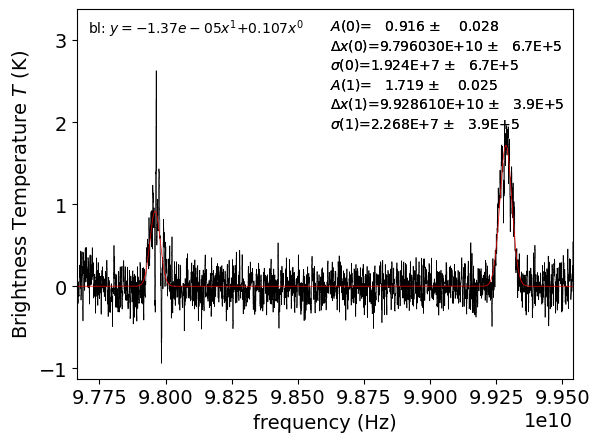

In [28]:
spw33 = pspectra[-2]
spw33.plotter()
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
spw33.baseline(excludefit=True)
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
#measurement_table.append(['CS 2-1', 97.98095e9] + list(zip(spw33.specfit.parinfo.values[:3], spw33.specfit.parinfo.errors[:3])))
#measurement_table.append(['SO 3(2)-2(1)', 99.2998e9] + list(zip(spw33.specfit.parinfo.values[3:6], spw33.specfit.parinfo.errors[3:6])))
                         
print(spw33.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spw33.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE0'].value / spw33.specfit.parinfo['AMPLITUDE0'].error,
      "\n Velocity width sigma(SO) =",
      spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spw33.specfit.parinfo['SHIFT1'].value - 99.2998e9) / 99.29987e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE1'].value / spw33.specfit.parinfo['AMPLITUDE1'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =        1.032 +/-       0.0439775   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79656e+10 +/-     1.00287e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.28333e+07 +/-          923831   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.32644 +/-        0.105463   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          224555   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.52236e+06 +/-          245671   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.36715 +/-        0.154886   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79598e+10 +/-          144960   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =  1.13271e+06 +/-          152075   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.56388 +/-        0.197749   Ra

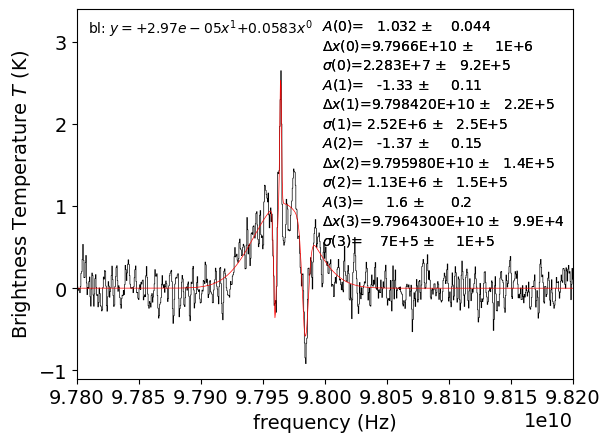

In [29]:
spw33 = pspectra[-2]
spcs = spw33.copy()
spcs.plotter(xmin=97.8e9, xmax=98.2e9)
spcs.specfit(guesses=[1, 97.98e9, 97.8e9/3000])
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[1, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.984e9, 1e6, # absorption feature
                      -0.5, 97.9594e9, 1e6, # absorption feature
                      0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))

print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spcs.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error,)

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =      1.86881 +/-       0.0305313   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.92858e+10 +/-          366324   Range:[9.91e+10,9.95e+10]
Param #2       WIDTH0 =  2.20066e+07 +/-          351100   Range: [0,4e+07]
Param #3   AMPLITUDE1 =    -0.664981 +/-        0.112909   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.93026e+10 +/-          208213   Range:[9.91e+10,9.95e+10]
Param #5       WIDTH1 =   1.0742e+06 +/-          215545   Range: [0,4e+07]
Param #6   AMPLITUDE2 =    -0.765812 +/-       0.0844522   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.92779e+10 +/-          247478   Range:[9.91e+10,9.95e+10]
Param #8       WIDTH2 =  1.99882e+06 +/-          267481   Range: [0,4e+07] 
 Velocity width sigma(SO) = 66.4487460235625 km / s  FWHM(SO

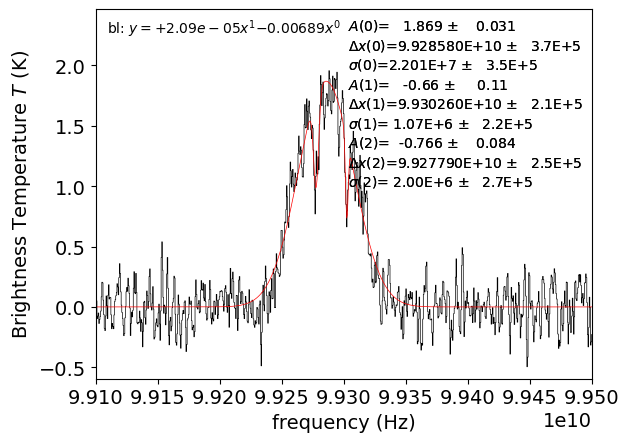

In [30]:
#SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=99.1e9, xmax=99.5e9)
spso.specfit(guesses=[1, 99.299e9, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_so32.to(u.Hz).value, 1e7, 
                      -0.5, 99.302e9, 1e6, # absorption feature
                      -0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (99.1e9, 99.5e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['SO 3-2', nurest_so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - 99.299095e9) / 99.299095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

In [31]:
nurest_34so32

<Quantity 9.7715317e+10 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.216353 +/-       0.0239146   Range:[0,2.71404]
Param #1       SHIFT0 =  9.77039e+10 +/-     2.60308e+06   Range:[9.71e+10,9.7775e+10]
Param #2       WIDTH0 =  2.03257e+07 +/-     2.72229e+06   Range: [0,4e+07] 
 Velocity width sigma(34SO) = 62.36702922223699 km / s  FWHM(SO) =  146.5625186722569 km / s  VLSR(SO) =  34.90459519481612 km / s  SNR :  9.046864654153985


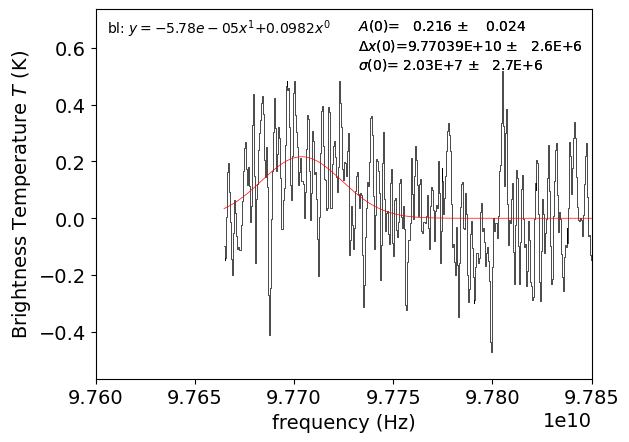

In [32]:
#34SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=97.6e9, xmax=97.85e9)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 1e7, 
                      #-0.5, 99.302e9, 1e6, # absorption feature
                      #-0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(0, 0.05*JtoK), (97.1e9, 97.775e9), (0, 4e7),
                     ],
              limited=[(True, True)]*3)
measurement_table.append(['34SO 3-2', nurest_34so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(34SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

### spw25

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.382843 +/-       0.0261676 
Param #1       SHIFT0 =  8.60829e+10 +/-     1.53617e+06 
Param #2       WIDTH0 =  1.94643e+07 +/-     1.53617e+06   Range:   [0,inf) 
 Velocity width sigma(SO21) = 67.78625351080638 km / s  FWHM(SO) =  159.29769575039498 km / s  VLSR(SO2(2)-1(1)):  38.46949335809995 km / s  SNR :  14.630446729382609


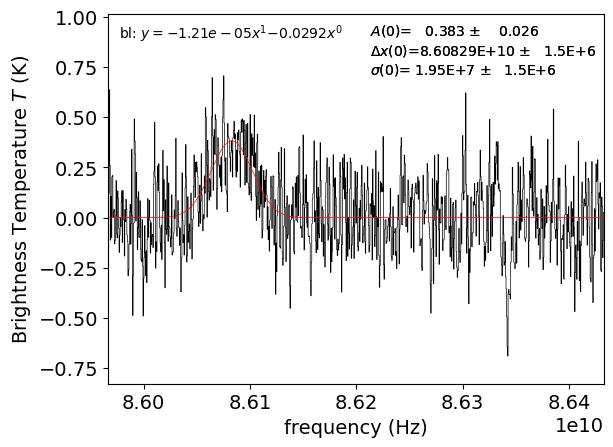

In [33]:
spw25 = pspectra[0]
spw25.data -= np.median(spw25.data) # contsub
spw25.plotter()
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
spw25.baseline(excludefit=True)
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw25.specfit.parinfo.values[:3], spw25.specfit.parinfo.errors[:3])))
print(spw25.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO21) =",
      spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2(2)-1(1)): ",
      -(spw25.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw25.specfit.parinfo['AMPLITUDE0'].value / spw25.specfit.parinfo['AMPLITUDE0'].error
     )

### spw 27 (no detections)

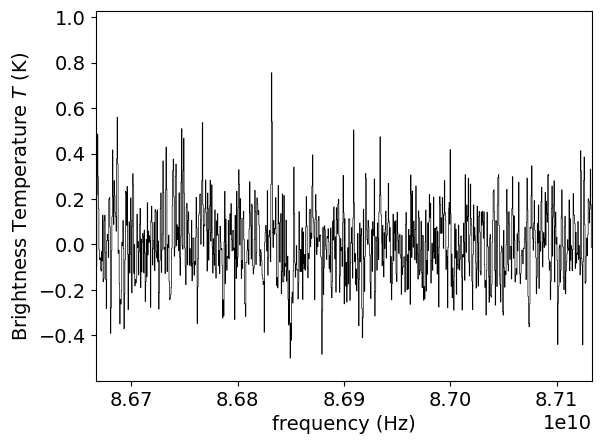

In [34]:
spw27 = pspectra[1]
spw27.data -= np.median(spw27.data) # contsub
spw27.plotter()
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#spw27.baseline(excludefit=True)
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw27.specfit.parinfo.values[:3], spw27.specfit.parinfo.errors[:3])))
#print(spw27.specfit.fitter.parinfo,
#      "\n Velocity width sigma(SO21) =",
#      spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " FWHM(SO) = ",
#      2.35*spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " VLSR(SO2(2)-1(1)): ",
#      -(spw27.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
#      " SNR : ", spw27.specfit.parinfo['AMPLITUDE0'].value / spw27.specfit.parinfo['AMPLITUDE0'].error
#     )

### spw 35

In [35]:
nurest_so45

<Quantity 1.0002956e+11 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.171514 +/-       0.0286755   Range:[0.05,2.71404]
Param #1       SHIFT0 =  1.00875e+11 +/-     4.79635e+06   Range:[1.008e+11,1.009e+11]
Param #2       WIDTH0 =  2.48427e+07 +/-     4.79635e+06   Range:[1.5e+07,4e+07]
Param #3   AMPLITUDE1 =    0.0583502 +/-       0.0301321   Range:[0.05,2.71404]
Param #4       SHIFT1 =  1.00017e+11 +/-     1.09545e+07   Range:[9.99962e+10,1.00063e+11]
Param #5       WIDTH1 =      1.5e+07 +/-               0   Range:[1.5e+07,4e+07] 
 Velocity width sigma(SO2 220) = 73.8305414850214 km / s  FWHM(SO2) =  173.50177248980032 km / s  VLSR(SO2):  9.873140723249119 km / s  SNR :  5.981206517501485


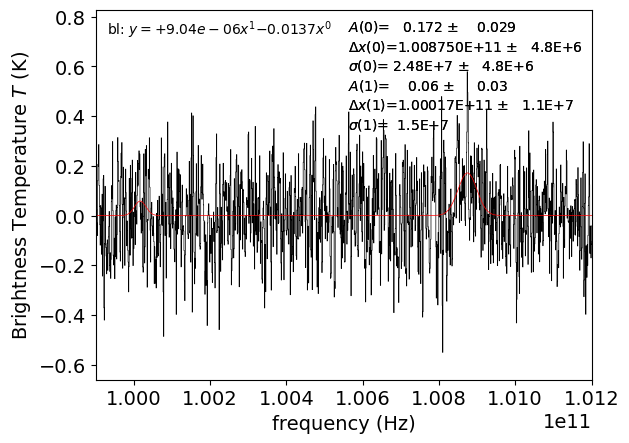

In [36]:
# Not a good fit

spw35 = pspectra[-1].copy()
spw35.data -= np.median(spw35.data) # contsub
spw35.plotter(xmin=99.9e9, xmax=101.2e9)
#spw35.plotter(xmin=100.55e9, xmax=101.2e9)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 1e7, 0.2, nurest_so45.to(u.Hz).value, 1e7],
              limits=[(0, 0.05*JtoK), (100.8e9, 100.9e9), (0, 4e7),
                      (0, 0.05*JtoK), (99.99e9, 100.2e9), (0, 4e7),
                     ], limited=[(True, True)]*6)
spw35.baseline(excludefit=True)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 2e7, 0.2, nurest_so45.to(u.Hz).value, 2e7],
              limits=[(0.05, 0.05*JtoK), (100.8e9, 100.9e9), (1.5e7, 4e7),
                      (0.05, 0.05*JtoK), (nurest_so45.value*(1-100/3e5), nurest_so45.value*(1+100/3e5)), (1.5e7, 4e7),
                     ], limited=[(True, True)]*6)
measurement_table.append(['SO2 2(2,0)-3(1,3)', 100.878105e9] + list(zip(spw35.specfit.parinfo.values[:3], spw35.specfit.parinfo.errors[:3])))
print(spw35.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO2 220) =",
      spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO2) = ",
      2.35*spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2): ",
      -(spw35.specfit.parinfo['SHIFT0'].value - 100.878105e9) / 100.878105e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw35.specfit.parinfo['AMPLITUDE0'].value / spw35.specfit.parinfo['AMPLITUDE0'].error
     )
#spw35.specfit.parinfo

## Tsuboi C34S

In [37]:
fns_2012 = [fn for fn in sorted(glob.glob("/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/*.image.pbcor.fits"))
            if 'cont' not in fn]
scubes2012 = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_2012 ]
fns_2012

['/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw0_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw1_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw2_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw3_cube.image.pbcor.fits']

In [38]:
c34scube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_c34s21 and scube.spectral_axis.max() > nurest_c34s21][0]
c34scube_2012

VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3712  type_s: FREQ      unit_s: Hz     range: 96180400540.670 Hz:97086349711.145 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.138535 +/-       0.0213704   Range:[0,2.71404]
Param #1       SHIFT0 =  9.63966e+10 +/-     3.40094e+06   Range:[9.62e+10,9.7e+10]
Param #2       WIDTH0 =  1.90922e+07 +/-     3.40094e+06   Range: [0,4e+07] 
 Velocity width sigma(C34S) = 59.37652055823241 km / s  FWHM(C34S) =  139.53482331184617 km / s  VLSR(C34s):  50.77006796531648 km / s  SNR :  6.4825676517965825


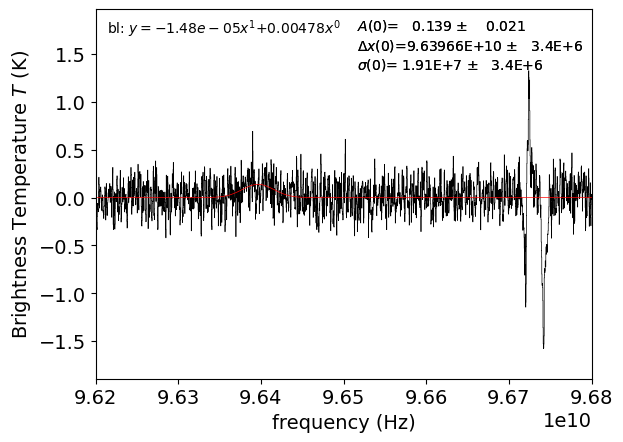

In [39]:
cube = c34scube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spc34s = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

nurest_c34s21 = 96.412951*u.GHz

spc34s.data -= np.median(spc34s.data) # contsub
spc34s.plotter(xmin=96.2e9, xmax=96.8e9)
#spc34s.plotter(xmin=100.55e9, xmax=101.2e9)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spc34s.baseline(excludefit=True)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['C34S 2-1', nurest_c34s21.to(u.Hz).value] + list(zip(spc34s.specfit.parinfo.values[:3], spc34s.specfit.parinfo.errors[:3])))
print(spc34s.specfit.fitter.parinfo,
      "\n Velocity width sigma(C34S) =",
      spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(C34S) = ",
      2.35*spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(C34s): ",
      -(spc34s.specfit.parinfo['SHIFT0'].value - nurest_c34s21.to(u.Hz).value) / nurest_c34s21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spc34s.specfit.parinfo['AMPLITUDE0'].value / spc34s.specfit.parinfo['AMPLITUDE0'].error
     )

## Tsuboi CS

In [40]:
cscube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_cs21 and scube.spectral_axis.max() > nurest_cs21][0]
cscube_2012

VaryingResolutionSpectralCube with shape=(3840, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 97512362524.760 Hz:98449559739.802 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.538484 +/-       0.0274834   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79676e+10 +/-     1.14218e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.20131e+07 +/-     1.06991e+06   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.10444 +/-       0.0718508   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          152122   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.07609e+06 +/-          163847   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.17159 +/-        0.105372   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79604e+10 +/-          116987   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =       961798 +/-          123409   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.41337 +/-        0.101357   Ra

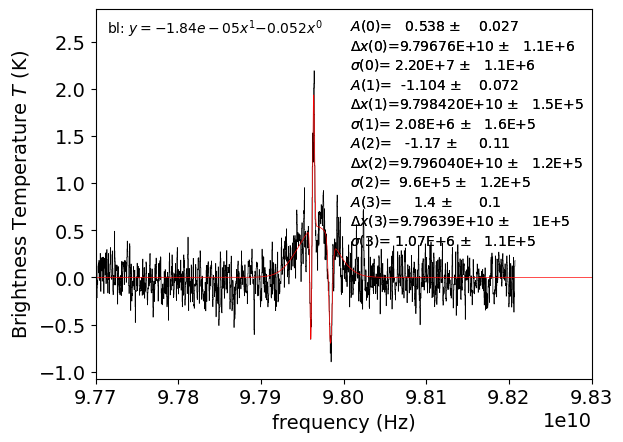

In [41]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spcs = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

spcs.data -= np.median(spcs.data) # contsub
spcs.plotter(xmin=97.7e9, xmax=98.3e9)
#spcs.plotter(xmin=100.55e9, xmax=101.2e9)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.985e9, 1e6, # absorption feature
                      -0.5, 97.96e9, 1e6, # absorption feature
                      0.5, 97.965e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1 (2012)', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))
print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS): ",
      -(spcs.specfit.parinfo['SHIFT0'].value - nurest_cs21.to(u.Hz).value) / nurest_cs21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.129268 +/-       0.0146529   Range:[0,2.71404]
Param #1       SHIFT0 =  9.76974e+10 +/-     3.05841e+06   Range:[9.75e+10,9.81e+10]
Param #2       WIDTH0 =  2.33691e+07 +/-     3.05841e+06   Range: [0,4e+07] 
 Velocity width sigma(34so) = 71.70993531201097 km / s  FWHM(34so) =  168.51834798322577 km / s  VLSR(34so):  54.819979936973525 km / s  SNR :  8.8220133544466


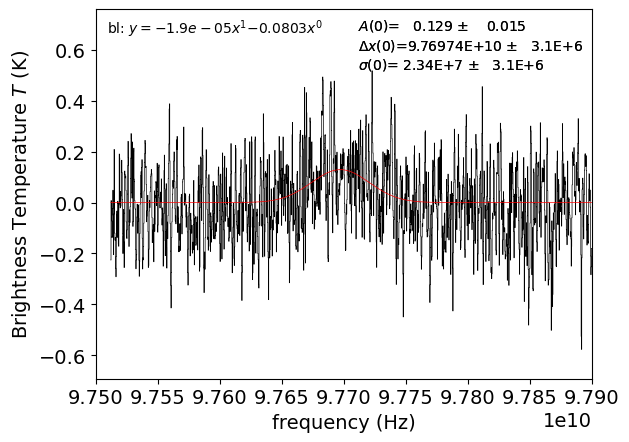

In [42]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
sp34so = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

sp34so.data -= np.median(sp34so.data) # contsub
sp34so.plotter(xmin=97.5e9, xmax=97.9e9)
#sp34so.plotter(xmin=100.55e9, xmax=101.2e9)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
sp34so.baseline(excludefit=True)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['34SO 3-2 (2012)', nurest_34so32.to(u.Hz).value] + list(zip(sp34so.specfit.parinfo.values[:3], sp34so.specfit.parinfo.errors[:3])))
print(sp34so.specfit.fitter.parinfo,
      "\n Velocity width sigma(34so) =",
      sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(34so) = ",
      2.35*sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(34so): ",
      -(sp34so.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", sp34so.specfit.parinfo['AMPLITUDE0'].value / sp34so.specfit.parinfo['AMPLITUDE0'].error
     )

## Spectral Measurement Table

In [43]:
latexdict = latex_info.latexdict.copy()
latexdict['header_start'] = r'\label{tab:spectral_measurements}'
latexdict['caption'] = 'Spectral Line Measurements'
latexdict['preamble'] = r'\centering'
latexdict['tablefoot'] = '''\par\nThe columns with $\sigma$ values give the uncertainty on their neighbors (e.g., $\sigma_A$ is the uncertainty on the amplitude).
All values are from Gaussian fits to the line profile, so the widths are the Gaussian width parameter, not the FWHM.
'''
formats = {'Amplitude': lambda x: "{0:0.3f}".format(x),
           'Amp': lambda x: "{0:0.3f}".format(x),
           'Center': lambda x: "{0:0.3f}".format(x),
           'Velocity Center': lambda x: "{0:0.3f}".format(x),
           '$v_{cen}$': lambda x: "{0:0.3f}".format(x),
           'Width [freq]': lambda x: "{0:0.3f}".format(x),
           'Width [vel]': lambda x: "{0:0.3f}".format(x),
           'Rest Frequency': lambda x: "{0:0.6f}".format(x),
           'Rest Freq': lambda x: "{0:0.6f}".format(x),
           '$\sigma_{A}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{\nu,cen}$': lambda x: "{0:0.4f}".format(x),
           r'$\sigma_{\sigma_\nu}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{v,cen}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{\sigma_v}$': lambda x: "{0:0.3f}".format(x),
          }

In [44]:
meastable = Table(list(zip(*measurement_table)),
      names=('Line', 'Rest Frequency', 'Amplitude / Error', 'Center / Error', 'Width / Error')
     )
vcen = (meastable['Rest Frequency'] - meastable['Center / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
evcen = (meastable['Center / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
width = (meastable['Width / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
ewidth = (meastable['Width / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
meastable.add_column(vcen, name="Velocity Center")
meastable.add_column(vcen, name="$v_{cen}$")
meastable.add_column(evcen, name="e_vcen")
meastable.add_column(width, name="Width (sigma)")
meastable.add_column(ewidth, name="e_width")

meastable['Rest Frequency'].unit = u.Hz
meastable['Rest Freq'] = meastable['Rest Frequency'].to(u.GHz)
meastable['Amplitude / Error'].unit = u.K
meastable['Center / Error'].unit = u.Hz
meastable['Width / Error'].unit = u.Hz

meastable['Amp'] = meastable['Amplitude / Error'][:,0]
meastable[r'$\sigma_{A}$'] = meastable['Amplitude / Error'][:,1]
meastable['Width [freq]'] = meastable['Width / Error'][:,0].to(u.MHz)
meastable[r'$\sigma_{\sigma_\nu}$'] = meastable['Width / Error'][:,1].to(u.MHz)
meastable['Center'] = meastable['Center / Error'][:,0].to(u.GHz)
meastable[r'$\sigma_{\nu,cen}$'] = meastable['Center / Error'][:,1].to(u.GHz)

meastable[r'$\sigma_{v,cen}$'] = meastable['e_vcen']
meastable[r'Width [vel]'] = meastable['Width (sigma)']
meastable[r'$\sigma_{\sigma_v}$'] = meastable['e_width']

meastable['Species'] = [x.replace("34", "$^{34}$").replace("SO2", "SO$_2$") for x in meastable['Line']]

selcols = ['Species', 'Rest Freq', 'Amp', '$\sigma_{A}$', 'Center', r'$\sigma_{\nu,cen}$', 'Width [freq]', r'$\sigma_{\sigma_\nu}$', '$v_{cen}$', r'$\sigma_{v,cen}$', 'Width [vel]', r'$\sigma_{\sigma_v}$']

meastable.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.ecsv', overwrite=True)
meastable[selcols].write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex', latexdict=latexdict, formats=formats, overwrite=True)
meastable.add_index('Line')
meastable

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConsta

<Table length=8>
       Line       Rest Frequency              Amplitude / Error                           Center / Error             ...  $\sigma_{v,cen}$     Width [vel]     $\sigma_{\sigma_v}$       Species       
                        Hz                            K                                         Hz                   ...       km / s             km / s              km / s                           
      str17          float64                      float64[2]                                float64[2]               ...      float64            float64             float64              str20        
----------------- -------------- ------------------------------------------- --------------------------------------- ... ------------------ ------------------ ------------------- --------------------
           CS 2-1  97980950000.0   1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 ...   3.06848704281292  69.86299227186738  2.8266483217816205               CS 2-1
           SO 3-2  99299870000.0   1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 ... 1.1059557738274437  66.43934639033277  1.0599924162957055               SO 3-2
         34SO 3-2  97715317000.0 0.21635256073961096 .. 0.023914645461206262    97703940084.093 .. 2603077.087169318 ...  7.986290197738089 62.359767879096374   8.352039733312695        $^{34}$SO 3-2
     SO 2(2)-1(1)  86093950000.0  0.3828433596099744 .. 0.026167578249070324  86082902388.39632 .. 1536167.511113989 ...  5.349173014556831  67.77755515045868   5.349172981667376         SO 2(2)-1(1)
SO2 2(2,0)-3(1,3) 100878105000.0 0.17151400547254475 .. 0.028675486287036096 100874782755.89418 .. 4796354.816369068 ... 14.253945391216671  73.82811000515491  14.253945285804658 SO$_2$ 2(2,0)-3(1,3)
         C34S 2-1  96412951000.0  0.13853527520451572 .. 0.02137043261956888  96396623397.53908 .. 3400937.958181477 ... 10.575089128728424  59.36646510185304  10.575089134905047        C$^{34}$S 2-1
    CS 2-1 (2012)  97980950000.0    0.538483824315997 .. 0.02748337250869406  97967649265.22664 .. 1142176.976084657 ...  3.494720587332808  67.35358672034356   3.273608958511121        CS 2-1 (2012)
  34SO 3-2 (2012)  97715317000.0 0.12926819946106832 .. 0.014652913600035832   97697448799.6016 .. 3058414.059952523 ...  9.383272722892832  71.69682244972846   9.383272700324666 $^{34}$SO 3-2 (2012)

In [45]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex

\begin{table*}[htp]
\centering
\caption{Spectral Line Measurements}
\begin{tabular}{cccccccccccc}
\label{tab:spectral_measurements}
Species & Rest Freq & Amp & $\sigma_{A}$ & Center & $\sigma_{\nu,cen}$ & Width [freq] & $\sigma_{\sigma_\nu}$ & $v_{cen}$ & $\sigma_{v,cen}$ & Width [vel] & $\sigma_{\sigma_v}$ \\
 & $\mathrm{GHz}$ & $\mathrm{K}$ & $\mathrm{K}$ & $\mathrm{GHz}$ & $\mathrm{GHz}$ & $\mathrm{MHz}$ & $\mathrm{MHz}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ \\
\hline
CS 2-1 & 97.980950 & 1.032 & 0.044 & 97.966 & 0.0010 & 22.833 & 0.924 & 47.082 & 3.068 & 69.863 & 2.827 \\
SO 3-2 & 99.299870 & 1.869 & 0.031 & 99.286 & 0.0004 & 22.007 & 0.351 & 42.408 & 1.106 & 66.439 & 1.060 \\
$^{34}$SO 3-2 & 97.715317 & 0.216 & 0.024 & 97.704 & 0.0026 & 20.326 & 2.722 & 34.905 & 7.986 & 62.360 & 8.352 \\
SO 2(2)-1(1) & 86.093950 & 0.383 & 0.026 & 86.083 & 0.0015 & 19.464 & 1.536 & 38.469 & 5.349 & 67.778 & 5.349 \\
SO$_2$ 2(2,0)-3(1,3) & 10

In [46]:
cstoc34s = meastable.loc['CS 2-1']['Amplitude / Error'][0] / meastable.loc['C34S 2-1']['Amplitude / Error'][0]
soto34so = meastable.loc['SO 3-2']['Amplitude / Error'][0] / meastable.loc['34SO 3-2']['Amplitude / Error'][0]
cstoc34s, soto34so

(7.449348068610154, 8.637782497523377)

In [47]:
# from wikipedia, ratio of 32S/34S
94.93/4.29

22.12820512820513

# Search for spatial gradients

## Separate background

In [48]:
background_stddevs = [cube.subcube_from_regions([annulus]).std(axis=(1,2)) for cube in cubes]
background_means = [cube.subcube_from_regions([annulus]).mean(axis=(1,2)) for cube in cubes]

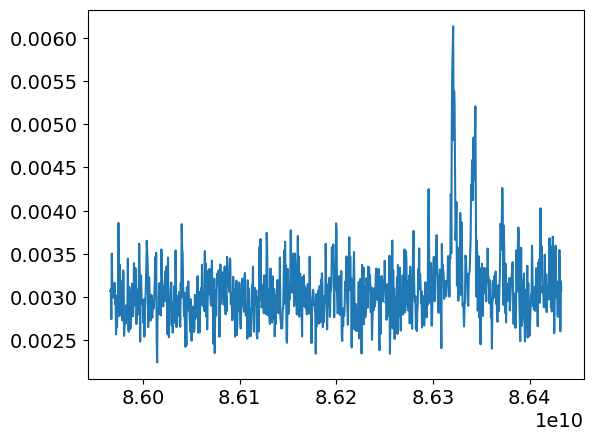

In [49]:
pl.plot(background_stddevs[0].spectral_axis, background_stddevs[0].value)

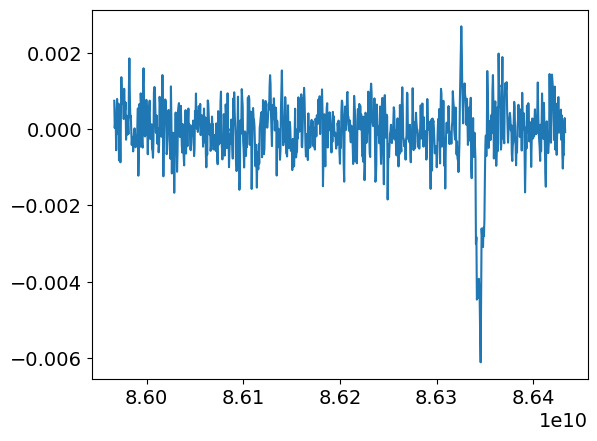

In [50]:
pl.plot(background_means[0].spectral_axis, background_means[0].value)

## Fitting channel-by-channel

In [51]:
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [52]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

In [53]:
rows = []
for chan in range(so_scube.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value, weights=1/stats.mad_std(so_scube[chan, :, :]))
    rows.append(list(g.parameters) +
                (list(fit_g.fit_info['param_cov'].diagonal()**0.5) if fit_g.fit_info['param_cov'] is not None else [np.nan]*len(g.parameters)) )
    #print(chan, g.parameters)
tb = Table(np.array(rows), names=list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

invalid value encountered in sqrt
invalid value encountered in sqrt


In [54]:
tb = Table(np.array(rows), names=list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

In [55]:
# empirical: 15-sigma needed to be reliable
(tb['amplitude']/tb['e_amplitude'] > 15).sum()

132

In [56]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
# I swear something is wrong with this math.  The area of a Gaussian is 2 pi sigma_a sigma_b, so the error should be 2 pi (sigma_a^2 * b^2 + sigma_b^2 * a^2)**0.5, but empirically the S/N is wrong if the 2 is on the outside...
fitarea = 2*np.pi*tb['x_stddev']*tb['y_stddev']*pixarea_soscube
e_fitarea = np.pi*(2*((tb['e_x_stddev']*tb['y_stddev'])**2 + (tb['e_y_stddev']*tb['x_stddev'])**2))**0.5 * pixarea_soscube
((np.abs(fitarea - so_scube.beam.sr) / e_fitarea > 2) & (tb['amplitude'] / tb['e_amplitude'] > 15)).sum()

113

In [57]:
# signal-to-noise in fitted area
fitarea/e_fitarea

<Quantity [9.55997941e+00, 8.77508166e+00,            nan,            nan,
           2.79998101e-38, 1.06012268e-38, 5.82422605e+00, 3.34607088e+00,
                      nan,            nan, 6.21770993e+00, 8.64904962e+00,
                      nan, 3.12067789e-38, 5.45679492e-39, 1.36100290e-38,
           6.42501216e+00, 1.13519926e+01, 6.80901691e+00, 6.59134382e+00,
           9.82395335e+00,            nan, 5.85002822e+00, 8.45765685e+00,
           1.29465783e-38, 2.41587265e-38, 1.24871123e-39, 2.07482139e-39,
                      nan,            nan, 7.35236380e+00, 6.86215348e+00,
           8.20395205e+00, 6.72625309e+00, 1.75126224e-38, 1.27095948e+01,
           7.67535087e+00, 7.49020545e+00, 6.15575091e+00, 4.48956019e+00,
           1.98021195e-37, 2.62943375e-38, 3.15717418e-38, 1.26147459e+01,
           8.31091384e+00, 1.17734314e-38, 2.09130786e-38, 1.33057394e+01,
           1.07272506e+01, 1.05554311e+01, 7.94660243e-42, 1.27738626e-38,
           6.78656351e+00

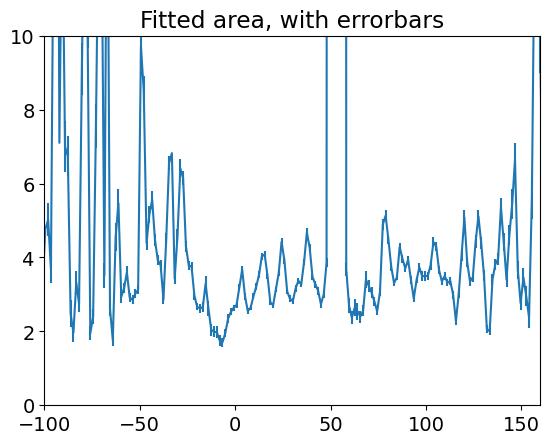

In [58]:
pl.title("Fitted area, with errorbars")
pl.errorbar(so_scube.spectral_axis.value, fitarea.to(u.arcsec**2), yerr=e_fitarea.to(u.arcsec**2))
pl.ylim(0, 10)
pl.xlim(-100, 160);

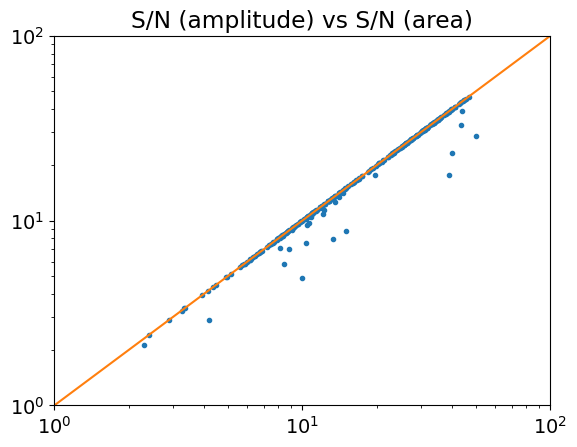

In [59]:
#DIAGNOSTIC
pl.title("S/N (amplitude) vs S/N (area)")
pl.loglog(tb['amplitude'] / tb['e_amplitude'], fitarea / e_fitarea , '.')
pl.plot([1,100], [1,100])
pl.ylim(1, 100);
pl.xlim(1, 100);

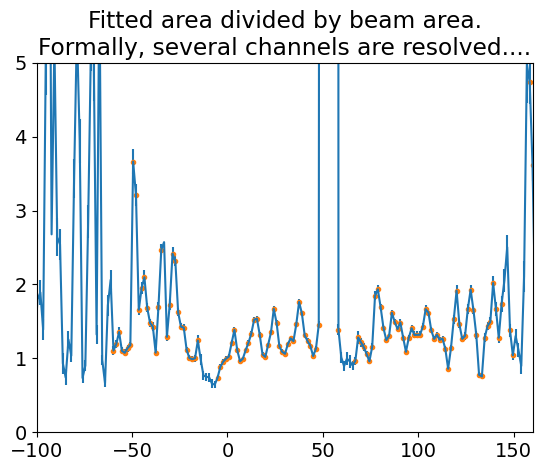

In [60]:
detected = (tb['amplitude']/tb['e_amplitude'] > 15)
# err = (sigma / fit) * (fit/reference) ; fit cancels out
pl.errorbar(so_scube.spectral_axis.value, fitarea.to(u.sr) / so_scube.beam.sr, yerr=(e_fitarea.to(u.sr) / so_scube.beam.sr))
pl.plot(so_scube.spectral_axis.value[detected], (fitarea.to(u.sr) / so_scube.beam.sr)[detected], marker='.', linestyle='none')
pl.xlim(-100, 160);
pl.ylim(0, 5);
pl.title("Fitted area divided by beam area.\nFormally, several channels are resolved....");

In [61]:
# try again averaging 10 channels
# I did this twice (oops): ### Try again downsampled (higher S/N)
rows = []
for chan in range(0, so_scube.shape[0], 10):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    data = so_scube[chan:chan+10, :, :].moment0(axis=0).value
    g = fit_g(g_init, x, y, z=data, weights=1/stats.mad_std(data))
    rows.append(np.array([so_scube.spectral_axis[chan:chan+10].mean().value] + list(g.parameters) + (list(fit_g.fit_info['param_cov'].diagonal()**0.5) if fit_g.fit_info['param_cov'] is not None else [np.nan]*len(g.parameters)) ))
    #print(chan, g.parameters)
tb_avg = Table(np.array(rows), names=['Velocity'] + list(g.param_names) + list(map(lambda x: f'e_{x}', g.param_names)))

In [62]:
(tb_avg['amplitude']/tb_avg['e_amplitude'] > 5).sum()

34

In [63]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_avg = 2*np.pi*tb_avg['x_stddev']*tb_avg['y_stddev']*pixarea_soscube
e_fitarea_avg = (2*np.pi*((tb_avg['e_x_stddev']*tb_avg['y_stddev'])**2 + (tb_avg['e_y_stddev']*tb_avg['x_stddev'])**2))**0.5 * pixarea_soscube
((np.abs(fitarea_avg - so_scube.beam.sr) / e_fitarea_avg > 2) & (tb_avg['amplitude'] / tb_avg['e_amplitude'] > 15)).sum()

16

In [64]:
%matplotlib inline
import pylab as pl

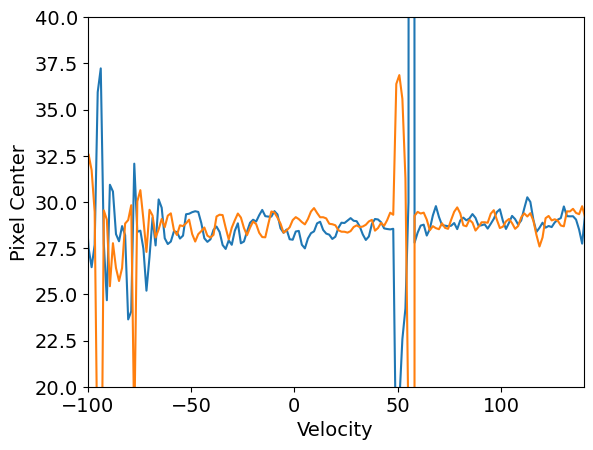

In [65]:
pl.plot(so_scube.spectral_axis.value, tb['x_mean'], label='X center (pixels)')
pl.plot(so_scube.spectral_axis.value, tb['y_mean'], label='Y center (pixels)')
pl.ylim(20, 40);
pl.xlim(-100, 140);
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

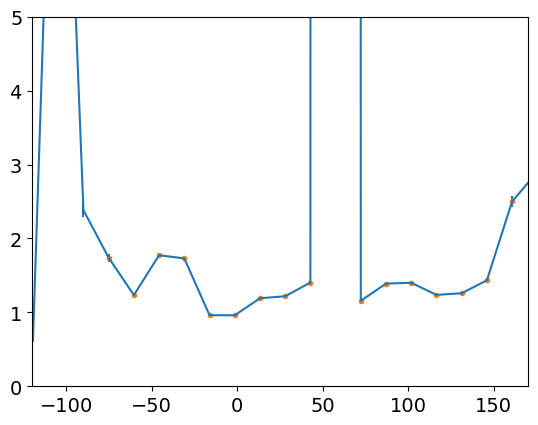

In [66]:
detected = (tb_avg['amplitude']/tb_avg['e_amplitude'] > 15)
# err = (sigma / fit) * (fit/reference) ; fit cancels out
pl.errorbar(tb_avg['Velocity'], fitarea_avg.to(u.sr) / so_scube.beam.sr, yerr=(e_fitarea_avg.to(u.sr) / so_scube.beam.sr))
pl.plot(tb_avg['Velocity'][detected], (fitarea_avg.to(u.sr) / so_scube.beam.sr)[detected], marker='.', linestyle='none')
pl.xlim(-120, 170);
pl.ylim(0, 5);

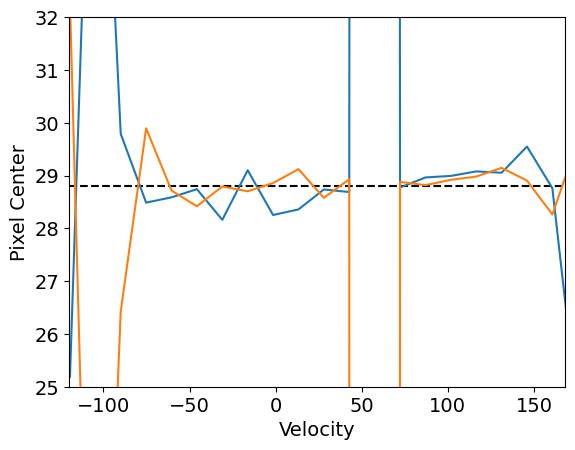

In [67]:
pl.plot(tb_avg['Velocity'], tb_avg['x_mean'], label='X center (pixels)')
pl.plot(tb_avg['Velocity'], tb_avg['y_mean'], label='Y center (pixels)')
pl.ylim(25, 32);
pl.xlim(-120, 168);
pl.axhline(28.8, linestyle='--', color='k', zorder=-10)
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

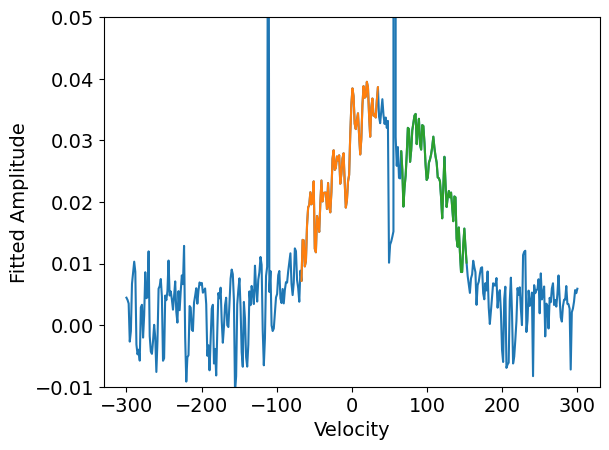

In [68]:
pl.plot(so_scube.spectral_axis.value, tb['amplitude'])
pl.plot(so_scube.spectral_axis.value[180:250], tb['amplitude'][180:250])
pl.plot(so_scube.spectral_axis.value[100:160], tb['amplitude'][100:160])
pl.ylim([-0.01, 0.05]);
pl.ylabel("Fitted Amplitude")
pl.xlabel("Velocity");

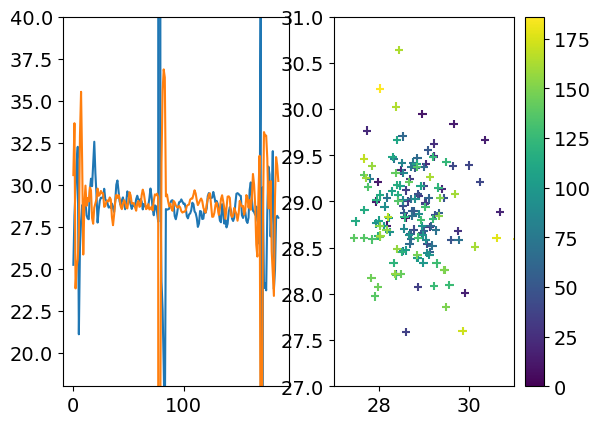

In [69]:
sel = tb['amplitude'] > 0.008
pl.subplot(1,2,1)
pl.plot(tb['x_mean'][sel])
pl.plot(tb['y_mean'][sel])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb['x_mean'][sel], tb['y_mean'][sel], c=np.arange(len(tb[sel])), marker='+')
pl.colorbar()
pl.axis([27,31,27,31]);

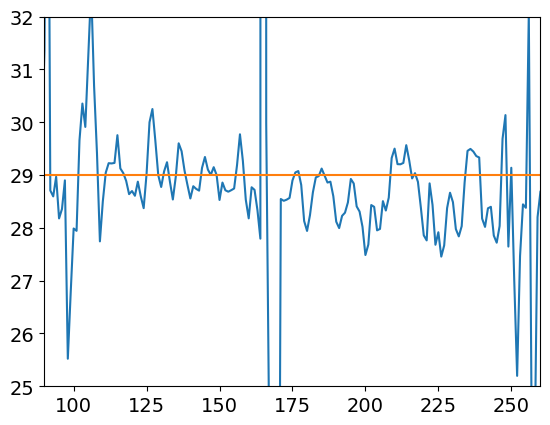

In [70]:
pl.plot(tb['x_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

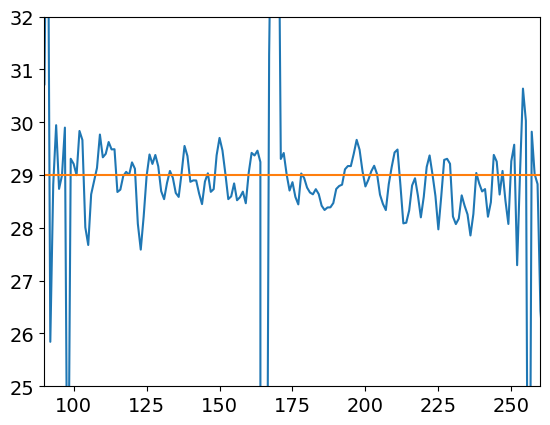

In [71]:
pl.plot(tb['y_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

In [72]:
pixscale = so_scube.wcs.celestial.proj_plane_pixel_scales()[0].to(u.arcsec)
pixscale

<Quantity 0.26 arcsec>

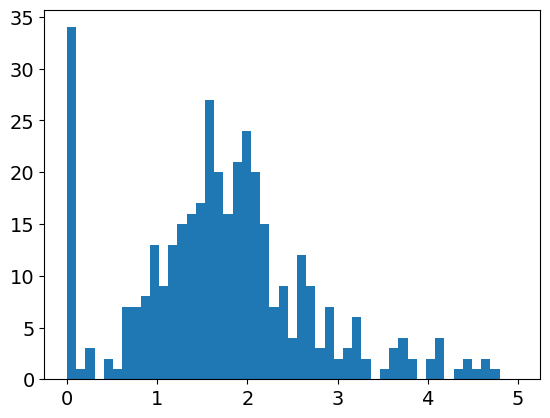

In [73]:
pl.hist(tb['x_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

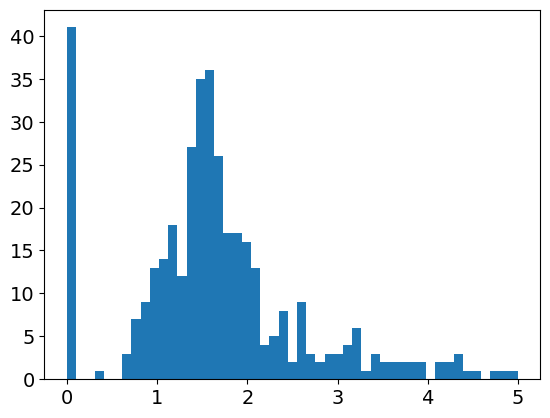

In [74]:
pl.hist(tb['y_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

### Fit red and blue sides

In [75]:
pixscale_so = so_scube.wcs.celestial.proj_plane_pixel_area()**0.5
sig2fwhm = np.sqrt(8*np.log(2))

(<Quantity 1.75846813 arcsec>,
 <Quantity 1.58360147 arcsec>,
 <Gaussian2D(amplitude=0.02563195, x_mean=28.54175745, y_mean=28.78748886, x_stddev=2.87801657, y_stddev=2.5918191, theta=0.17038562)>,
 <Quantity 34.59907725 km / s>,
 <Quantity -68.59815164 km / s>,
 <Quantity -7.67024943 km / s>)

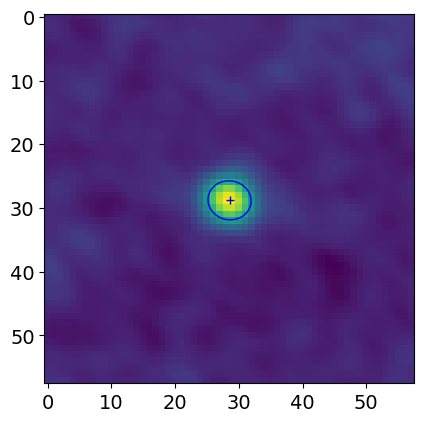

In [76]:
avgim_blue = so_scube[180:250].mean(axis=0)
avgim_blue.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
blue_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
blue_gfit = g = blue_fit_g(g_init, x, y, z=avgim_blue.value, weights=1/stats.mad_std(avgim_blue.value))
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')

src_blue = radio_beam.Beam(major=blue_gfit.x_stddev*pixscale_so*sig2fwhm,
                           minor=blue_gfit.y_stddev*pixscale_so*sig2fwhm,
                           pa=90*u.deg+blue_gfit.theta*u.rad)
ell = src_blue.ellipse_to_plot(blue_gfit.x_mean, blue_gfit.y_mean, pixscale_so)
ell.set_facecolor('none')
ell.set_edgecolor('blue')
pl.gca().add_artist(ell)

(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[180], so_scube.spectral_axis[250],
 so_scube[180:250].moment1(axis=0)[int(blue_gfit.y_mean.value), int(blue_gfit.x_mean.value)])

(<Quantity 1.87605015 arcsec>,
 <Quantity 1.61167424 arcsec>,
 <Gaussian2D(amplitude=0.0235422, x_mean=29.00403352, y_mean=28.92198709, x_stddev=3.07045852, y_stddev=2.63776472, theta=0.47884723)>,
 <Quantity 152.5387674 km / s>,
 <Quantity 64.08399979 km / s>,
 <Quantity 103.77683546 km / s>)

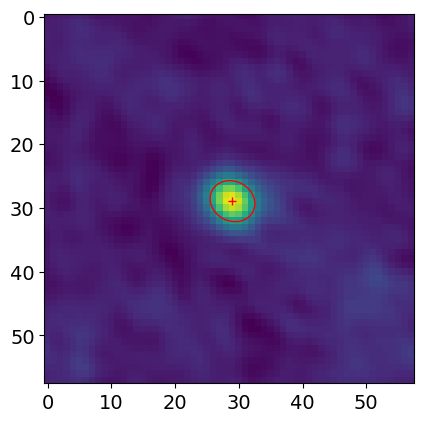

In [77]:
avgim_red = so_scube[100:160].mean(axis=0)
avgim_red.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
red_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
red_gfit = g = red_fit_g(g_init, x, y, z=avgim_red.value, weights=1/stats.mad_std(avgim_red.value))

src_red = radio_beam.Beam(major=red_gfit.x_stddev*pixscale_so*sig2fwhm,
                           minor=red_gfit.y_stddev*pixscale_so*sig2fwhm,
                           pa=90*u.deg+red_gfit.theta*u.rad)
ell = src_red.ellipse_to_plot(red_gfit.x_mean, red_gfit.y_mean, pixscale_so)
ell.set_facecolor('none')
ell.set_edgecolor('red')
pl.gca().add_artist(ell)

pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[100], so_scube.spectral_axis[160],
 so_scube[100:160].moment1(axis=0)[int(red_gfit.y_mean.value), int(red_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


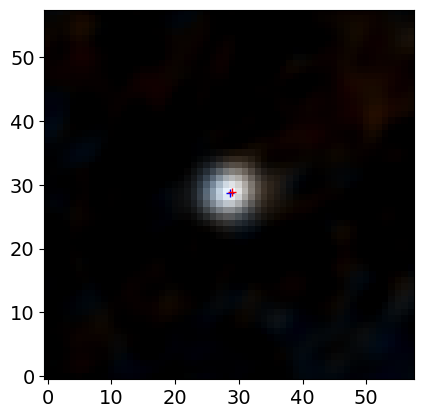

In [78]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [79]:
redbluesep = ((blue_gfit.x_mean - red_gfit.x_mean)**2 + (blue_gfit.y_mean - red_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(red_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(blue_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redbluesep, uncertainty, redbluesep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redbluesep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.48144464227550166,
 0.057005103356524166,
 <Quantity 0.12517561 arcsec>,
 <Quantity 0.01482133 arcsec>,
 <Quantity 1063.99265943 AU>,
 <Quantity 125.98127842 AU>)

In [80]:
# for estimating contour levels
avgim_blue.max()

<Projection 0.0252627 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


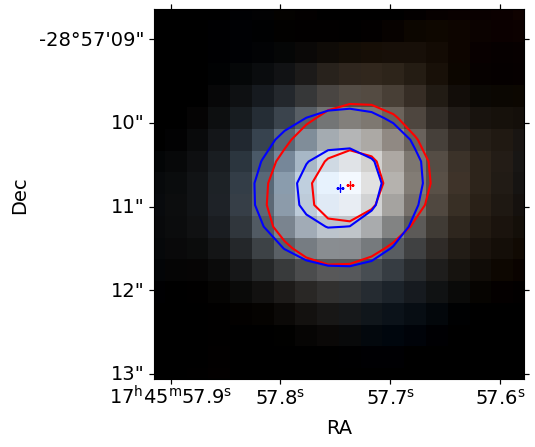

In [81]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
pl.contour(avgim_red, colors=['r', 'r'], levels=[0.01,0.02])
pl.contour(avgim_blue, colors=['b', 'b'], levels=[0.01,0.02])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SOmoment_red_and_blue.pdf', bbox_inches='tight')

In [82]:
coord_fit = so_scube.wcs.celestial.pixel_to_world(g.x_mean, g.y_mean)
coord_fit, coord_fit.to_string('hmsdms'), coord_fit.galactic

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.49056907, -28.95298356)>,
 '17h45m57.73657771s -28d57m10.74080944s',
 <SkyCoord (Galactic): (l, b) in deg
     (0.02464964, -0.07268737)>)

In [83]:
import radio_beam
# wouldn't deconvolve with theta as set; rotated 90 deg (probably not right?)

# this isn't a meaningful fit; the red/blue are meaningful.  Later on, the continuum fit should do the same...
#src = radio_beam.Beam(major=g.x_stddev*pixscale*2.35, minor=g.y_stddev*pixscale*2.35, pa=90*u.deg+g.theta*u.rad)
#src, so_scube.beam, src.deconvolve(so_scube.beam)

In [84]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_blue = 2*np.pi*blue_gfit.x_stddev*blue_gfit.y_stddev*pixarea_soscube
e_blue_amplitude = blue_fit_g.fit_info['param_cov'].diagonal()[0]**0.5
e_x_stddev_blue = blue_fit_g.fit_info['param_cov'].diagonal()[3]**0.5
e_y_stddev_blue = blue_fit_g.fit_info['param_cov'].diagonal()[4]**0.5
e_fitarea_blue = (2*np.pi*((e_x_stddev_blue*blue_gfit.y_stddev)**2 + (e_y_stddev_blue*blue_gfit.x_stddev)**2))**0.5 * pixarea_soscube
(np.abs(fitarea_blue - so_scube.beam.sr) / e_fitarea_blue ), (blue_gfit.amplitude / e_blue_amplitude), (fitarea_blue / so_scube.beam.sr).decompose()

(<Quantity 28.93664309>, 100.14939988461762, <Quantity 1.19476156>)

In [85]:
pixarea_soscube = so_scube.wcs.celestial.proj_plane_pixel_area()
fitarea_red = 2*np.pi*red_gfit.x_stddev*red_gfit.y_stddev*pixarea_soscube
e_red_amplitude = red_fit_g.fit_info['param_cov'].diagonal()[0]**0.5
e_x_stddev_red = red_fit_g.fit_info['param_cov'].diagonal()[3]**0.5
e_y_stddev_red = red_fit_g.fit_info['param_cov'].diagonal()[4]**0.5
e_fitarea_red = (2*np.pi*((e_x_stddev_red*red_gfit.y_stddev)**2 + (e_y_stddev_red*red_gfit.x_stddev)**2))**0.5 * pixarea_soscube
(np.abs(fitarea_red - so_scube.beam.sr) / e_fitarea_red ), (red_gfit.amplitude / e_red_amplitude), (fitarea_red / so_scube.beam.sr).decompose()

(<Quantity 39.25379824>, 96.65546540157992, <Quantity 1.29724665>)

In [86]:
pixscale_so = so_scube.wcs.celestial.proj_plane_pixel_area()**0.5

In [87]:
sig2fwhm = np.sqrt(8*np.log(2))

In [88]:
src_blue, so_scube.beam, src_blue.deconvolve(so_scube.beam)

(Beam: BMAJ=1.7620748890720797 arcsec BMIN=1.586849568267717 arcsec BPA=99.76237710482134 deg,
 Beam: BMAJ=1.6255785371840412 arcsec BMIN=1.4396964064791222 arcsec BPA=-52.087786316534505 deg,
 Beam: BMAJ=0.8525352340807809 arcsec BMIN=0.42538431832918944 arcsec BPA=69.62574283926001 deg)

In [89]:
src_red, so_scube.beam, src_red.deconvolve(so_scube.beam)

(Beam: BMAJ=1.8798980889065815 arcsec BMIN=1.6149799214172502 arcsec BPA=117.43592555965988 deg,
 Beam: BMAJ=1.6255785371840412 arcsec BMIN=1.4396964064791222 arcsec BPA=-52.087786316534505 deg,
 Beam: BMAJ=0.9670292792695546 arcsec BMIN=0.7012845506007191 arcsec BPA=-76.24391199209754 deg)

### Source fit leads to 1.5" size scale (so, beam-sized) - but it can deconvolve to ~0.8"

### Try again downsampled (higher S/N)

In [90]:
so_scube_ds = so_scube.downsample_axis(factor=10, axis=0)
so_scube_ds

In some cases, the final shape of the output from downsample_axis is incorrect, so use the result with caution


DaskSpectralCube with shape=(41, 58, 58) and unit=Jy / beam and chunk size (6, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:     41  type_s: VRAD      unit_s: km / s  range:     -296.369 km / s:     293.329 km / s

In [91]:
rows = []
for chan in range(so_scube_ds.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value)
    rows.append(g.parameters)
    #print(chan, g.parameters)
tb2 = Table(np.array(rows), names=g.param_names)
tb2

<Table length=41>
      amplitude               x_mean             y_mean              x_stddev               y_stddev                theta        
       float64               float64            float64              float64                float64                float64       
---------------------- ------------------- ------------------ ---------------------- ---------------------- ---------------------
  0.005905585860934528  26.328576906592797  34.62835040278195      2.223591493629204      6.143321726898192    1.4044253533118467
 0.0051844463456161205  31.643804508650515    32.155286780698      8.430427514228322      1.617510322407969  -0.19444014117558736
  0.005680080658306295   32.37743393773512  30.79586320983435      6.201328799229736     1.8372987093384185   0.01925491221517151
  0.004466647678453937   34.49168760886746  28.42773038878257      6.863433086440286     1.6633525742944029  -0.41298774500885754
 0.0026836125945029453  29.199514876698476  28.43392904383554     2.8346325397063814 1.1754943508222875e-38   -0.4846850113170254
 0.0021286195737177833  29.669661772152843 24.388187229793648     1.4153751884510877 1.1754943508222875e-38  -0.02069692356870769
-0.0013055802129225426  28.703801048226392 22.764780298104306      3.589776841664849 1.1754943508222875e-38 -0.009950217987713233
 0.0026761589337948545  23.191125618972922  30.54714951389411      6.259404232251199     1.4011830145973465   -0.1263525824965948
  0.006269812709827055   34.92395995124469 31.176221997470012      4.516466183308611      1.454413298532732   0.36178613243530244
   0.00446663232596735  31.776964869340368 30.850275629310946      6.633910900739754     1.6234459495358393    0.3838294754061799
  0.003735955729704185   27.35826432237159 29.844063142584115     1.2848312811309393     5.2956768654416795   -0.2379412076489553
  0.004128527856246432   18.89215058055164 29.622760256198077     2.1006875931499356     11.318395126086976    0.6961496035914125
  0.007579184342278224   27.51206162405581 32.613056765503195     1.3721519152160537     2.1439445666992154   -0.4019426699660643
 0.0031965468032606106  23.820007300137455 31.605411503750762 1.1754943508222875e-38      4.314475540950832   0.09427401820178666
 0.0006409542649776381  24.635853929045705  32.44960221177228 1.1754943508222875e-38     3.4632608288462254   0.03723338271292305
  0.004278464820375466   32.47007426695607  40.90412618085624     1.1581118028780437     4.4321615014471885  -0.04622175945049441
 0.0031468601888679803 -0.5540808105409533  34.12995487106651     30.471236744759466     2.2864986827170632    -0.188813801209722
  0.008062391122324142  25.231781251967206  30.57037409392884      5.102362822845134      2.178690819355693   -0.5996627990977578
  0.005076154068264229  28.440202127237118 28.891884695447107      6.148187898138492     1.5444711974752259  -0.44839169040700494
  0.003006741865905987  29.547442983426546 29.807440230526684      8.367954544117286     2.5462719678086363    0.7528665638327763
  0.004079857321210367  32.742931129637476   32.9575915924136      5.264578227424151      4.870570429618939    0.9126090987051717
 0.0032369837301215866  30.680420675019356  32.68898813804893     4.0359431702901025      6.969983507979104    -2.070784218897746
  0.006790320774579394  27.499675812933447 28.488219955654262     2.3964661820339237     1.6608710985495216    0.6655718587152509
  0.005963858486119376  15.287438909851542  30.01627311422624      5.908952672160044     1.6390082674190132   -1.5640428346960233
 0.0035738434105597443  29.635976948643204 31.744457792637085     0.9985000976185494 1.1754943508222875e-38  -0.22537248528116038
  0.004043105096425644  30.810118846355774  30.48640179596179     2.8691684999006712 1.1754943508222875e-38  -0.20299460683205836
-0.0004375590761624606  30.169761049978298 27.446923845627914     0.2841781519306492 1.1754943508222875e-38 -0.012142703351433519
 0.0035258088932398957   25.56050866372555 25.551153147321422 1.1754943508222875e-

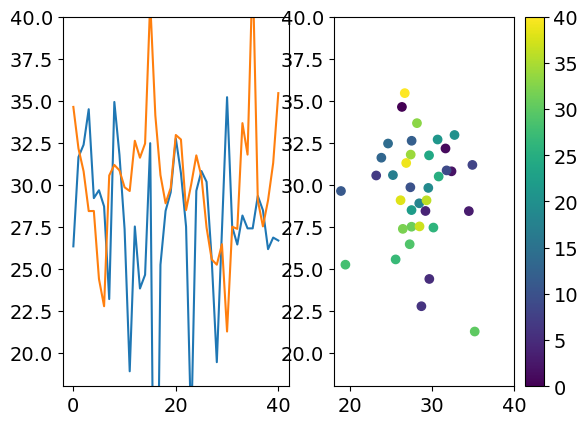

In [92]:
pl.subplot(1,2,1)
pl.plot(tb2['x_mean'])
pl.plot(tb2['y_mean'])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb2['x_mean'], tb2['y_mean'], c=np.arange(len(tb2)))
pl.colorbar()
pl.axis([18,40,18,40]);

## Repeat fits for CS - see if consistent

In [93]:
cs_scube = (scubes[-2]
            .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
            .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
cs_scube

DaskSpectralCube with shape=(402, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s

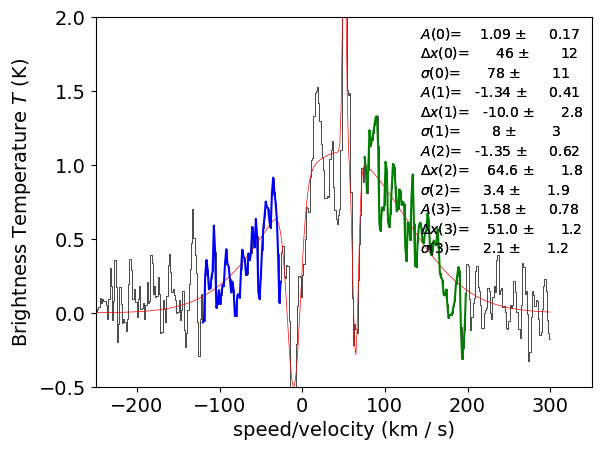

In [94]:
xx, yy = cs_scube.wcs.celestial.world_to_pixel(coord)
csspec = pyspeckit.Spectrum.from_hdu(cs_scube[:, int(yy), int(xx)].to(u.K).hdu)
csspec.xarr.convert_to_unit(u.GHz)
csspec.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
csspec.plotter(xmin=-250, xmax=350)
csspec.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])
red = csspec.slice(75, 200, unit=u.km/u.s)
pl.plot(red.xarr.value, red.data, color='g')
blue = csspec.slice(-120, -25, unit=u.km/u.s)
pl.plot(blue.xarr.value, blue.data, color='b')
pl.ylim(-0.5,2);

In [95]:
g_init.x_stddev.bounds

(1.1754943508222875e-38, None)

(<Quantity 1.81051129 arcsec>,
 <Quantity 2.10127098 arcsec>,
 <Gaussian2D(amplitude=0.00628209, x_mean=27.67804703, y_mean=28.645654, x_stddev=2.96319359, y_stddev=3.43906871, theta=5.89771595)>,
 <Quantity -60.72401402 km / s>)

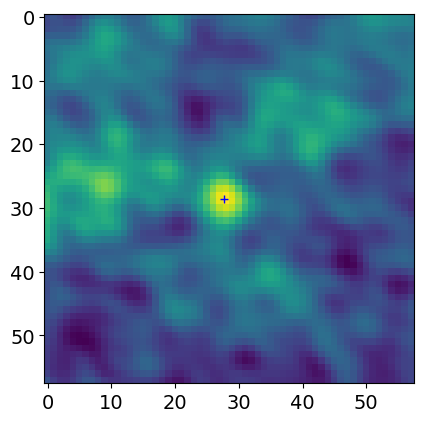

In [96]:
blue_cs_scube = cs_scube.subcube_from_regions([region]).spectral_slab(-120*u.km/u.s, -25*u.km/u.s)
avgim_bluecs = blue_cs_scube.mean(axis=0)
avgim_bluecs.quicklook()
g_init = Gaussian2D(amplitude=0.02, x_mean=29.1, y_mean=29.1, x_stddev=3., y_stddev=3)
g_init.x_mean.bounds = (27, 31)
g_init.y_mean.bounds = (27, 31)
bluecs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:blue_cs_scube.shape[1], :blue_cs_scube.shape[2]]
fitdata = avgim_bluecs.value

# crop out background
weights = np.ones_like(fitdata) * 1/stats.mad_std(avgim_bluecs.value)
weights[:,:24] = 0
weights[:23,:] = 0
weights[35:,:] = 0
weights[:,34:] = 0

bluecs_gfit = g = bluecs_fit_g(g_init, x, y, z=fitdata, weights=weights)
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 blue_cs_scube.moment1(axis=0)[int(bluecs_gfit.y_mean.value), int(bluecs_gfit.x_mean.value)])

(<Quantity 2.19709247 arcsec>,
 <Quantity 1.79375536 arcsec>,
 <Gaussian2D(amplitude=0.00976611, x_mean=28.57189919, y_mean=28.94914199, x_stddev=3.59589602, y_stddev=2.93576982, theta=-0.23338994)>,
 <Quantity 115.73128373 km / s>)

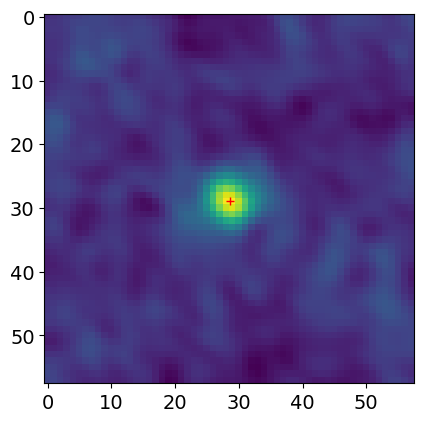

In [97]:
red_cs_scube = cs_scube.subcube_from_regions([region]).spectral_slab(75*u.km/u.s, 200*u.km/u.s)
avgim_redcs = red_cs_scube.mean(axis=0)
avgim_redcs.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
redcs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:red_cs_scube.shape[1], :red_cs_scube.shape[2]]
redcs_gfit = g = redcs_fit_g(g_init, x, y, z=avgim_redcs.value, weights=1/stats.mad_std(avgim_redcs.value))
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 red_cs_scube.moment1(axis=0)[int(redcs_gfit.y_mean.value), int(redcs_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


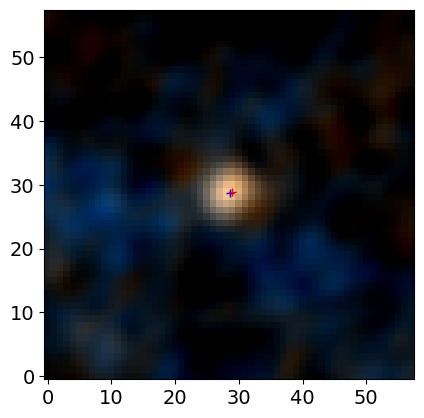

In [98]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [99]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.24543183 arcsec>,
 <Quantity 0.06530505 arcsec>,
 <Quantity 2086.17052455 AU>,
 <Quantity 555.09295398 AU>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


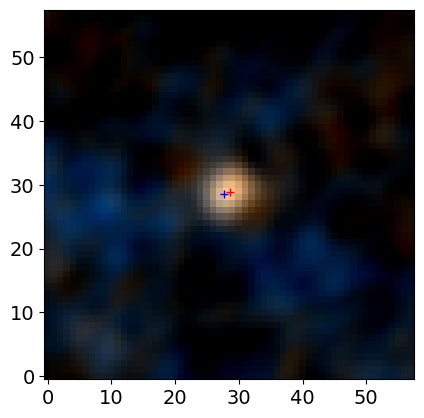

In [100]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')

In [101]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.24543183 arcsec>,
 <Quantity 0.06530505 arcsec>,
 <Quantity 2086.17052455 AU>,
 <Quantity 555.09295398 AU>)

In [102]:
# for estimating contour levels
avgim_bluecs.max()

<Projection 0.00630689 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


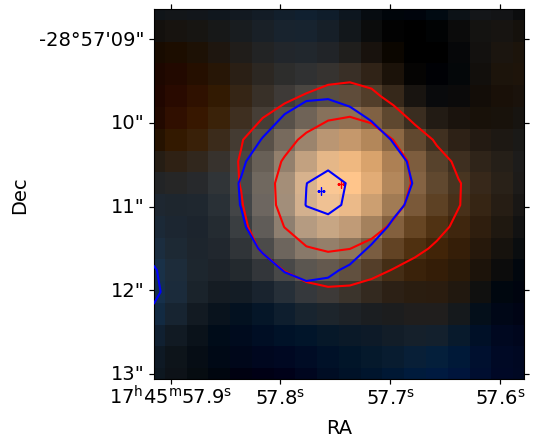

In [103]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
pl.contour(avgim_redcs, colors=['r', 'r'], levels=[0.003,0.006])
pl.contour(avgim_bluecs, colors=['b', 'b'], levels=[0.003,0.006])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSmoment_redcs_and_bluecs.pdf', bbox_inches='tight')

# Fit positions of moment maps

In [104]:
sig2fwhm = np.sqrt(8*np.log(2))

In [105]:
centroid_measurements = []

## SO first

In [106]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

### Moment images

In [107]:
background_stddev_so = so_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_so = so_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_so_spec = so_scube.subcube_from_regions([circle]).mean(axis=(1,2))

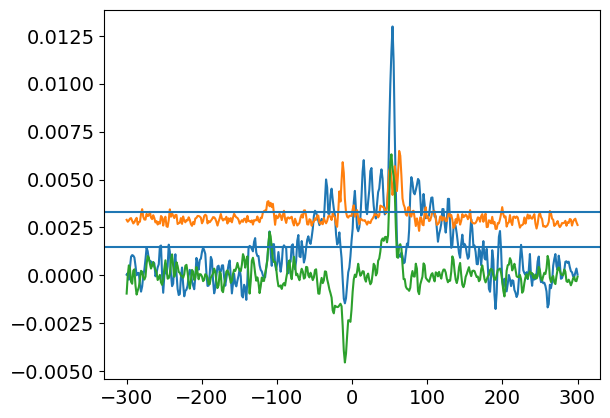

In [108]:
pl.plot(mean_so_spec.spectral_axis, mean_so_spec.value)
pl.plot(mean_so_spec.spectral_axis, background_stddev_so.value)
pl.plot(mean_so_spec.spectral_axis, background_mean_so.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

In [109]:
sig2fwhm = np.sqrt(8*np.log(2))
def convert_uncertainties(unc, jtok):
    return [unc[0],
            unc[0] / jtok,
            unc[1] * pixscale,
            unc[2] * pixscale,
            unc[3] * pixscale * sig2fwhm,
            unc[4] * pixscale * sig2fwhm,
            unc[5]*180/np.pi]

In [110]:
from astropy.io import fits

In [111]:
def galactic_cutout(hdu, reg):
    import reproject.mosaicking, reproject
    csys, sz = reproject.mosaicking.find_optimal_celestial_wcs(hdu, frame='galactic')
    newdata, _ = reproject.reproject_interp(input_data=hdu,
                                            output_projection=csys,
                                            shape_out=sz)
    preg = reg.to_pixel(csys)
    msk = preg.to_mask()
    slcs,_ = msk.get_overlap_slices(newdata.shape)
    new_hdu = fits.PrimaryHDU(data=newdata[slcs], header=csys[slcs].to_header())
    return new_hdu, csys[slcs]

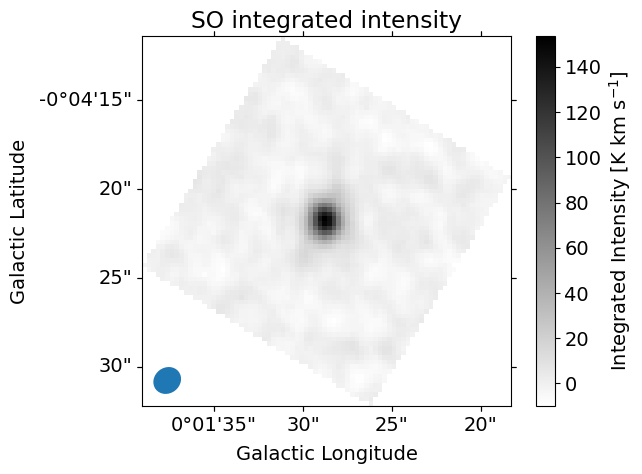

In [112]:
contest = so_scube.median(axis=0)
m0 = ((so_scube-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()
m0_so_ptsrc = m0
m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.fits', overwrite=True)

jtok = m0.beam.jtok(so_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0gal, m0galwcs = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=m0galwcs)
im = ax.imshow(m0gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0galwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0_small.pdf', bbox_inches='tight')

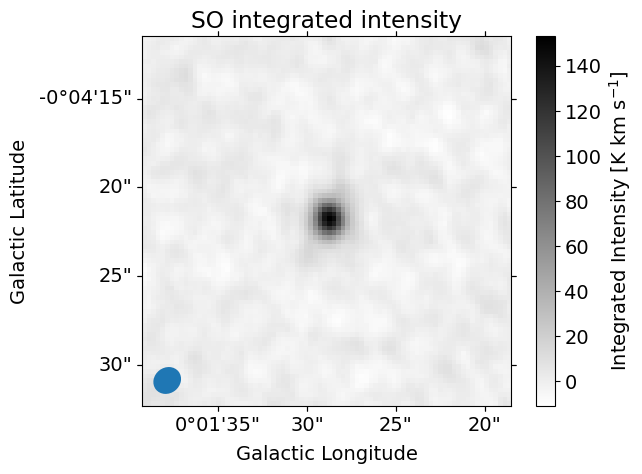

In [113]:
so_scube_toplot = (cubes[-2]
                   .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz)
                   .spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
                   .subcube_from_regions([cutregion]))
contest = so_scube_toplot.median(axis=0)
m0 = ((so_scube_toplot-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()
m0_so_ptsrc = m0
m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0_toplot.fits', overwrite=True)

jtok = m0.beam.jtok(so_scube_toplot.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0gal, m0galwcs = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=m0galwcs)
im = ax.imshow(m0gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0galwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.pdf', bbox_inches='tight')

In [114]:
# do the gaussian fitting in Celestial frame
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()

# redefine m0 so it's not the plot version
contest = so_scube.median(axis=0)
m0 = ((so_scube-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()

y, x = np.mgrid[:m0.shape[0], :m0.shape[1]]
stddev = stats.mad_std(m0.value, ignore_nan=True)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X & Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)

ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)
    
try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['SO 3(2)-2(1)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa,
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    centroid_measurements.append(['SO 3(2)-2(1)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.deg
                                 ] + convert_uncertainties(uncertainties, jtok))
print(centroid_measurements[-1])

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean           x_stddev           y_stddev            theta       
    ------------------ ------------------ ----------------- ------------------ ------------------ ------------------
    148.32008973612423 28.675184605802404 28.82932587561258 2.5294143922434666 2.9667869508805436 2.0085460104975636 [1.12337197 0.02191275 0.01979418 0.01915809 0.022471   0.03343582]
Swapped X & Y
['SO 3(2)-2(1)', 'm0', 148.32008973612423, 2.795070225002834, <Longitude 266.49059622 deg>, <Latitude -28.95299025 deg>, <Quantity 0.00043018 deg>, <Quantity 0.00050456 deg>, <Quantity 205.08120936 deg>, <Quantity 0.00023586 deg>, <Quantity 0.00014205 deg>, <Quantity -1.41654092 rad>, 1.12337196911429, 0.02116977914495836, <Quantity 1.58258758e-06 deg>, <Quantity 1.42957969e-06 deg>, <Quantity 3.25822283e-06 deg>, <Quantity 3.82165046e-06 deg>, 1.9157313900457786]


#### SO fullcloud background

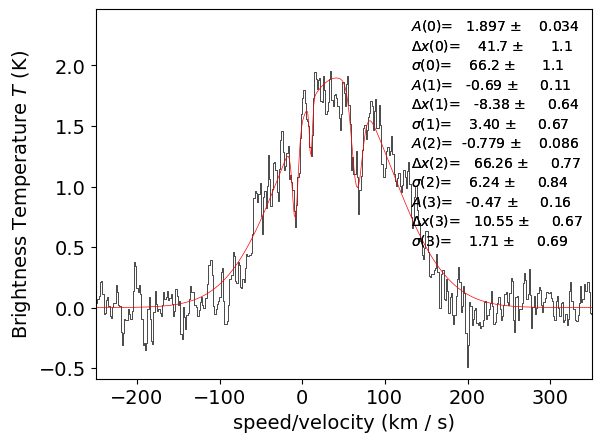

In [115]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_so32)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, -0.3, 10, 5])

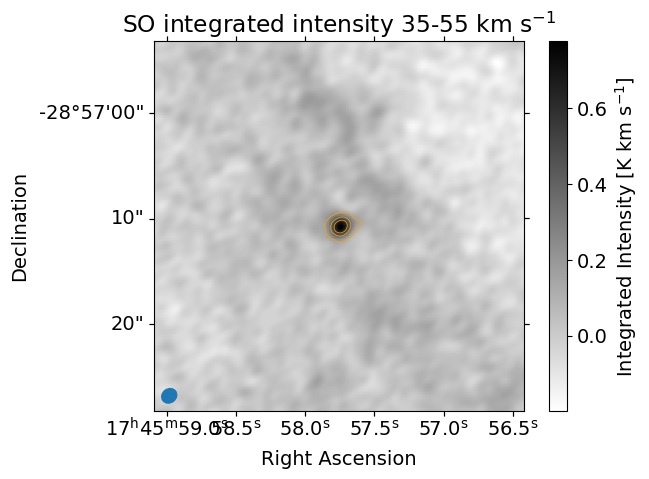

In [116]:
m0_bigcloud_3555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(35*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_3555_so.wcs)
im = ax.imshow(m0_bigcloud_3555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 35-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_35to55kms_with_comsrc.pdf', bbox_inches='tight')

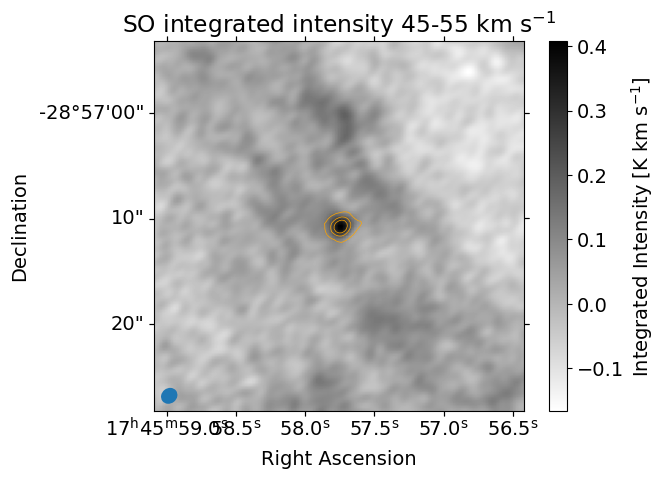

In [117]:
m0_bigcloud_4555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555_so.wcs)
im = ax.imshow(m0_bigcloud_4555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc_celestial.pdf', bbox_inches='tight')

DaskSpectralCube with shape=(8, 269, 269) and unit=Jy / beam and chunk size (8, 54, 269):
 n_x:    269  type_x: RA---SIN  unit_x: deg    range:   266.479591 deg:  266.501714 deg
 n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -28.962656 deg:  -28.943299 deg
 n_s:      8  type_s: VRAD      unit_s: km / s  range:       44.919 km / s:      55.239 km / s


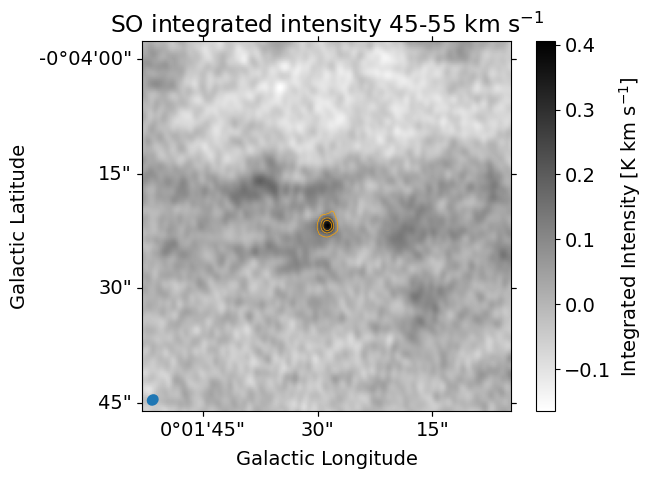

In [118]:
big_so_scube = (cubes[-2]
                    .subcube_from_regions([bigcircregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   )
print(big_so_scube)
m0_bigcloud_4555_so = big_so_scube.moment0()
m0_bigcloud_4555_so_gal, ww = galactic_cutout(m0_bigcloud_4555_so.hdu, bigregion)

fig = pl.figure()
ax = pl.subplot(projection=ww)
im = ax.imshow(m0_bigcloud_4555_so_gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("SO integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

#### H13COP

Not a clear detection

In [119]:
scubes[1], nurest_h13cop

(DaskSpectralCube with shape=(956, 58, 58) and unit=Jy / beam and chunk size (22, 58, 58):
  n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
  n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
  n_s:    956  type_s: FREQ      unit_s: Hz     range: 86666488077.200 Hz:87132826992.200 Hz,
 <Quantity 86.7543 GHz>)

In [120]:
h13cop_scube = scubes[1].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop = scubes[1].median(axis=0)

background_stddev_h13cop = h13cop_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop = h13cop_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop_spec = h13cop_scube.subcube_from_regions([circle]).mean(axis=(1,2))

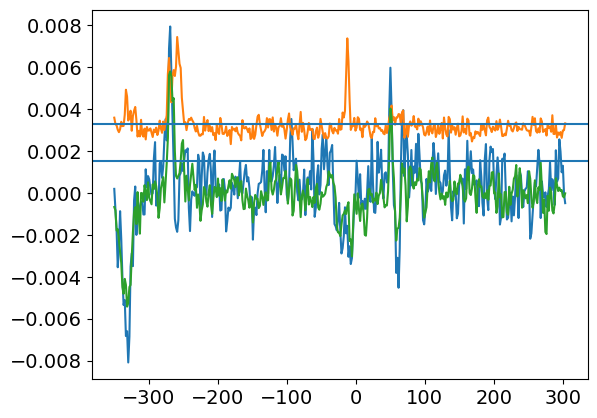

In [121]:
pl.plot(mean_h13cop_spec.spectral_axis, mean_h13cop_spec.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_stddev_h13cop.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_mean_h13cop.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean             y_mean            x_stddev          y_stddev           theta       
    ----------------- ------------------ ------------------ ----------------- ----------------- ------------------
    12.23002159398392 27.609989523601126 29.847964504491703 7.206119014930517 8.129650590986492 0.9895282199076768 [0.28418466 0.18269116 0.17417562 0.1674283  0.18890067 0.13585309]
Swapped X and Y


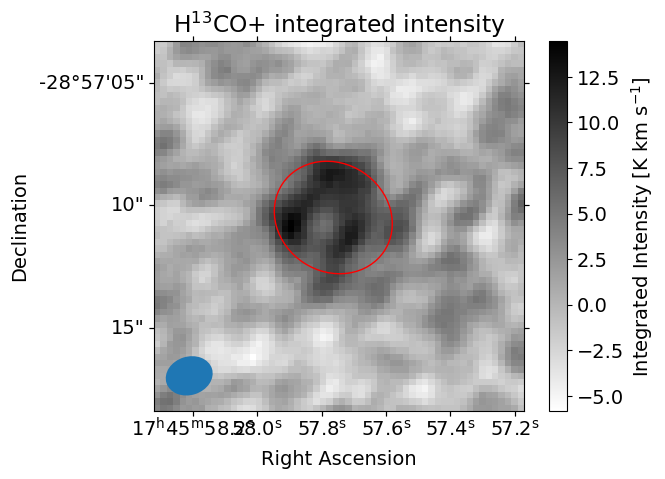

In [122]:
m0 = ((h13cop_scube-contest_h13cop)
      .with_mask((background_stddev_h13cop < 0.0033*background_stddev_h13cop.unit)[:,None,None])
      .with_mask((mean_h13cop_spec > 0.0015*mean_h13cop_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop_scube.shape[1], :h13cop_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

#try:
#    deconv_size = src.deconvolve(m0.beam)
#    
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  deconv_size.major, deconv_size.minor, deconv_size.pa
#                                 ])
#except radio_beam.utils.BeamError:
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                 ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.fits', overwrite=True)

#### H13COP: Tsuboi's data

In [123]:
sc = [c for c in scubes2012 if nurest_h13cop < c.spectral_axis.max() and nurest_h13cop > c.spectral_axis.min()][0]
sc = sc.mask_out_bad_beams(threshold=0.1)
h13cop2012_scube = sc.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop2012 = sc.median(axis=0)

background_stddev_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop2012_spec = h13cop2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


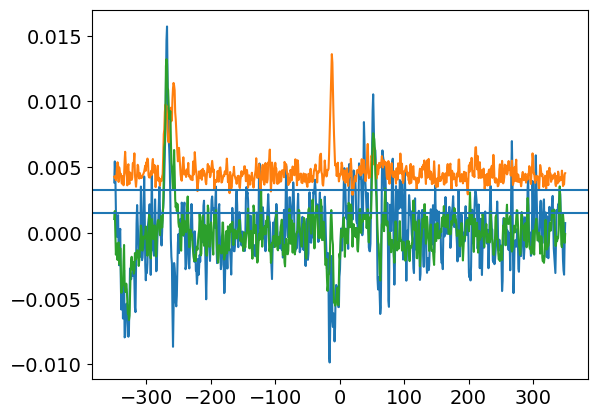

In [124]:
pl.plot(mean_h13cop2012_spec.spectral_axis, mean_h13cop2012_spec.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_stddev_h13cop2012.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_mean_h13cop2012.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean             y_mean            x_stddev          y_stddev             theta       
    ------------------- ------------------ ------------------ ----------------- ------------------ -------------------
    0.36419285250456024 30.134332798921932 24.546232580170038 3.435195127930547 12.184678210133958 -0.5077098837579497 [0.02191978 0.39940337 0.64883995 0.20620773 0.74413222 0.02608826]
Swapped X and Y


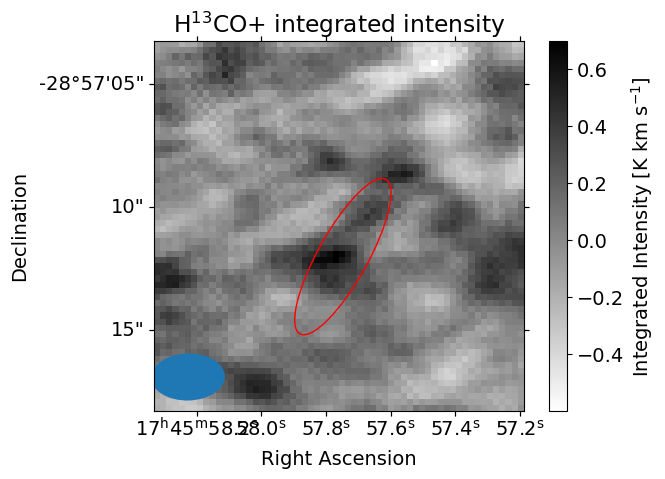

In [125]:
m0 = ((h13cop2012_scube-contest_h13cop2012)
      .with_mask((background_stddev_h13cop2012 < 0.0033*background_stddev_h13cop2012.unit)[:,None,None])
      .with_mask((mean_h13cop2012_spec > 0.0015*mean_h13cop2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop2012_scube.shape[1], :h13cop2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.fits', overwrite=True)

## Now CS moments

In [126]:
cs_scube = (scubes[-2]
            .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
            .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
big_cs_scube = (cubes[-2]
                .subcube_from_regions([bigcircregion])
                .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
                .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
cs_scube, big_cs_scube

(DaskSpectralCube with shape=(402, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
  n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
  n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
  n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s,
 DaskSpectralCube with shape=(402, 269, 269) and unit=Jy / beam and chunk size (60, 54, 269):
  n_x:    269  type_x: RA---SIN  unit_x: deg    range:   266.479591 deg:  266.501714 deg
  n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -28.962656 deg:  -28.943299 deg
  n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s)

In [127]:
background_stddev_cs = cs_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs = cs_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs_spec = cs_scube.subcube_from_regions([circle]).mean(axis=(1,2))

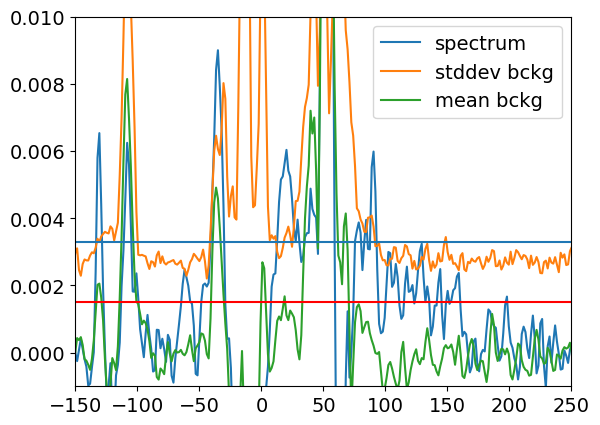

In [128]:
pl.plot(mean_cs_spec.spectral_axis, mean_cs_spec.value, label='spectrum')
pl.plot(mean_cs_spec.spectral_axis, background_stddev_cs.value, label='stddev bckg')
pl.plot(mean_cs_spec.spectral_axis, background_mean_cs.value, label='mean bckg')
pl.axhline(0.0033)
pl.axhline(0.0015, color='r')
pl.ylim(-0.001, 0.01)
pl.xlim(-150, 250)
pl.legend(loc='best');

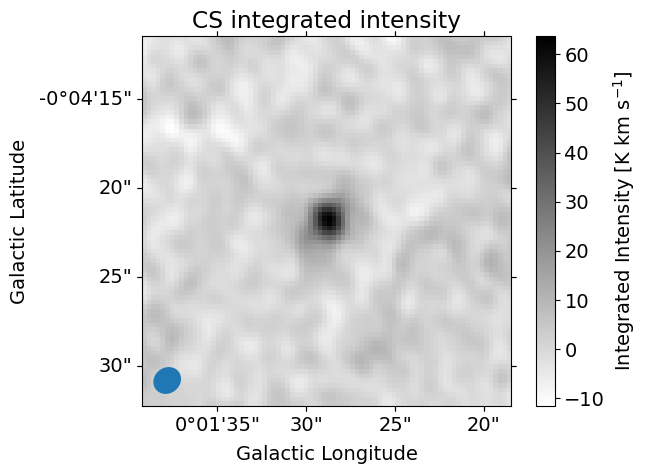

In [129]:
m0 = (big_cs_scube.with_mask((background_stddev_cs < 0.0033*background_stddev_cs.unit)[:,None,None])
              .with_mask((mean_cs_spec > 0.0010*mean_cs_spec.unit)[:,None,None])
              .spectral_slab(-150*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()
m0_cs_ptsrc = m0
jtok = m0.beam.jtok(cs_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

m0cs_gal, ww = galactic_cutout(m0.hdu, region)

fig = pl.figure()
ax = pl.subplot(projection=ww)
im = ax.imshow(m0cs_gal.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("CS integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.pdf', bbox_inches='tight')

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev         y_stddev            theta        
    ------------------ ------------------ ------------------ ----------------- ---------------- --------------------
    55.650578910083006 28.247627874657322 28.788487892112837 4.172805827895565 3.14902909536739 -0.06905730437108455 [0.76316068 0.05716715 0.04326269 0.05722582 0.04318505 0.03399555]


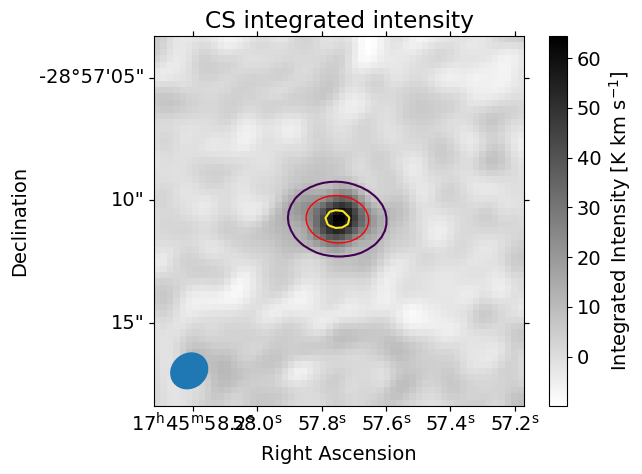

In [130]:
m0 = (cs_scube.with_mask((background_stddev_cs < 0.0033*background_stddev_cs.unit)[:,None,None])
              .with_mask((mean_cs_spec > 0.0010*mean_cs_spec.unit)[:,None,None])
              .spectral_slab(-150*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()
m0_cs_ptsrc = m0
jtok = m0.beam.jtok(cs_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_celestial.pdf', bbox_inches='tight')


g_init = Gaussian2D(amplitude=11, x_mean=m0.shape[1]/2., y_mean=m0.shape[0]/2., x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs_scube.shape[1], :cs_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
deconv_size = src.deconvolve(m0.beam)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

centroid_measurements.append(['CS 2-1', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.fits', overwrite=True)

ax.contour(g(x,y), levels=[10, 50])

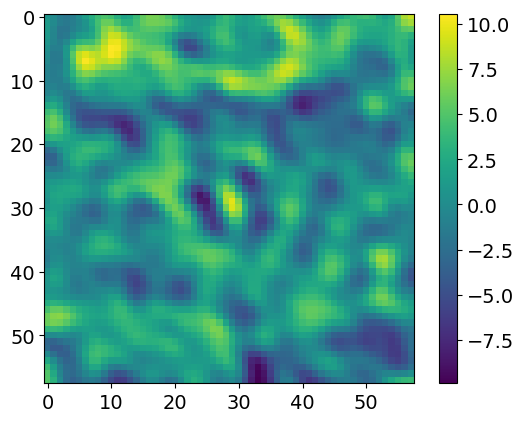

In [131]:
pl.imshow(m0.value - g(x,y))
pl.colorbar();

In [132]:
nurest_cs21

<Quantity 9.798095e+10 Hz>

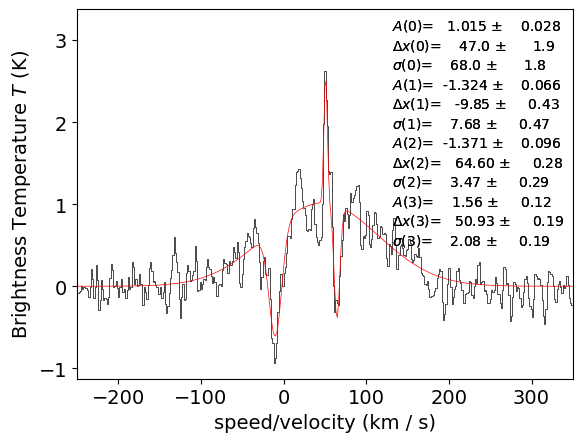

In [133]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])

### C34S Tsuboi

Not a clear detection spatially (was kinda clear spectrally?)

In [134]:
c34s2012_scube = c34scube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_c34s21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_c34s2012 = sc.median(axis=0)

background_stddev_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_c34s2012_spec = c34s2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


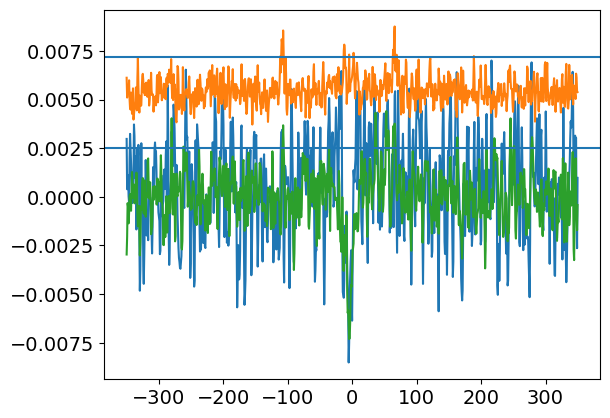

In [135]:
pl.plot(mean_c34s2012_spec.spectral_axis, mean_c34s2012_spec.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_stddev_c34s2012.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_mean_c34s2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

#### C34S integrated intensity

Doesn't look very pointlike!  But this could be a low S/N issue?  and/or contamination issue?

Or does it maybe hint at there being some interaction between the source and surroundings?

I don't really trust the image quality of this data set enough to believe the latter.... but it mgiht be worth a deeper dive.

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev           theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- ------------------
    17.359836393603224 29.775969638907664 31.109106845025654 8.283242158498897 9.898672930205665 1.8347554157856887 [0.2684331  0.15146828 0.1299     0.12806197 0.15321886 0.06104767]
Swapped X and Y


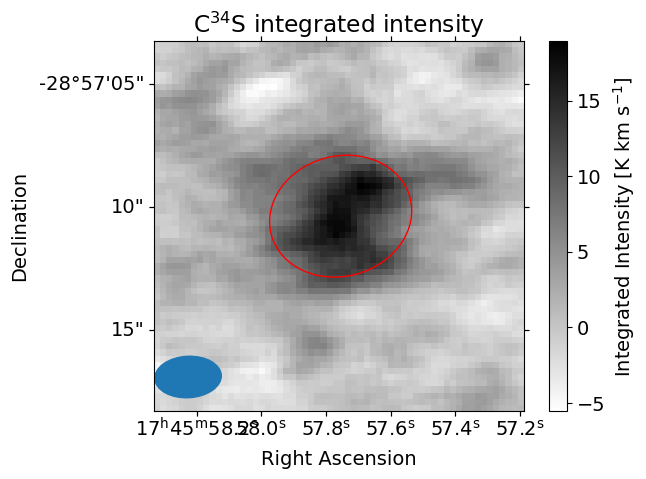

In [136]:
m0 = ((c34s2012_scube.mask_out_bad_beams(threshold=0.1)-contest_c34s2012)
      .with_mask((background_stddev_c34s2012 < 0.0072*background_stddev_c34s2012.unit)[:,None,None])
      .with_mask((mean_c34s2012_spec > 0.0025*mean_c34s2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(c34s2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("C$^{34}$S integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:c34s2012_scube.shape[1], :c34s2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.fits', overwrite=True)

#### CS Tsuboi

In [137]:
cs2012_scube = cscube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_cs2012 = sc.median(axis=0)

background_stddev_cs2012 = cs2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs2012 = cs2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs2012_spec = cs2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


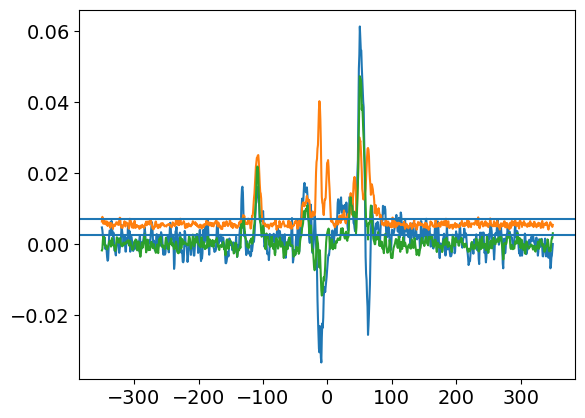

In [138]:
pl.plot(mean_cs2012_spec.spectral_axis, mean_cs2012_spec.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_stddev_cs2012.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_mean_cs2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev            theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- -------------------
    39.360510712713065 28.418343038492665 29.929129423065167 7.372685417116367 5.603355578707319 0.10236894555425441 [0.46180285 0.08631363 0.06599495 0.08650475 0.06574462 0.02985654]


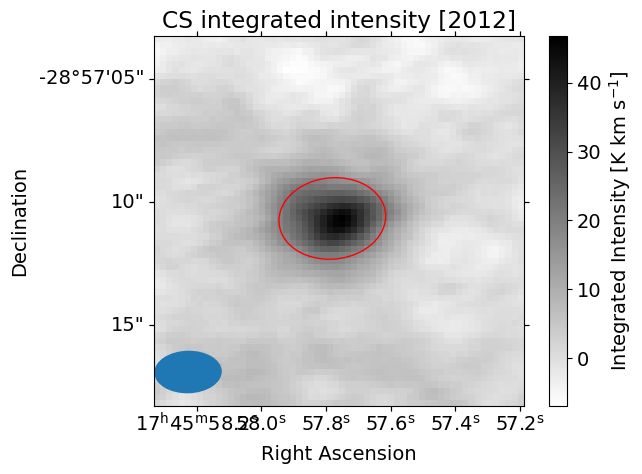

In [139]:
m0 = ((cs2012_scube-contest_cs2012)
      .with_mask((background_stddev_cs2012 < 0.0072*background_stddev_cs2012.unit)[:,None,None])
      .with_mask((mean_cs2012_spec > 0.0025*mean_cs2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(cs2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity [2012]")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs2012_scube.shape[1], :cs2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
                                 ] + convert_uncertainties(uncertainties, jtok))


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.fits', overwrite=True)

## continuum

In [140]:
ls /orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/*spw33_35*cont*fits -d 

/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldhigh_spw33_35.cont.I.iter1.image.tt0.pbcor.fits*


In [141]:
from astropy.io import fits
from astropy.wcs import WCS

### ACES High

In [142]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldhigh_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
contcube = SpectralCube.read(fn)
fh = fits.open(fn)
contwcs = WCS(fh[0].header).celestial
preg = region.to_pixel(contwcs)
msk = preg.to_mask()
contim = msk.cutout(fh[0].data.squeeze());
beam = radio_beam.Beam.from_fits_header(fh[0].header)
jtok = beam.jtok(102*u.GHz).value
contim = contim * jtok

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean            y_mean           x_stddev          y_stddev             theta        
    ------------------ ------------------ ---------------- ----------------- ------------------ --------------------
    0.1035993267353875 29.103155173688595 29.0539155378385 2.825038328095847 2.4486689380830784 -0.08217934448721827 [0.00293752 0.08003667 0.06950718 0.08010363 0.06943    0.13972883]


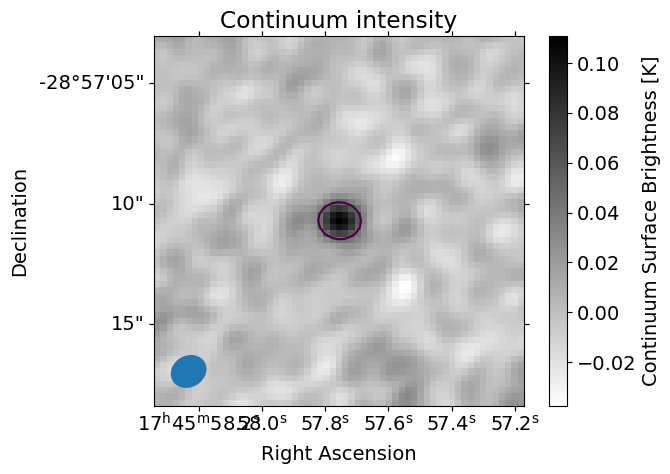

In [143]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
contwcs_co = contwcs[slcs] 
ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(contim, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_celestial.pdf', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:contim.shape[0], :contim.shape[1]]
stddev = stats.mad_std(contim)
g = fit_g(g_init, x, y, z=contim, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = contwcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)


deconv_size = src.deconvolve(beam)

centroid_measurements.append(['Continuum', 'spw33+35', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


header = fh[0].header
header.update(contwcs_co.to_header())
fits.PrimaryHDU(data=contim, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

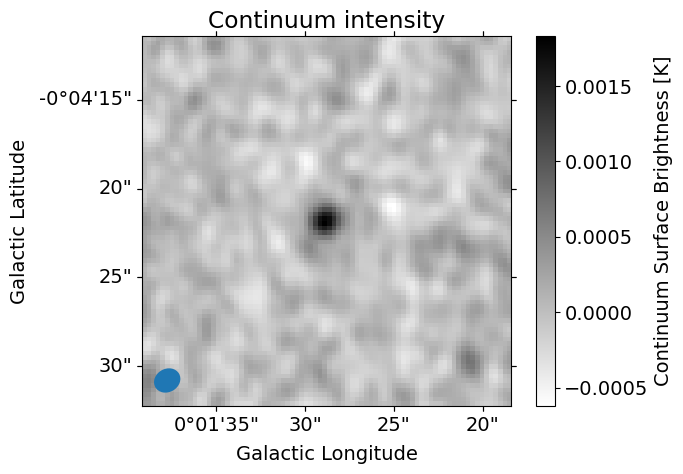

In [144]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldhigh_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
fh = fits.open(fn)
beam = radio_beam.Beam.from_fits_header(fh[0].header)
contim, contwcs = galactic_cutout((fh[0].data.squeeze(), WCS(fh[0].header).celestial), region)

fig = pl.figure()
ax = pl.subplot(projection=contwcs)
im = ax.imshow(contim.data, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum.pdf', bbox_inches='tight')


### ACES low

In [145]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw25_27.cont.I.iter1.image.tt0.pbcor"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldlow_spw25_27.cont.I.iter1.image.tt0.pbcor"
contlowcube = SpectralCube.read(fn, format='casa_image')
contlowwcs = contlowcube.wcs.celestial
preg = region.to_pixel(contlowwcs)
msk = preg.to_mask()
contlowim = msk.cutout(contlowcube[0].value.squeeze());
beam = contlowcube.beam
jtok = beam.jtok(86*u.GHz).value
contlowim = contlowim * jtok

divide by zero encountered in long_scalars


stddev=0.00832444300689935
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean            y_mean            x_stddev           y_stddev             theta       
    ------------------- ----------------- ------------------ ------------------ ------------------ -------------------
    0.10767496597887678 29.35838645781794 29.387634216852284 3.2184438999963145 2.9130088145281268 -0.4814086690580581 [0.00216922 0.06356871 0.06005745 0.06483757 0.05868532 0.14265151]


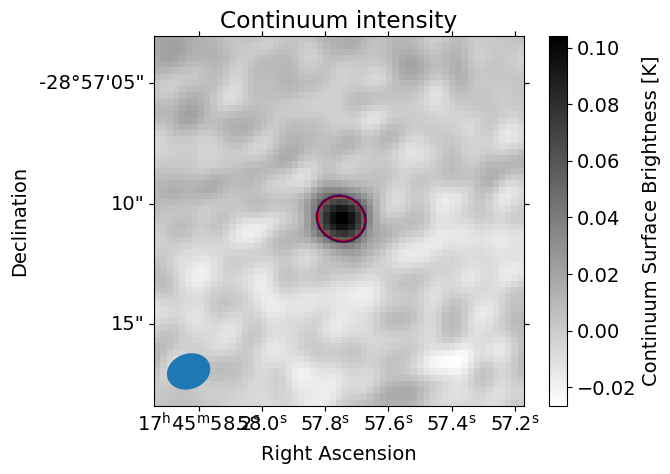

In [146]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
contlowwcs_co = contlowwcs[slcs] 
ax = pl.subplot(projection=contlowwcs_co)
im = ax.imshow(contlowim, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contlowwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_low_celestial.pdf', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:contlowim.shape[0], :contlowim.shape[1]]
stddev = stats.mad_std(contlowim, ignore_nan=True)
print(f'stddev={stddev}')
g = fit_g(g_init, x, y, z=contlowim, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = contlowwcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)


deconv_size = src.deconvolve(beam)

centroid_measurements.append(['Continuum', 'spw25+27', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ] + convert_uncertainties(uncertainties, jtok))


header = fh[0].header
header.update(contlowwcs_co.to_header())
fits.PrimaryHDU(data=contlowim, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/contlow_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

### Tsuboi cont (B3 2012)

As of 2024/1/28, haven't done this b/c the B3 cont never finished imaging and it wasn't provided as a quicklook product.

In [147]:
fn = "/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/Tsuboi2012_compactsource_continuum_r-2_bigger.image.pbcor.fits"
contcube2012 = SpectralCube.read(fn)
fh2012 = fits.open(fn)
cont2012wcs = WCS(fh2012[0].header).celestial
preg = region.to_pixel(cont2012wcs)
msk = preg.to_mask()
cont2012im = msk.cutout(fh2012[0].data.squeeze());
beam2012 = radio_beam.Beam.from_fits_header(fh2012[0].header)
jtok2012 = beam2012.jtok(fh2012[0].header['CRVAL3']*u.Hz).value
cont2012im = cont2012im * jtok2012

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean             y_mean           x_stddev          y_stddev            theta      
    ------------------- ------------------ ------------------ ---------------- ------------------ -----------------
    0.09061101825767252 30.117086671877843 31.217094633826335 3.32645392303497 2.1150863158013995 6.043637791311979 [0.00305824 0.11037332 0.07427165 0.11227051 0.07137143 0.05091961]
Beam: BMAJ=1.958300094208522 arcsec BMIN=1.2451619133548697 arcsec BPA=436.27493834794296 deg
Beam: BMAJ=2.3593678474428 arcsec BMIN=1.39660358428944 arcsec BPA=86.99076843262 deg


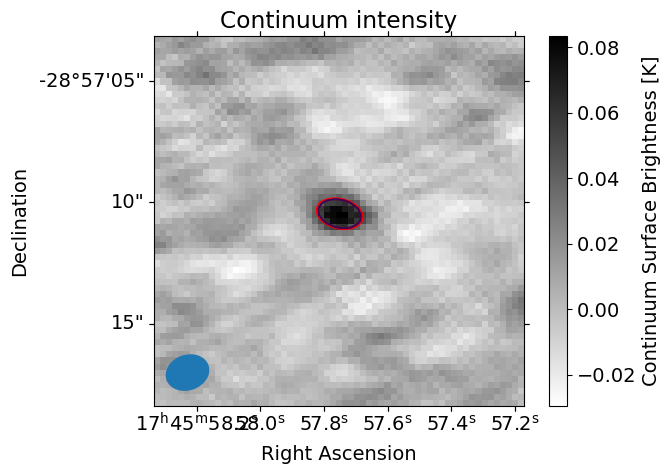

In [148]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh2012[0].data.squeeze().shape)
cont2012wcs_co = cont2012wcs[slcs] 
ax = pl.subplot(projection=cont2012wcs_co)
im = ax.imshow(cont2012im, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = cont2012wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont2012inuum.pdf', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cont2012im.shape[0], :cont2012im.shape[1]]
stddev = stats.mad_std(cont2012im)
g = fit_g(g_init, x, y, z=cont2012im, weights=1/stddev)
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = cont2012wcs_co.pixel_to_world(g.x_mean, g.y_mean)


if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

try:
    deconv_size = src.deconvolve(beam2012)
    
    centroid_measurements.append(['Continuum 2012', 'cont', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok))
except radio_beam.utils.BeamError:
    print(src)
    print(beam2012)
    centroid_measurements.append(['Continuum 2012', 'cont', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
                                 ] + convert_uncertainties(uncertainties, jtok))


header = fh2012[0].header
header.update(cont2012wcs_co.to_header())
fits.PrimaryHDU(data=cont2012im, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont2012_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

### B7 cont

In [149]:
b7cont = SpectralCube.read('/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.mfs.I.manual.image.pbcor.fits')

In [150]:
b7cont.spectral_axis

<Quantity [3.50113125e+11] Hz>

##### B7 Continuum

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude           x_mean            y_mean            x_stddev           y_stddev             theta        
    ------------------- ---------------- ------------------ ------------------ ----------------- ---------------------
    0.08962154543570341 14.0249762541769 15.858071912894735 2.6576907279407394 2.026349586092263 -0.029603097676466444 [0.00367539 0.10898973 0.08314664 0.10900998 0.08312009 0.10565631]
Deconvolution failed: Beam could not be deconvolved


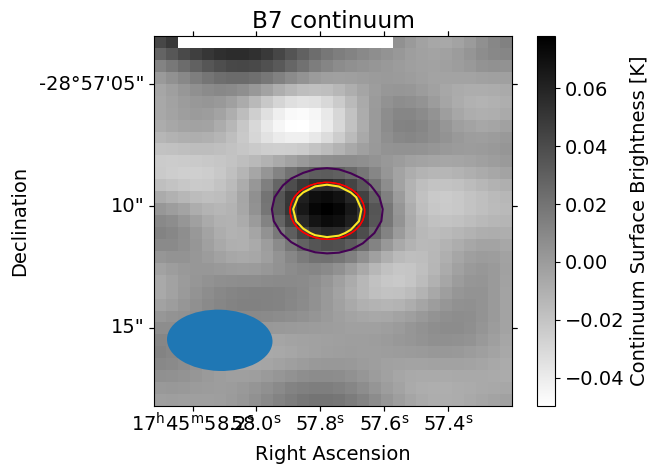

In [151]:
m0 = b7cont.subcube_from_regions([region]).to(u.K)
m0 = m0[0]
jtok = b7cont.beam.jtok(b7cont.spectral_axis[0])

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs.celestial)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("B7 continuum")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=m0.shape[1]/2, y_mean=m0.shape[0]/2, x_stddev=2.5, y_stddev=2.5)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:m0.shape[0], :m0.shape[1]]
stddev = stats.mad_std(m0.value[np.isfinite(m0.value)])
g = fit_g(g_init, x, y, z=np.nan_to_num(m0.value), weights=np.nan_to_num(1/stddev))
uncertainties = fit_g.fit_info['param_cov'].diagonal()**0.5
print(g, uncertainties)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    print("Swapped X and Y")
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=g.theta*u.rad)


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)




try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ] + convert_uncertainties(uncertainties, jtok.value))
except Exception as ex:
    print(f"Deconvolution failed: {ex}")
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.deg, np.nan*u.deg, np.nan*u.deg
                                 ] + convert_uncertainties(uncertainties, jtok.value))


ell = src.ellipse_to_plot(g.x_mean, g.y_mean, pixscale)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ax.add_artist(ell)

m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.fits', overwrite=True)
ax.contour(g(x,y), levels=[0.02, 0.05])

### Make table (spatial measurements)

In [160]:
from latex_info import rounded

In [161]:
coord.to_string('hmsdms', precision=3)

'17h45m57.753s -28d57m10.769s'

In [162]:
latexdict2 = latex_info.latexdict.copy()
latexdict2['header_start'] = r'\label{tab:spatial_measurements}'
latexdict2['caption'] = 'Spatial Measurements'
latexdict2['tablefoot'] = f"""\par
The Amp and Amp[mJy] values are in K \kms and Jy/beam \kms for the spectral lines.
The RA off and Dec. off columns give offsets from the coordinate {coord.to_string('hmsdms', precision=3)}.
Under the Major, Minor, and PA columns, the alternating rows with no errorbars give the beam-deconvolved sizes.
"""
latexdict2['preamble'] = r'\centering \small'
latexdict2['col_align'] = 'ccccclll'
formats2 = {
           #'Amp[Jy]': lambda x: "{0:0.3f}".format(x),
           #'Amp': lambda x: "{0:0.3f}".format(x),
           #'RA': lambda x: "{0:0.5f}".format(x),
           #'Dec': lambda x: "{0:0.5f}".format(x),
           #'Major': lambda x: "{0:0.2f}".format(x),
           #'Minor': lambda x: "{0:0.2f}".format(x),
           #'PA': lambda x: "{0:0.1f}".format(x),
           #'D. Major': lambda x: "{0:0.2f}".format(x),
           #'D. Minor': lambda x: "{0:0.2f}".format(x),
           #'D. PA': lambda x: "{0:0.1f}".format(x),
           #'RA off': lambda x: "{0:0.3f}".format(x),
           #'Dec. off': lambda x: "{0:0.3f}".format(x),
           #'eAmp[Jy]': lambda x: "{0:0.3f}".format(x),
           #'eAmp': lambda x: "{0:0.3f}".format(x),
           #'eRA': lambda x: "{0:0.5f}".format(x),
           #'eDec': lambda x: "{0:0.5f}".format(x),
           #'eMajor': lambda x: "{0:0.3f}".format(x),
           #'eMinor': lambda x: "{0:0.3f}".format(x),
           #'ePA': lambda x: "{0:0.3f}".format(x),
          }

In [163]:
centrfittbl = Table((list(zip(*centroid_measurements))),
                    names=['Image Data', 'Image Type', 'Amp', 'Amp[Jy]', 'RA', 'Dec', 'Major', 'Minor', 'PA',
                           'D. Major', 'D. Minor', 'D. PA',
                           'eAmp', 'eAmp[Jy]', 'eRA', 'eDec', 'eMajor', 'eMinor', 'ePA',
                          ])
centrfittbl['Amp'].unit = u.K
centrfittbl['Amp[Jy]'].unit = u.Jy/u.beam
centrfittbl['eAmp'].unit = u.K
centrfittbl['eAmp[Jy]'].unit = u.Jy/u.beam
centrfittbl['Amp[mJy]'] = centrfittbl['Amp[Jy]'].to(u.mJy/u.beam)
centrfittbl['eAmp[mJy]'] = centrfittbl['eAmp[Jy]'].to(u.mJy/u.beam)
centrfittbl['D. Major'] = centrfittbl['D. Major'].to(u.arcsec)
centrfittbl['D. Minor'] = centrfittbl['D. Minor'].to(u.arcsec)
centrfittbl['D. PA'] = centrfittbl['D. PA'].to(u.deg)
centrfittbl['Major'] = centrfittbl['Major'].to(u.arcsec)
centrfittbl['Minor'] = centrfittbl['Minor'].to(u.arcsec)
centrfittbl['eMajor'] = centrfittbl['eMajor'].to(u.arcsec)
centrfittbl['eMinor'] = centrfittbl['eMinor'].to(u.arcsec)
centrfittbl.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.ecsv', overwrite=True)

centrfittbl_tex = centrfittbl.copy()
for colname, fmt in zip(('Amp', 'Amp[mJy]', 'RA', 'Dec', 'Major', 'Minor', 'PA',),
                        ("0.2f", "0.1f", "0.5f", "0.5f", "0.2f", "0.2f", "0.1f")):
    col = centrfittbl[colname]
    ecol = centrfittbl['e'+colname]
    #fstrings = [f'{{0:0.{fmt}}} ({{1:{fmt}}})'
    data = ["{0} ({1})".format(*rounded(x, y)) for x, y in zip(col, ecol)]
    centrfittbl_tex[colname] = data
centrfittbl_tex['Image'] = [f'{row["Image Data"]} {row["Image Type"]}' for row in centrfittbl_tex] 

centrfittbl_tex['RA off'] = ["{0:0.2f}".format(x) for x in (centrfittbl['RA'].quantity - coord.ra).to(u.arcsec).value]

centrfittbl_tex['Dec. off'] = ["{0:0.2f}".format(x) for x in (centrfittbl['Dec'].quantity - coord.dec).to(u.arcsec).value]

new_centrfittbl_tex = {}
for col in ['Image', 'Amp', 'Amp[mJy]', 'RA off', 'Dec. off']:
    new_centrfittbl_tex[col] = [x for y in centrfittbl_tex[col] for x in (y, '')]

for col in ('Major', 'Minor', 'PA'):
    centrfittbl_tex['D. '+col] = ["{0:0.2f}".format(x) for x in centrfittbl_tex['D. '+col]]
    new_centrfittbl_tex[col] = ['-' if x=='nan' else x for y in zip(centrfittbl_tex[col], centrfittbl_tex['D. '+col]) for x in y]

centrfittbl_tex = Table(new_centrfittbl_tex)

centrfittbl_tex = centrfittbl_tex[['Image', 'Amp', 'Amp[mJy]', 'RA off', 'Dec. off', 'Major', 'Minor', 'PA',]]
                           #'D. Major', 'D. Minor', 'D. PA']]
centrfittbl_tex['RA off'].unit = u.arcsec
centrfittbl_tex['Dec. off'].unit = u.arcsec
centrfittbl_tex['Major'].unit = u.arcsec
centrfittbl_tex['Minor'].unit = u.arcsec
#centrfittbl_tex['D. Major'].unit = u.arcsec
#centrfittbl_tex['D. Minor'].unit = u.arcsec
centrfittbl_tex['PA'].unit = u.degree
#centrfittbl_tex['D. PA'].unit = u.degree
centrfittbl_tex['Amp'].unit = u.K
centrfittbl_tex['Amp[mJy]'].unit = u.mJy

centrfittbl_tex.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.tex',
                      latexdict=latexdict2, formats=formats2, overwrite=True)

In [164]:
#centrfittbl_tex['RA off'] = ["{0:0.2f}".format(x) for x in (centrfittbl['RA'].quantity - coord.ra).to(u.arcsec)]

In [165]:
centrfittbl['eAmp', 'eAmp[mJy]', 'Amp', 'Amp[mJy]']

<Table length=7>
         eAmp              eAmp[mJy]               Amp              Amp[mJy]     
          K                mJy / beam               K              mJy / beam    
       float64              float64              float64            float64      
--------------------- -------------------- ------------------- ------------------
     1.12337196911429   21.169779144958362  148.32008973612423  2795.070225002834
   0.7631606817915424   14.002185992613182  55.650578910083006 1021.0559520261367
    0.461802848515151    17.12031920493588  39.360510712713065 1459.2038781000233
 0.002937516986997629  0.05020077862969828  0.1035993267353875 1.7704635890274663
 0.002169220789288237 0.035414329664913376 0.10767496597887678 1.7578831812161775
 0.003058240145497893  0.04992830847000693 0.09061101825767252 1.4793000729555104
0.0036753869151865642    4.027956157050236 0.08962154543570341  98.21868120890748

In [166]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.tex

\begin{table*}[htp]
\centering \small
\caption{Spatial Measurements}
\begin{tabular}{ccccclll}
\label{tab:spatial_measurements}
Image & Amp & Amp[mJy] & RA off & Dec. off & Major & Minor & PA \\
 & $\mathrm{K}$ & $\mathrm{mJy}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\circ}}$ \\
\hline
SO 3(2)-2(1) m0 & 148.3 (1.1) & 2795.0 (21.0) & -0.15 & 0.00 & 1.549 (0.012) & 1.816 (0.014) & 205.1 (1.9) \\
 &  &  &  &  & 0.85 & 0.51 & -81.16 \\
CS 2-1 m0 & 55.65 (0.76) & 1021.0 (14.0) & -0.02 & -0.01 & 2.555 (0.035) & 1.928 (0.026) & 86.0 (1.9) \\
 &  &  &  &  & 2.04 & 1.17 & 80.22 \\
CS 2-1 2012 m0 & 39.36 (0.46) & 1459.0 (17.0) & 0.41 & 0.10 & 4.34 (0.051) & 3.299 (0.039) & 95.9 (1.7) \\
 &  &  &  &  & 3.38 & 2.80 & -78.42 \\
Continuum spw33+35 & 0.1036 (0.0029) & 1.77 (0.05) & 0.02 & 0.06 & 1.73 (0.049) & 1.499 (0.043) & 85.3 (8.0) \\
 &  &  &  &  & 0.99 & 0.43 & 60.15 \\
Continuum spw25+27 & 0.107

In [167]:
centrfittbl

<Table length=7>
  Image Data   Image Type         Amp                Amp[Jy]                RA                 Dec         ...          eDec                 eMajor               eMinor               ePA              Amp[mJy]           eAmp[mJy]      
                                   K                Jy / beam              deg                 deg         ...          deg                  arcsec               arcsec                               mJy / beam          mJy / beam     
    str14         str8          float64              float64             float64             float64       ...        float64               float64              float64             float64            float64             float64       
-------------- ---------- ------------------- --------------------- ------------------ ------------------- ... ---------------------- -------------------- -------------------- ------------------ ------------------ --------------------
  SO 3(2)-2(1)         m0  148.32008973612423     2.795070225002834 266.49059621672524 -28.952990249181713 ... 1.4295796949875372e-06 0.011729602184894276 0.013757941659364397 1.9157313900457786  2795.070225002834   21.169779144958362
        CS 2-1         m0  55.650578910083006    1.0210559520261366  266.4906315066001  -28.95299319702855 ...  3.124527899431712e-06 0.035036692951906125 0.026440185415154697 1.9478014394002021 1021.0559520261367   14.002185992613182
   CS 2-1 2012         m0  39.360510712713065    1.4592038781000234  266.4907519289075 -28.952964840932044 ...  4.582982726313251e-06  0.05092578092411806  0.03870418697793284 1.7106539063530941 1459.2038781000233    17.12031920493588
     Continuum   spw33+35  0.1035993267353875 0.0017704635890274662 266.49064343001675  -28.95297402672501 ...  5.019962665133276e-06  0.04904370567893654 0.042508737442000524  8.005872246318104 1.7704635890274663  0.05020077862969828
     Continuum   spw25+27 0.10767496597887678 0.0017578831812161775 266.49062236229594 -28.952949925750687 ...  4.337482781411711e-06  0.03969701316536432   0.0359302776867803  8.173329586857816 1.7578831812161775 0.035414329664913376
Continuum 2012       cont 0.09061101825767252 0.0014793000729555104   266.490628207597 -28.952906868429015 ... 5.1577534226871375e-06   0.0660942134928933  0.04201671566305052 2.9174789063973816 1.4793000729555104  0.04992830847000693
     Continuum         B7 0.08962154543570341   0.09821868120890748  266.4907408658049 -28.952833241989136 ... 1.1317180893926915e-05  0.12578244972080838  0.09590909834255602  6.053660767842139  98.21868120890748    4.027956157050236

In [168]:
centrfittbl_tex

<Table length=14>
       Image              Amp          Amp[mJy]   RA off Dec. off     Major         Minor          PA    
                           K             mJy      arcsec  arcsec      arcsec        arcsec        deg    
       str19             str15          str13      str5    str5       str13         str13        str11   
------------------- --------------- ------------- ------ -------- ------------- ------------- -----------
    SO 3(2)-2(1) m0     148.3 (1.1) 2795.0 (21.0)  -0.15     0.00 1.549 (0.012) 1.816 (0.014) 205.1 (1.9)
                                                                           0.85          0.51      -81.16
          CS 2-1 m0    55.65 (0.76) 1021.0 (14.0)  -0.02    -0.01 2.555 (0.035) 1.928 (0.026)  86.0 (1.9)
                                                                           2.04          1.17       80.22
     CS 2-1 2012 m0    39.36 (0.46) 1459.0 (17.0)   0.41     0.10  4.34 (0.051) 3.299 (0.039)  95.9 (1.7)
                                                                           3.38          2.80      -78.42
 Continuum spw33+35 0.1036 (0.0029)   1.77 (0.05)   0.02     0.06  1.73 (0.049) 1.499 (0.043)  85.3 (8.0)
                                                                           0.99          0.43       60.15
 Continuum spw25+27 0.1077 (0.0022) 1.758 (0.035)  -0.06     0.15  1.971 (0.04) 1.783 (0.036)  62.4 (8.2)
                                                                           1.22          0.21       33.67
Continuum 2012 cont 0.0906 (0.0031)  1.479 (0.05)  -0.03     0.30 1.958 (0.066) 1.245 (0.042) 436.3 (2.9)
                                                                              -             -           -
       Continuum B7 0.0896 (0.0037)    98.2 (4.0)   0.37     0.57    1.3 (0.13) 0.993 (0.096)  88.3 (6.1)
                                                                              -             -           -

#### Spectral Index

In [169]:
# wrong
# np.log(centrfittbl['Amplitude'][3] / centrfittbl['Amplitude'][2]) / np.log((350*u.GHz/(102*u.GHz)).decompose().value) + 2

$$a = d \log(b/c)$$
$$da = d \left(\frac{d}{db}  \log (b/c) + \frac{d}{dc} \log(b/c) \right)$$
$$ = d \left(\frac{d}{db}  (\log b - \log c) + \frac{d}{dc} (\log b - \log c) \right)$$
$$ = d \left( \frac{1}{b} - \frac{1}{c} \right)$$
errors should add...
$$\sigma_a^2 = d^2 \left( \left[\frac{\sigma_b}{b}\right]^2 + \left[\frac{\sigma_c}{c}\right]^2 \right)$$

In [170]:
centrfittbl.add_index('Image Data')
centrfittbl.add_index('Image Type')
b7r = centrfittbl.loc['Continuum'].loc['Image Type', 'B7']
b3r = centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']
spectral_index = (
    np.log(b7r['Amp[Jy]'] / b3r['Amp[Jy]']) /
    np.log((350*u.GHz/(102*u.GHz)).decompose().value))
spectral_index

3.2571647865885356

In [171]:
dd = np.log((350*u.GHz/(102*u.GHz)).decompose().value)
bb = b7r['Amp[Jy]']
cc = b3r['Amp[Jy]']
eb = b7r['eAmp[Jy]']
ec = b3r['eAmp[Jy]']
spectral_index_error = (dd**2 * ((eb/bb)**2 + (ec/cc)**2))**0.5
spectral_index_error

0.06147280967387818

In [172]:
dd = np.log((350*u.GHz/(102*u.GHz)).decompose().value)
bb = b7r['Amp[Jy]']
cc = b3r['Amp[Jy]']
eb = 0.1 * b7r['Amp[Jy]']
ec = 0.1 * b3r['Amp[Jy]']
spectral_index_systematic_error = (dd**2 * ((eb/bb)**2 + (ec/cc)**2))**0.5
spectral_index_systematic_error

0.1743669236392051

#### Proper Motion check

In [173]:
b32021 = centrfittbl.loc['Continuum 2012']
pos_2021 = SkyCoord(b3r['RA'], b3r['Dec'], frame='fk5', unit=(u.deg, u.deg))
pos_2012 = SkyCoord(b32021['RA'], b32021['Dec'], frame='fk5', unit=(u.deg, u.deg))
pos_2021.separation(pos_2012)

<Angle 6.84664594e-05 deg>

In [174]:
pm_l, pm_b = (pos_2021.galactic.l - pos_2012.galactic.l).to(u.arcsec), (pos_2021.galactic.b - pos_2012.galactic.b).to(u.arcsec)
pm_l, pm_b, (np.arctan2(pm_l.value, pm_b.value)*u.rad).to(u.deg)

(<Angle -0.18149652 arcsec>,
 <Angle -0.16676657 arcsec>,
 <Quantity -132.57809237 deg>)

In [175]:
pm_err = ((centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']['eRA']**2 +
           centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']['eDec']**2 + 
           centrfittbl.loc['Continuum 2012']['eRA']**2 + 
           centrfittbl.loc['Continuum 2012']['eDec']**2)**0.5 * u.deg).to(u.arcsec)
pm_err

<Quantity 0.04319477 arcsec>

In [176]:
print("SNR: ", (pos_2021.separation(pos_2012) / pm_err).decompose())
# PA
pos_2021.position_angle(pos_2012).to(u.deg)

SNR:  5.706228865031882


<Angle 348.78178482 deg>

In [177]:
(pos_2021.separation(pos_2012) * 8.5*u.kpc / (9*u.yr)).to(u.km/u.s, u.dimensionless_angles())

<Quantity 1103.5149773 km / s>

### Data Properties table

In [178]:
cubes_for_dataprops = {
    'Continuum (ACES)': contcube,
    'Continuum (2012)': contcube2012,
    'Continuum (B7)': b7cont,
    'CS (ACES)': cs_scube,
    'CS (2012)': cs2012_scube,
    'SO (ACES)': so_scube,
}

In [179]:
rows = []
for name,data in cubes_for_dataprops.items():
    try:
        beam = data.beam
    except AttributeError:
        beam = data.beams.common_beam()
    rows.append([name, data.header['DATE-OBS'], beam.major.to(u.deg), beam.minor.to(u.deg), beam.pa.to(u.deg), data.mad_std(),
                 beam.jtok(data.with_spectral_unit(u.GHz).spectral_axis.mean())])
dataprops = Table(rows)

In [180]:
latexdict3 = latex_info.latexdict.copy()
latexdict3['header_start'] = r'\label{tab:data_props}'
latexdict3['caption'] = 'Data Properties'
latexdict3['preamble'] = r'\centering'
formats3 = {'RMS': lambda x: "{0:0.1f}".format(x),
           'Major': lambda x: "{0:0.3f}".format(x),
           'Minor': lambda x: "{0:0.3f}".format(x),
           'PA': lambda x: "{0:0.3f}".format(x),
           'Jy/K': lambda x: "{0:0.1f}".format(x),
          }

In [181]:
dataprops = Table(np.array(rows),
                  names=['Data Type', 'Observation Date', 'Major', 'Minor', 'PA', 'RMS', 'Jy/K'],
                  units=['', '', u.deg, u.deg, u.deg, u.Jy/u.beam, ''],
                  dtype=['str', 'str', 'float', 'float', 'float', 'float', 'float'],
                 )
dataprops['RMS'] = dataprops['RMS'].quantity.to(u.mJy/u.beam)
dataprops['Major'] = dataprops['Major'].quantity.to(u.arcsec)
dataprops['Minor'] = dataprops['Minor'].quantity.to(u.arcsec)
dataprops.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.ecsv', overwrite=True)
dataprops.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.tex', latexdict=latexdict3, formats=formats3, overwrite=True)
dataprops

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


<Table length=6>
   Data Type          Observation Date            Major              Minor                 PA                 RMS                Jy/K       
                                                  arcsec             arcsec               deg              mJy / beam                       
     str32                 str32                 float64            float64             float64             float64            float64      
---------------- -------------------------- ------------------ ------------------ ------------------- ------------------- ------------------
Continuum (ACES) 2022-09-15T00:26:52.128000    1.5376515388488   1.30552673339844     -59.90698242188  0.2269098765962104  61.38686125320397
Continuum (2012) 2013-05-31T09:52:50.256001    2.3593678474428   1.39660358428944      86.99076843262 0.44383165869480257 43.963578702205965
  Continuum (B7) 2018-09-27T21:30:24.144000    4.3373970985428    2.5191247463226      88.34437561035   8.763660440970552 0.9124694440264549
       CS (ACES) 2022-09-15T00:26:52.128000 1.6255785371840412 1.4396964064791222 -52.087786316534505   3.406661983761855   54.3940981604282
       CS (2012) 2013-05-31T09:20:33.263999 2.7461946596895506 1.7308047418554628   91.41270308660249   6.626507761640067   26.7825046085672
       SO (ACES) 2022-09-15T00:26:52.128000 1.6255785371840412 1.4396964064791222 -52.087786316534505   3.155994671208645 52.958735154936264

In [182]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/data_properties.tex

\begin{table*}[htp]
\centering
\caption{Data Properties}
\begin{tabular}{ccccccc}
\label{tab:data_props}
Data Type & Observation Date & Major & Minor & PA & RMS & Jy/K \\
 &  & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\circ}}$ & $\mathrm{mJy\,beam^{-1}}$ &  \\
\hline
Continuum (ACES) & 2022-09-15T00:26:52.128000 & 1.538 & 1.306 & -59.907 & 0.2 & 61.4 \\
Continuum (2012) & 2013-05-31T09:52:50.256001 & 2.359 & 1.397 & 86.991 & 0.4 & 44.0 \\
Continuum (B7) & 2018-09-27T21:30:24.144000 & 4.337 & 2.519 & 88.344 & 8.8 & 0.9 \\
CS (ACES) & 2022-09-15T00:26:52.128000 & 1.626 & 1.440 & -52.088 & 3.4 & 54.4 \\
CS (2012) & 2013-05-31T09:20:33.263999 & 2.746 & 1.731 & 91.413 & 6.6 & 26.8 \\
SO (ACES) & 2022-09-15T00:26:52.128000 & 1.626 & 1.440 & -52.088 & 3.2 & 53.0 \\
\hline
\end{tabular}
\end{table*}


### plot deconvolved size

In [183]:
src_red, pixscale_so

(Beam: BMAJ=1.8798980889065815 arcsec BMIN=1.6149799214172502 arcsec BPA=117.43592555965988 deg,
 <Quantity 7.22222222e-05 deg>)

In [184]:
centrfittbl

<Table length=7>
  Image Data   Image Type         Amp                Amp[Jy]                RA                 Dec         ...          eDec                 eMajor               eMinor               ePA              Amp[mJy]           eAmp[mJy]      
                                   K                Jy / beam              deg                 deg         ...          deg                  arcsec               arcsec                               mJy / beam          mJy / beam     
    str14         str8          float64              float64             float64             float64       ...        float64               float64              float64             float64            float64             float64       
-------------- ---------- ------------------- --------------------- ------------------ ------------------- ... ---------------------- -------------------- -------------------- ------------------ ------------------ --------------------
  SO 3(2)-2(1)         m0  148.32008973612423     2.795070225002834 266.49059621672524 -28.952990249181713 ... 1.4295796949875372e-06 0.011729602184894276 0.013757941659364397 1.9157313900457786  2795.070225002834   21.169779144958362
        CS 2-1         m0  55.650578910083006    1.0210559520261366  266.4906315066001  -28.95299319702855 ...  3.124527899431712e-06 0.035036692951906125 0.026440185415154697 1.9478014394002021 1021.0559520261367   14.002185992613182
   CS 2-1 2012         m0  39.360510712713065    1.4592038781000234  266.4907519289075 -28.952964840932044 ...  4.582982726313251e-06  0.05092578092411806  0.03870418697793284 1.7106539063530941 1459.2038781000233    17.12031920493588
     Continuum   spw33+35  0.1035993267353875 0.0017704635890274662 266.49064343001675  -28.95297402672501 ...  5.019962665133276e-06  0.04904370567893654 0.042508737442000524  8.005872246318104 1.7704635890274663  0.05020077862969828
     Continuum   spw25+27 0.10767496597887678 0.0017578831812161775 266.49062236229594 -28.952949925750687 ...  4.337482781411711e-06  0.03969701316536432   0.0359302776867803  8.173329586857816 1.7578831812161775 0.035414329664913376
Continuum 2012       cont 0.09061101825767252 0.0014793000729555104   266.490628207597 -28.952906868429015 ... 5.1577534226871375e-06   0.0660942134928933  0.04201671566305052 2.9174789063973816 1.4793000729555104  0.04992830847000693
     Continuum         B7 0.08962154543570341   0.09821868120890748  266.4907408658049 -28.952833241989136 ... 1.1317180893926915e-05  0.12578244972080838  0.09590909834255602  6.053660767842139  98.21868120890748    4.027956157050236

Beam: BMAJ=0.9670292792695546 arcsec BMIN=0.7012845506007191 arcsec BPA=-76.24391199209754 deg
Beam: BMAJ=0.8525352340807809 arcsec BMIN=0.42538431832918944 arcsec BPA=69.62574283926001 deg
Beam: BMAJ=0.3605713930085234 arcsec BMIN=0.21716830916212065 arcsec BPA=-81.16181594416656 deg
Beam: BMAJ=0.8668977044506969 arcsec BMIN=0.49555816215987974 arcsec BPA=80.21977333385156 deg
Beam: BMAJ=1.433822977307313 arcsec BMIN=1.18870854968352 arcsec BPA=-78.41912117451031 deg
Beam: BMAJ=0.4219747669011235 arcsec BMIN=0.18171598830677518 arcsec BPA=60.15390194446932 deg


Assuming position angle has been specified in degrees


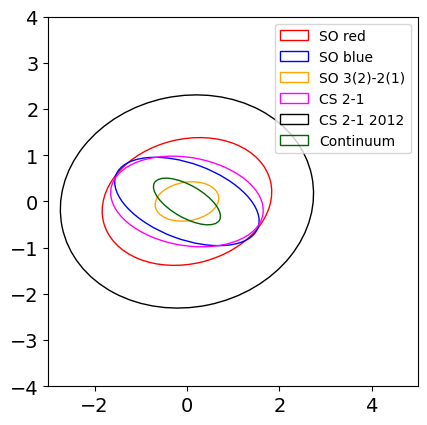

In [185]:
pl.figure()
ax = pl.gca()
print(src_red.deconvolve(so_scube.beam))
ell_r = src_red.deconvolve(so_scube.beam).ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))
print(src_blue.deconvolve(so_scube.beam))
ell_b = src_blue.deconvolve(so_scube.beam).ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))


ell_r.set_facecolor('none')
ell_r.set_edgecolor('r')
ell_b.set_facecolor('none')
ell_b.set_edgecolor('b')
ax.add_artist(ell_r)
ax.add_artist(ell_b)
ell_b.set_label('SO blue')
ell_r.set_label('SO red')

for row, color in zip(centrfittbl, ('orange', 'magenta', 'black', 'darkgreen')):
    src = radio_beam.Beam(major=row['D. Major']*u.arcsec/sig2fwhm, minor=row['D. Minor']*u.arcsec/sig2fwhm, pa=row['D. PA'])
    print(src)
    ell = src.ellipse_to_plot(0, 0, pixscale_so.to(u.arcsec))
    ell.set_facecolor('none')
    ell.set_edgecolor(color)
    ell.set_label(row['Image Data'])
    ax.add_artist(ell)
ax.axis([-3,5,-4,4])
ax.set_aspect('equal')
labels = ['SO red', 'SO blue'] + list(centrfittbl['Image Data'])
pl.legend(handles=ax.artists, labels=labels, loc='best', fontsize=10);

# model SO

In [186]:
from pyspeckit.spectrum.models import lte_molecule
from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
cdmstbl = CDMS.get_species_table()

In [187]:
cdmstbl[np.core.defchararray.find(cdmstbl['molecule'], 'SO') != -1]

<Table length=12>
 tag     molecule    #lines lg(Q(1000)) lg(Q(500)) lg(Q(300)) lg(Q(225)) lg(Q(150)) lg(Q(75)) lg(Q(37.5)) lg(Q(18.75)) lg(Q(9.375)) lg(Q(5.000)) lg(Q(2.725))
int64     str24       str9    float64    float64    float64    float64    float64    float64    float64     float64      float64      float64      float64   
----- -------------- ------ ----------- ---------- ---------- ---------- ---------- --------- ----------- ------------ ------------ ------------ ------------
48501        SO, v=0    449         nan        nan     2.9295     2.8009     2.6175    2.2956      1.9559       1.5897       1.2015       0.8698       0.6058
48502        SO, v=1    245         nan        nan     2.9295     2.8009     2.6175    2.2956      1.9559       1.5897       1.2015          nan          nan
48504 SO-sgl-D, v0,1     80         nan        nan     2.4708     2.3441     2.1678    1.8677      1.5686       1.2715       0.9784          nan          nan
49502          SO-17   2380         nan        nan      3.725     3.5962     3.4128    3.0906      2.7504       2.3831       1.9932       1.6596       1.3939
49512            HSO   6815         nan        nan     4.0112     3.8237     3.5595    3.1085      2.6586       2.2106       1.7676       1.3968       1.1146
50502          SO-18    359         nan        nan     2.9627     2.8339     2.6504     2.328      1.9873       1.6191       1.2276       0.8923       0.6252
64502       SO2, v=0  14754         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194       1.1157       0.7309
64503      SO2, v2=1   9808         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194          nan          nan
64512       SO2, nu2   7603         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194          nan          nan
65502         SOO-17   7476         nan      5.201     4.8674     4.6797     4.4153    3.9638      3.5128       3.0628       2.6144          nan          nan
65510      cis-HOSO+   4618         nan        nan       4.17     3.9824      3.718    3.2666      2.8156       2.3655       1.9169       1.5127       1.1269
66502         SOO-18  11511         nan        nan      4.104     3.9163      3.652    3.2004      2.7495       2.2994       1.8509          nan          nan

In [188]:
freqs, aij, deg, EU, partfunc = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [189]:
freqs_SO, aij_SO, deg_SO, EU_SO, partfunc_SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [190]:
freqs_SO2, aij_SO2, deg_SO2, EU_SO2, partfunc_SO2 = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=64502,
                                                                      catalog='CDMS', parse_name_locally=False)

In [191]:
freqs_CS, aij_CS, deg_CS, EU_CS, partfunc_CS = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=44501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [192]:
freqs_34SO, aij_34SO, deg_34SO, EU_34SO, partfunc_34SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=50501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [193]:
freqs_CH3SH, aij_CH3SH, deg_CH3SH, EU_CH3SH, partfunc_CH3SH = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=48510,
                                                                      catalog='CDMS', parse_name_locally=False)

In [194]:
freqs_C34S, aij_C34S, deg_C34S, EU_C34S, partfunc_C34S = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=46501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [195]:
freqs_H13COp, aij_H13COp, deg_H13COp, EU_H13COp, partfunc_H13COp = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                         molecule_tag=30504,
                                                                      catalog='CDMS', parse_name_locally=False)

In [196]:
freqs_H13CN, aij_H13CN, deg_H13CN, EU_H13CN, partfunc_H13CN = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [197]:
freqs_HC15N, aij_HC15N, deg_HC15N, EU_HC15N, partfunc_HC15N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28506,
                                                                      catalog='CDMS', parse_name_locally=False)

In [198]:
freqs_SiO, aij_SiO, deg_SiO, EU_SiO, partfunc_SiO = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=44505,
                                                                      catalog='CDMS', parse_name_locally=False)

In [199]:
freqs_HC3N, aij_HC3N, deg_HC3N, EU_HC3N, partfunc_HC3N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=51501,
                                                                      catalog='CDMS', parse_name_locally=False)

## Simple rotational diagram

In [200]:
meastable

<Table length=8>
       Line       Rest Frequency              Amplitude / Error                           Center / Error             ...  $\sigma_{v,cen}$     Width [vel]     $\sigma_{\sigma_v}$       Species       
                        Hz                            K                                         Hz                   ...       km / s             km / s              km / s                           
      str17          float64                      float64[2]                                float64[2]               ...      float64            float64             float64              str20        
----------------- -------------- ------------------------------------------- --------------------------------------- ... ------------------ ------------------ ------------------- --------------------
           CS 2-1  97980950000.0   1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 ...   3.06848704281292  69.86299227186738  2.8266483217816205               CS 2-1
           SO 3-2  99299870000.0   1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 ... 1.1059557738274437  66.43934639033277  1.0599924162957055               SO 3-2
         34SO 3-2  97715317000.0 0.21635256073961096 .. 0.023914645461206262    97703940084.093 .. 2603077.087169318 ...  7.986290197738089 62.359767879096374   8.352039733312695        $^{34}$SO 3-2
     SO 2(2)-1(1)  86093950000.0  0.3828433596099744 .. 0.026167578249070324  86082902388.39632 .. 1536167.511113989 ...  5.349173014556831  67.77755515045868   5.349172981667376         SO 2(2)-1(1)
SO2 2(2,0)-3(1,3) 100878105000.0 0.17151400547254475 .. 0.028675486287036096 100874782755.89418 .. 4796354.816369068 ... 14.253945391216671  73.82811000515491  14.253945285804658 SO$_2$ 2(2,0)-3(1,3)
         C34S 2-1  96412951000.0  0.13853527520451572 .. 0.02137043261956888  96396623397.53908 .. 3400937.958181477 ... 10.575089128728424  59.36646510185304  10.575089134905047        C$^{34}$S 2-1
    CS 2-1 (2012)  97980950000.0    0.538483824315997 .. 0.02748337250869406  97967649265.22664 .. 1142176.976084657 ...  3.494720587332808  67.35358672034356   3.273608958511121        CS 2-1 (2012)
  34SO 3-2 (2012)  97715317000.0 0.12926819946106832 .. 0.014652913600035832   97697448799.6016 .. 3058414.059952523 ...  9.383272722892832  71.69682244972846   9.383272700324666 $^{34}$SO 3-2 (2012)

In [201]:
#integ_so32 = (spw33.specfit.parinfo['AMPLITUDE1'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
# this is amplitude-only error, ignoring width error
# err_so32 = (spw33.specfit.parinfo['AMPLITUDE0'].error *
#               (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO3221 = np.argmin(np.abs(spw33.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 3-2']
integ_so32 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so32 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO3221 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO3221 = 10**aij_SO[ind_SO3221]
nup_so32 = lte_molecule.nupper_of_kkms(integ_so32, nurest_so32, Aul_SO3221)
enup_so32 = lte_molecule.nupper_of_kkms(err_so32, nurest_so32, Aul_SO3221)
nup_so32, err_so32, integ_so32

(<Quantity 5.30154715e+14 1 / cm2>, 5.084643702896449, 311.2286647742644)

In [202]:
#integ_cs21 = (spw33.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#Aul_CS21 = 10**aij_CS[np.argmin(np.abs(spw33.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_CS))]
row = meastable.loc['CS 2-1']
integ_cs21 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_cs21 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_cs21 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_CS21 = 10**aij_CS[ind_cs21]
nup_cs21 = lte_molecule.nupper_of_kkms(integ_cs21, nurest_cs21, Aul_CS21)
nup_cs21, integ_cs21

(<Quantity 2.29488984e+14 1 / cm2>, 180.72396896905184)

In [203]:
#integ_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
## approximate error as dominated by amplitude...
#err_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].error *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO2211 = np.argmin(np.abs(spw25.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 2(2)-1(1)']
integ_so22 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so22 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO2211 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO2211 = 10**aij_SO[ind_SO2211]
nup_so22 = lte_molecule.nupper_of_kkms(integ_so22, nurest_so21, Aul_SO2211)
enup_so22 = lte_molecule.nupper_of_kkms(err_so22, nurest_so21, Aul_SO2211)
integ_so22, err_so22, nup_so22, enup_so22

(65.04245900896179,
 4.445691933544022,
 <Quantity 1.78505341e+14 1 / cm2>,
 <Quantity 1.22009495e+13 1 / cm2>)

In [204]:
# SO is a nondetection
# integ_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].value *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# # approximate error as dominated by amplitude...
# err_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].error *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# ind_SO4544 = np.argmin(np.abs(spw35.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))

# approximate as 1-sigma
integ_so45 = err_so32
ind_SO4544 = np.argmin(np.abs(nurest_so45 - freqs_SO))
Aul_SO4544 = 10**aij_SO[ind_SO4544]
nup_so45 = lte_molecule.nupper_of_kkms(integ_so45, nurest_so45, Aul_SO4544)
integ_so45, nup_so45

(5.084643702896449, <Quantity 9.13570865e+13 1 / cm2>)

In [205]:
[ind_SO3221, ind_SO2211]
EU_SO[[ind_SO3221, ind_SO2211]]
deg_SO[[ind_SO3221, ind_SO2211]]

array([7, 5])

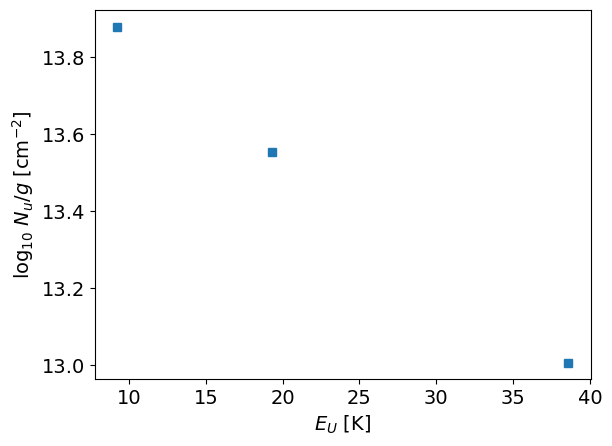

In [206]:
pl.plot((EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose(),
        np.log10((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value),
        's')
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");

In [207]:
from astropy import modeling
from astropy.modeling.models import custom_model

@custom_model
def model(eupper, logcolumn=np.log(1e13), tem=20):
    """
    Calculate the quantity N_u/g_u as a function of E_u in Kelvin

    The 'logcolumn' quantity is N_tot / Q_tot

    Temperature is the excitation temperature
    """

    result = -1/tem * eupper + logcolumn

    return result
fitter = modeling.fitting.LevMarLSQFitter()

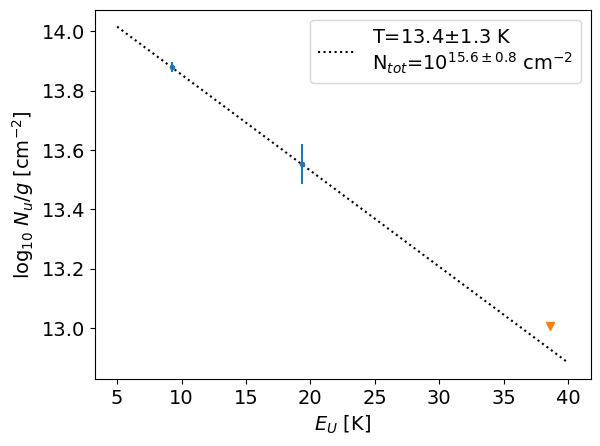

In [208]:
xvals = (EU_SO[[ind_SO3221, ind_SO2211,]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
errors = np.log((u.Quantity([enup_so32, enup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
fracerrors = ((u.Quantity([enup_so32/nup_so32, enup_so22/nup_so22])).value)
rslt = fitter(model(), xvals, yvals, weights=1/(fracerrors))

pl.errorbar(xvals,
            yvals * np.log10(np.exp(1)),
            yerr=fracerrors,
            linestyle='none',
            marker='.')

# plot 4544 but don't include in fit
xvals = (EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value)
pl.plot(xvals[2:],
        yvals[2:] * np.log10(np.exp(1)),
        'v')
elogcol = fitter.fit_info["cov_x"][0,0]**0.5
ecol = np.log10(np.exp(elogcol))*partfunc_SO(rslt.tem) # not sure this is right...
pl.plot(np.linspace(5, 40), rslt(np.linspace(5, 40)) * np.log10(np.exp(1)),
        label=f'T={rslt.tem.value:0.1f}$\pm${fitter.fit_info["cov_x"][1,1]**0.5:0.1f} K\n'
              f'N$_{{tot}}$=$10^{{{np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem)):0.1f}\pm{ecol:0.1f}}} $ cm$^{{-2}}$',
        color='k',
        linestyle=':',
        zorder=-5,
        )
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");
pl.legend(loc='best');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit.pdf", bbox_inches='tight')

In [209]:
rslt.tem, rslt.logcolumn

(Parameter('tem', value=13.413666368478774),
 Parameter('logcolumn', value=32.64606395604551))

In [210]:
rslt.param_names

('logcolumn', 'tem')

In [211]:
rslt.cov_matrix

In [212]:
fitter.fit_info['cov_x']**0.5

invalid value encountered in sqrt


array([[0.06989629,        nan],
       [       nan, 1.25355824]])

In [213]:
fitter.fit_info

{'nfev': 19,
 'fvec': array([-6.30633837e-12, -3.17064508e-12]),
 'fjac': array([[-62.93374976,   0.23247378],
        [ -3.41720159,  -0.79772919]]),
 'ipvt': array([1, 2], dtype=int32),
 'qtf': array([-5.59043782e-08, -1.30506490e-08]),
 'message': 'The relative error between two consecutive iterates is at most 0.000000',
 'ierr': 2,
 'param_jac': None,
 'param_cov': None,
 'cov_x': array([[ 0.00488549, -0.08532495],
        [-0.08532495,  1.57140827]])}

In [214]:
log10col_SO = np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem))
log10col_SO

15.589637098421601

In [215]:
f'{10**log10col_SO:0.3e}'

'3.887e+15'

In [216]:
f'{np.exp(rslt.logcolumn):0.3e}'

'1.507e+14'

## Model SO and CS

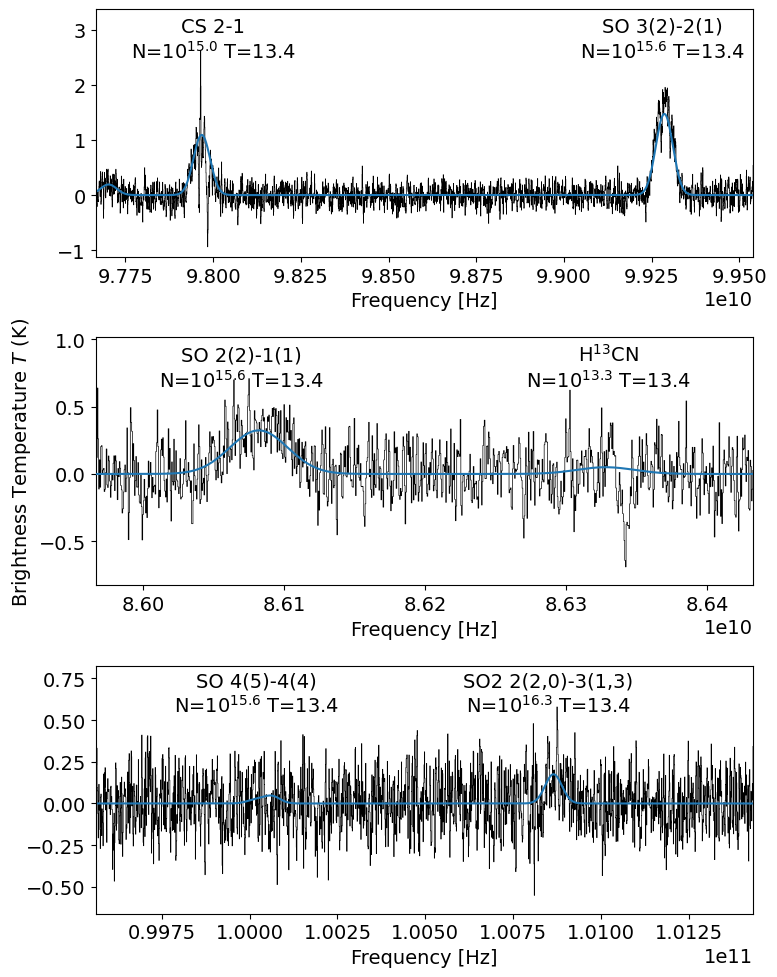

In [217]:
tex = rslt.tem * u.K
column_SO = (10**log10col_SO)*u.cm**-2
column_SO2 = 2e16*u.cm**-2
column_34SO = column_SO/8
column_CS = 1e15*u.cm**-2
column_H13CN = 2e13*u.cm**-2
column_H13COp = 2e13*u.cm**-2
column_SiO = 2e13*u.cm**-2
column_HC15N = 2e13*u.cm**-2
column_HC3N = 5e13*u.cm**-2

# SMOOTH VERSION BELOW IS PREFERRED (more model stuff)
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 +  mod_h13cn)


spw33.xarr.convert_to_unit(u.Hz)

fig = pl.figure(figsize=(8, 10))
spw33.plotter(axis=pl.subplot(3,1,1))
spw33.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 2.5, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 2.5, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
spw25.plotter(axis=pl.subplot(3,1,2))
spw25.plotter.axis.plot(spw25.xarr.value, sospw25mod, zorder=5)
#L1, = spw25.plotter.axis.plot(spw25.xarr.value, mod_so22)
#L2, = spw25.plotter.axis.plot(spw25.xarr.value, mod_h13cn)
pl.text(86.07e9, 0.65, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.65, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
                            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N) +    
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35.plotter(axis=pl.subplot(3,1,3))
spw35.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.55, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.55, f"SO2 2(2,0)-3(1,3)\nN=10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.tight_layout()
fig.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit.pdf", bbox_inches='tight')

### Smooth version

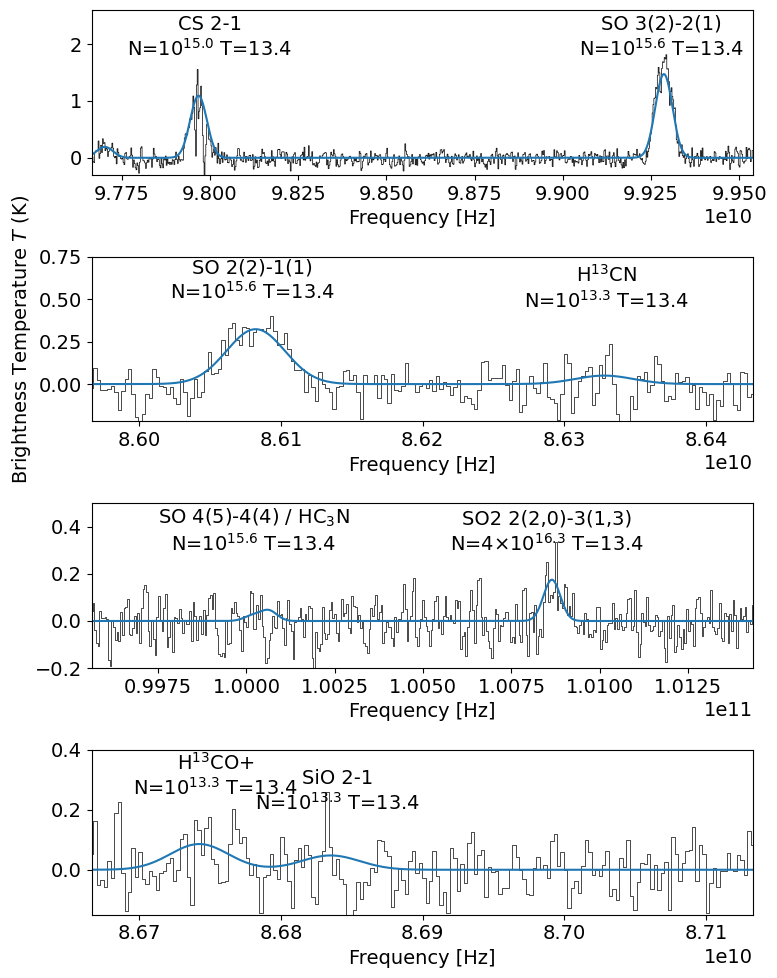

In [218]:
# smooth version, with contsub
spw33sm = spw33.copy()
spw33sm.smooth(5)
spw33sm.data -= np.median(spw33sm.data)
spw35sm = spw35.copy()
spw35sm.smooth(5)
spw35sm.data -= np.median(spw35sm.data)
spw25sm = spw25.copy()
spw25sm.smooth(5)
spw25sm.data -= np.median(spw25sm.data)
spw27sm = spw27.copy()
spw27sm.smooth(5)
spw27sm.data -= np.median(spw27sm.data)


# we're labeling lines, we don't want velocity units
spw33sm.xarr.convert_to_unit(u.Hz)
spw35sm.xarr.convert_to_unit(u.Hz)
spw25sm.xarr.convert_to_unit(u.Hz)
spw33.xarr.convert_to_unit(u.Hz)
spw35.xarr.convert_to_unit(u.Hz)
spw25.xarr.convert_to_unit(u.Hz)

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 + mod_h13cn + 
              lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO)
             )


sospw27mod = (lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SiO,
                            freqs=freqs_SiO, aij=aij_SiO, deg=deg_SiO, EU=EU_SiO, partfunc=partfunc_SiO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC15N,
                            freqs=freqs_HC15N, aij=aij_HC15N, deg=deg_HC15N, EU=EU_HC15N, partfunc=partfunc_HC15N) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )

pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(4,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 1.8, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.8, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.3,2.6)

spw25sm.plotter(axis=pl.subplot(4,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.text(86.08e9, 0.50, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.45, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.22, 0.75)
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
                            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35sm.plotter(axis=pl.subplot(4,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4) / HC$_3$N\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.10e9, 0.2, f"HC$_3$N 11-10\nN=4$\\times$10$^{{{np.log10(column_HC3N.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.2, 0.5)

spw27sm.plotter(axis=pl.subplot(4,1,4))
spw27sm.plotter.axis.plot(spw27.xarr.value, sospw27mod)
pl.text(86.84e9, 0.2, f"SiO 2-1\nN=10$^{{{np.log10(column_SiO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(86.754e9, 0.25, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
# HN13C pl.text(86.754, 0.2, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.15, 0.4)

pl.tight_layout()
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit_smoothed.pdf", bbox_inches='tight')

### SO 3-2 / 2-1 line ratio vs. temperature

In [219]:
meastable

<Table length=8>
       Line       Rest Frequency              Amplitude / Error                           Center / Error             ...  $\sigma_{v,cen}$     Width [vel]     $\sigma_{\sigma_v}$       Species       
                        Hz                            K                                         Hz                   ...       km / s             km / s              km / s                           
      str17          float64                      float64[2]                                float64[2]               ...      float64            float64             float64              str20        
----------------- -------------- ------------------------------------------- --------------------------------------- ... ------------------ ------------------ ------------------- --------------------
           CS 2-1  97980950000.0   1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 ...   3.06848704281292  69.86299227186738  2.8266483217816205               CS 2-1
           SO 3-2  99299870000.0   1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 ... 1.1059557738274437  66.43934639033277  1.0599924162957055               SO 3-2
         34SO 3-2  97715317000.0 0.21635256073961096 .. 0.023914645461206262    97703940084.093 .. 2603077.087169318 ...  7.986290197738089 62.359767879096374   8.352039733312695        $^{34}$SO 3-2
     SO 2(2)-1(1)  86093950000.0  0.3828433596099744 .. 0.026167578249070324  86082902388.39632 .. 1536167.511113989 ...  5.349173014556831  67.77755515045868   5.349172981667376         SO 2(2)-1(1)
SO2 2(2,0)-3(1,3) 100878105000.0 0.17151400547254475 .. 0.028675486287036096 100874782755.89418 .. 4796354.816369068 ... 14.253945391216671  73.82811000515491  14.253945285804658 SO$_2$ 2(2,0)-3(1,3)
         C34S 2-1  96412951000.0  0.13853527520451572 .. 0.02137043261956888  96396623397.53908 .. 3400937.958181477 ... 10.575089128728424  59.36646510185304  10.575089134905047        C$^{34}$S 2-1
    CS 2-1 (2012)  97980950000.0    0.538483824315997 .. 0.02748337250869406  97967649265.22664 .. 1142176.976084657 ...  3.494720587332808  67.35358672034356   3.273608958511121        CS 2-1 (2012)
  34SO 3-2 (2012)  97715317000.0 0.12926819946106832 .. 0.014652913600035832   97697448799.6016 .. 3058414.059952523 ...  9.383272722892832  71.69682244972846   9.383272700324666 $^{34}$SO 3-2 (2012)

In [220]:
# fractional errors
meastable['Amplitude / Error'][:,1] / meastable['Amplitude / Error'][:,0]

<Column name='Amplitude / Error' dtype='float64' unit='K' length=8>
0.042613960523984126
0.016337324541055256
 0.11053553227867038
 0.06835061283478656
 0.16719034814697012
  0.1542598633309842
 0.05103843656511783
 0.11335280959373807

In [221]:
measured_so_line_ratio = (meastable.loc['SO 3-2']['Amplitude / Error'][0] / 
                          meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][0])
measured_so_line_ratio_error = (meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][1] /
                                meastable.loc['SO 2(2)-1(1)']['Amplitude / Error'][0]) * measured_so_line_ratio
measured_so_line_ratio, measured_so_line_ratio_error

(4.881386383075419, 0.33364575076658715)

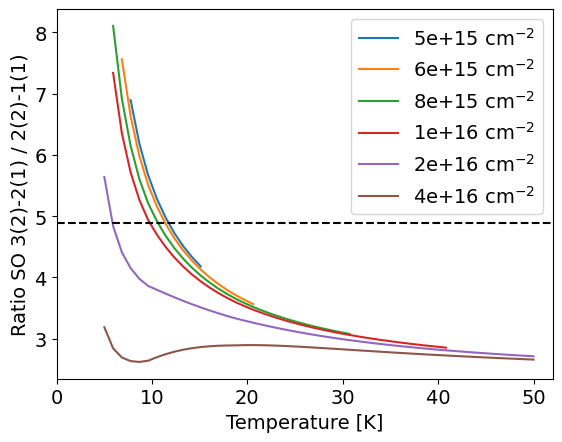

In [222]:
temperatures = np.linspace(5, 50)*u.K
for col_this in [5e15, 6e15, 8e15, 1e16, 2e16, 4e16]:
    so32ofT = [lte_molecule.generate_model(nurest_so32, 0*u.km/u.s, 71*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so21ofT = [lte_molecule.generate_model(nurest_so21, 0*u.km/u.s, 71*u.km/u.s, tex=T,
                                column=col_this, freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) 
               for T in temperatures]
    so32ofT = np.array(so32ofT)
    #pl.plot(temperatures, so21ofT)
    #pl.plot(temperatures, so32ofT)
    #L, = pl.plot(temperatures, np.array(so32ofT)/np.array(so21ofT), linestyle='--')
    pl.plot(temperatures[so32ofT > 1.75], (np.array(so32ofT)/np.array(so21ofT))[so32ofT > 1.75], linestyle='-',
            label=f'{col_this:0.0e} cm$^{{-2}}$')#, color=L.get_color())
pl.axhline(measured_so_line_ratio, linestyle='--', color='k')
pl.legend()
pl.xlabel('Temperature [K]')
pl.xlim(0, 52);
pl.ylabel("Ratio SO 3(2)-2(1) / 2(2)-1(1)");

pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_modeling_allowedparams.pdf", bbox_inches='tight')

### Check optical depth

Text(0.5, 1.0, 'optical depth of the models in spw33')

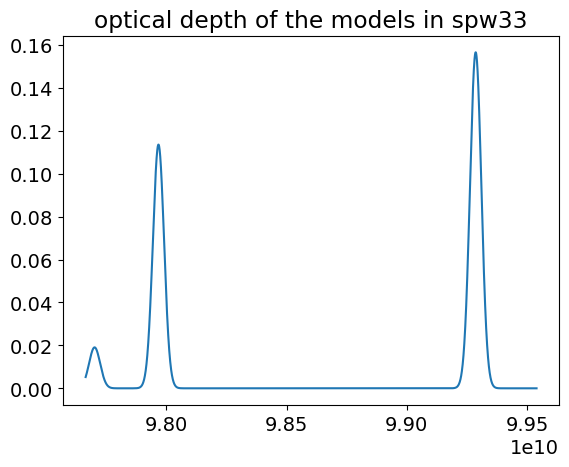

In [223]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                      freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                      freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus)
pl.title("optical depth of the models in spw33")

## Test filling factor limits

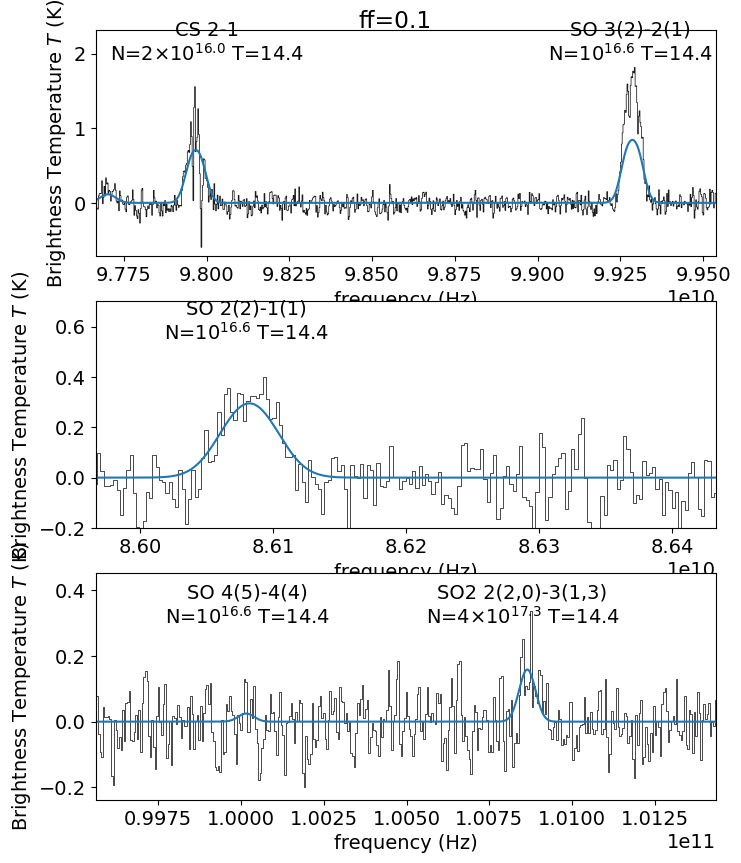

In [224]:
tex = 14.4 * u.K
ff = 0.1
column_SO = 10**15.6*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = 5e15/16*u.cm**-2 / ff
column_CS = 1e15*u.cm**-2 / ff

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             ) * ff
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) * ff
pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(3,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 1.9, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.9, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter(axis=pl.subplot(3,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.2, 0.7)

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
spw35sm.plotter(axis=pl.subplot(3,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.suptitle(y=0.9, t=f"ff={ff}");

## CH3SH search in spw35

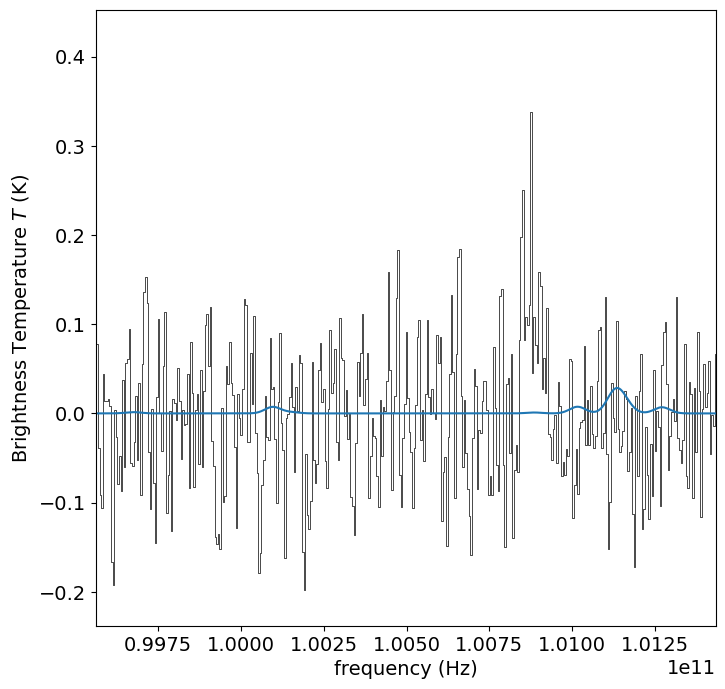

In [225]:
tex = 20 * u.K
column_CH3SH = 2e14*u.cm**-2
sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CH3SH,
                            freqs=freqs_CH3SH, aij=aij_CH3SH, deg=deg_CH3SH, EU=EU_CH3SH, partfunc=partfunc_CH3SH) 
             )
pl.figure(figsize=(8, 8))
spw35sm.plotter(axis=pl.subplot(1,1,1))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)

## Demonstrate temperature limits from SO

Text(0.5, 0.98, 'T=60K is inconsistent with the SO line ratio')

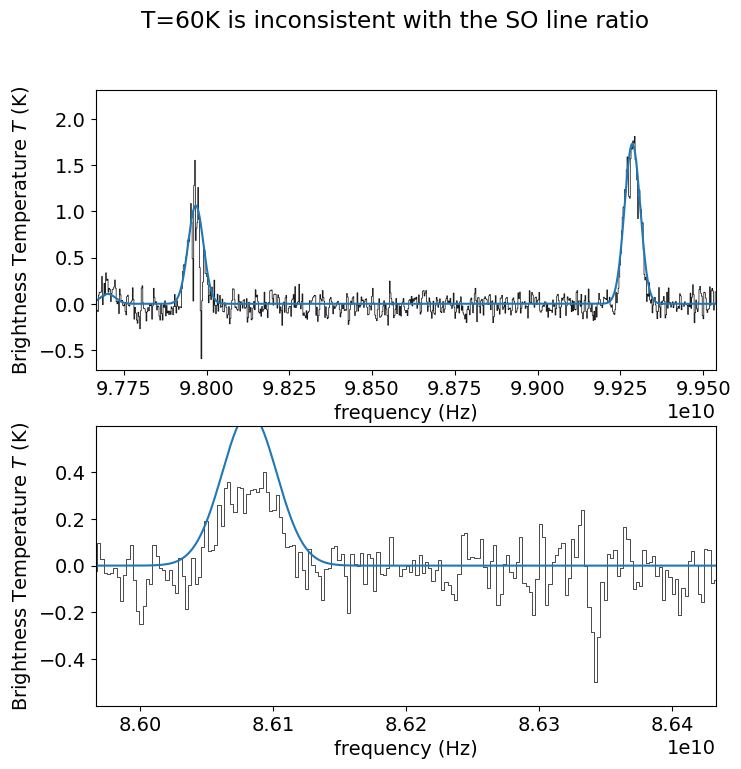

In [226]:
tex = 60 * u.K
column_SO = 1.4e16*u.cm**-2
column_CS = 2.5e15*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=60K is inconsistent with the SO line ratio")

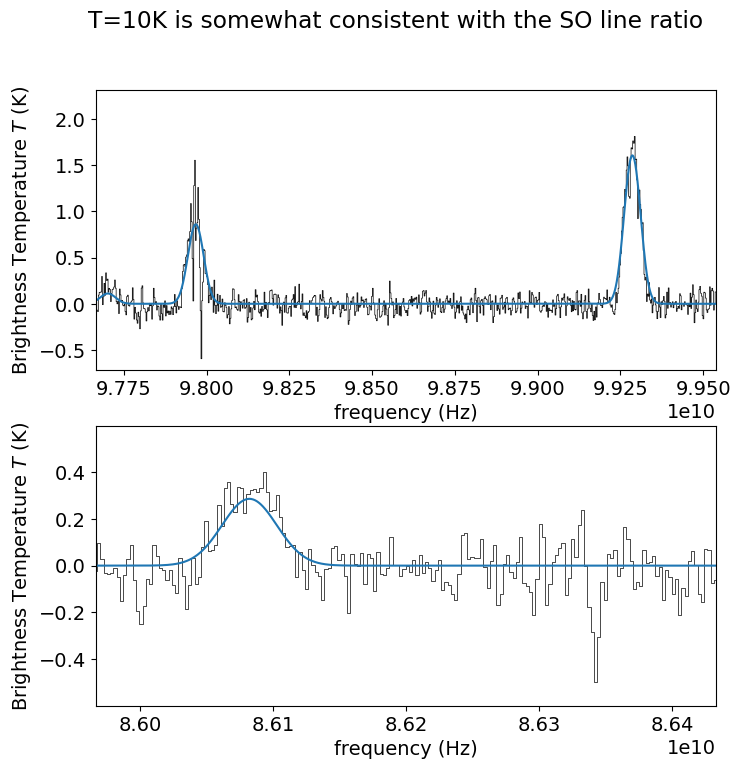

In [227]:
tex = 10 * u.K
column_SO = 50*8e13*u.cm**-2
column_CS = 50*1.5e13*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=10K is somewhat consistent with the SO line ratio");

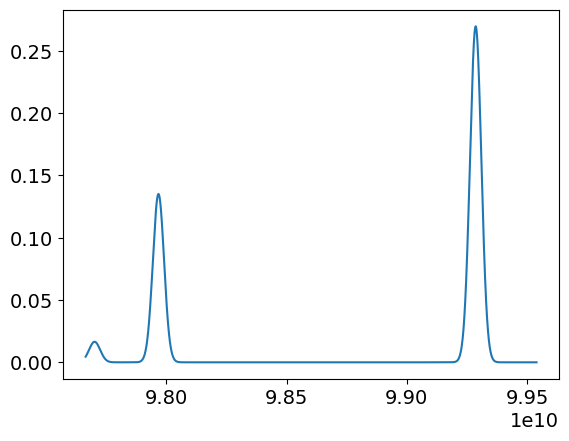

In [228]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus);

# splatalogue: check for a line at th ebottom of spw33?

In [229]:
Splatalogue.query_lines(97.7095 *u.GHz, 97.8 * u.GHz, energy_max=50, energy_type='eu_k',)[:2]

<Table length=2>
species_id         name            chemical_name              resolved_QNs         ... transitionBandColor searchErrorMessage sqlquery
  int64           str73                str37                     str60             ...        str16               str1         object 
---------- ------------------- ---------------------- ---------------------------- ... ------------------- ------------------ --------
     21078 gGG'g-CH2OHCH2CH2OH 1,3-propanediol, gGG'g 13(4,10) - 12(3,9), v= 0 - 0 ...    datatableskyblue                        None
     21078 gGG'g-CH2OHCH2CH2OH 1,3-propanediol, gGG'g 13(4,10) - 12(3,9), v= 1 - 1 ...    datatableskyblue                        None

In [230]:
Splatalogue.query_lines(97.7095 *u.GHz, 97.8 * u.GHz, energy_max=50, energy_type='eu_k',)['name',
  'chemical_name', 'orderedfreq', 'upper_state_energy_K', 'resolved_QNs', ].pprint(max_lines=500)

                                   name                                               chemical_name             orderedfreq upper_state_energy_K                         resolved_QNs                        
------------------------------------------------------------------------- ------------------------------------- ----------- -------------------- ------------------------------------------------------------
                                                      gGG'g-CH2OHCH2CH2OH                1,3-propanediol, gGG'g   97709.572             33.07617                                 13(4,10) - 12(3,9), v= 0 - 0
                                                      gGG'g-CH2OHCH2CH2OH                1,3-propanediol, gGG'g   97709.572             33.07804                                 13(4,10) - 12(3,9), v= 1 - 1
                                  CH<sub>3</sub>CHNH<sub>2</sub>COOH - II                       &alpha;-Alanine  97710.9153             21.75558                                

# Orbital velocity check
For a Keplerian orbit with width = 71 km/s, where could it be...?

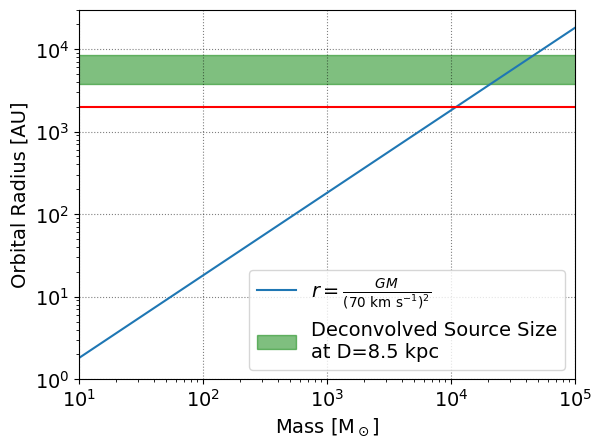

In [231]:
mass = np.geomspace(0.1, 1e5)*u.M_sun
#pl.title("Source size is roughly 1 arcsec ~ 8500 AU")
pl.loglog(mass, (constants.G * mass / (70*u.km/u.s)**2).to(u.au), label=r'$r = \frac{G M}{(70 \mathrm{~km~s}^{-1})^2}$')
pl.xlabel("Mass [M$_\odot$]")
pl.ylabel("Orbital Radius [AU]")
pl.axhline(2000, color='r')
#pl.axhline(8500);
#pl.axvline(1e4);
pl.grid(linestyle=':', color='k', zorder=-5, alpha=0.5)
xx = pl.xlim()
pl.fill_between(xx, 0.44*8500, 0.99*8500, alpha=0.5, color='g', label='Deconvolved Source Size\nat D=8.5 kpc');
pl.axis([10, 1e5, 1, 3e4])
pl.legend(loc='lower right');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/GMovervsquared.pdf", bbox_inches='tight')

### Temperature Model

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$

In [232]:
alpha = 0.001
sigma = 2.8e24*u.Da/u.cm**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*1e4*u.au))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose()

<Quantity 0.50141277 K>

In [233]:
# What if we say it's 2000 AU?

In [234]:
alpha = 0.001
radius = 2e3*u.au
# our total mass has to be concentrated into a smaller volume
sigma = 2.8e24*u.Da/u.cm**2 * (1e4*u.au/radius)**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*radius))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose(), sigma

(<Quantity 7.33069913 K>, <Quantity 7.e+25 u / cm2>)

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$
$$T_m = 7.3 \mathrm{~K~}
        \left[\frac{M}{50 \mathrm{M}_\odot}\right]^{2/3}
        \left[\frac{\kappa}{3 \mathrm{cm^2~g^{-1}}}\right]^{1/3}
        \left[\frac{\alpha}{10^{-3}}\right]^{1/3}
        \left[\frac{r}{2000 \mathrm{AU}}\right]^{-4/3}
        $$

### velocity profile model (disk)

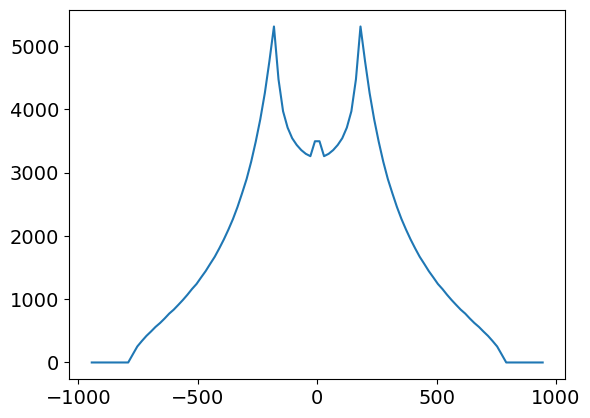

In [235]:
# super simple model of edge-on disk with a single radius
import numpy as np
def vee(rad, theta, mass, incl=90*u.deg):
    return np.sqrt(constants.G*mass / rad).to(u.km/u.s) * np.sin(theta) * np.sin(incl)
theta = np.linspace(0, 360, 360)*u.deg
rmin = 10*u.au
vees = vee(rmin, theta, 1e4*u.M_sun)
xarr = np.linspace(vees.min()-2*u.km/u.s, vees.max()+2*u.km/u.s, 100)
bins = np.linspace(vees.min()-2*u.km/u.s, vees.max()+2*u.km/u.s, 101)
spec = np.zeros_like(xarr)
mass = 1e4*u.M_sun
incl = 55*u.deg
for rad in np.geomspace(rmin, 200*u.au, 500):
    vees = vee(rad, theta, mass, incl=incl)
    spec_, _ = np.histogram(vees, bins=bins)
    spec += u.Quantity(spec_, u.km/u.s)
#bincen = (xarr[1:] + xarr[:-1])/2
pl.plot(xarr, spec)

# Overplot all the lines (to show nondetections)

In [236]:
import aces
linetb = Table.read(f'{aces.conf.basepath}/reduction_ACES/aces/data/tables/linelist.csv')
linetb.sort('col9')
spw_inds = {25: 0, 27:1, 29:2, 31:3, 33:4, 35: 5}
linetb[:3]

<Table length=3>
Band Name TP SPW 7m SPW 12m SPW  Center Bandwidth F_Lower F_Upper  F_Resolution col9         Line        Rest (GHz) V_Lower V_Upper  V_Res.   _1       References    
  str10   int64  int64   int64  float64  float64  float64 float64    float64    str3        str27         float64   float64 float64 float64 int64        str30       
--------- ------ ------ ------- ------- --------- ------- -------- ------------ ---- ------------------- ---------- ------- ------- ------- ----- -------------------
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    *  CH3SH  4(0)–3(0) E  101.13965      --      --    2.89    -- Jones et al. (2008)
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    *  CH3SH  4(0)–3(0) A  101.13916      --      --    2.89    -- Jones et al. (2008)
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    * NH2CN 5(1,4)-4(1,3)   100.6295      --      --    2.91    -- Jones et al. (2008)

In [237]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    all_spectra = {}
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            scube = (scubes[spw_inds[row['12m SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            all_spectra[row['Line']] = sp
            print(row['Line'], end=', ')

HN13C 1-0, H13CO+ 1-0, H40 Alpha, SiO 2-1, CH3C3N, H13CN 1-0, SiO 2-1 v=1 maser, SO 3(2)-2(1), HNCO 4-3, CS 2-1, HC3N 11-10, HCO+ 1-0, SO 4(5)-4(4), SO2 2(2,0)-3(1,3), SO 2(2)-1(1), CCS 7(6)-6(5), SO2 7(3,5)–8(2,6), 34SO  3(2)–2(1), 33SO, 

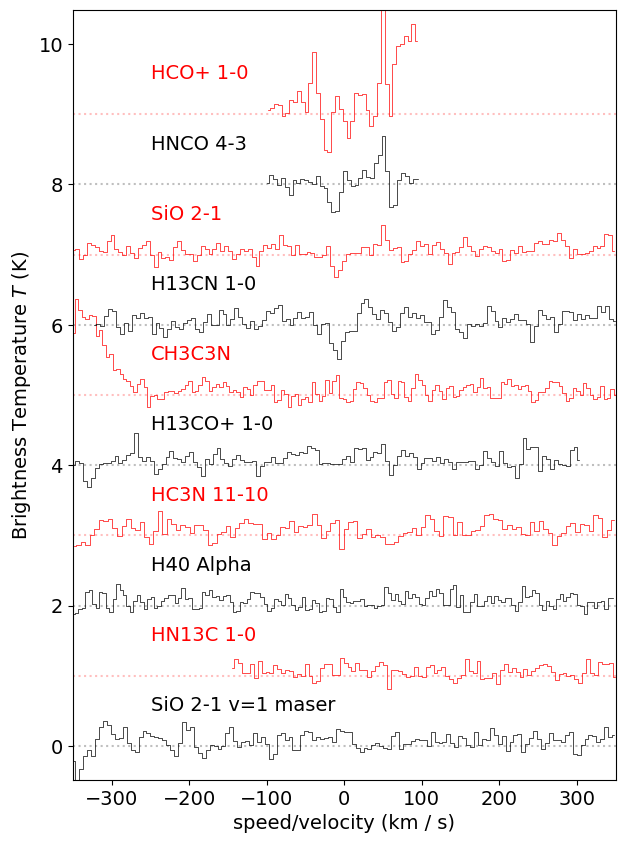

In [238]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k)]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays.pdf", bbox_inches='tight')

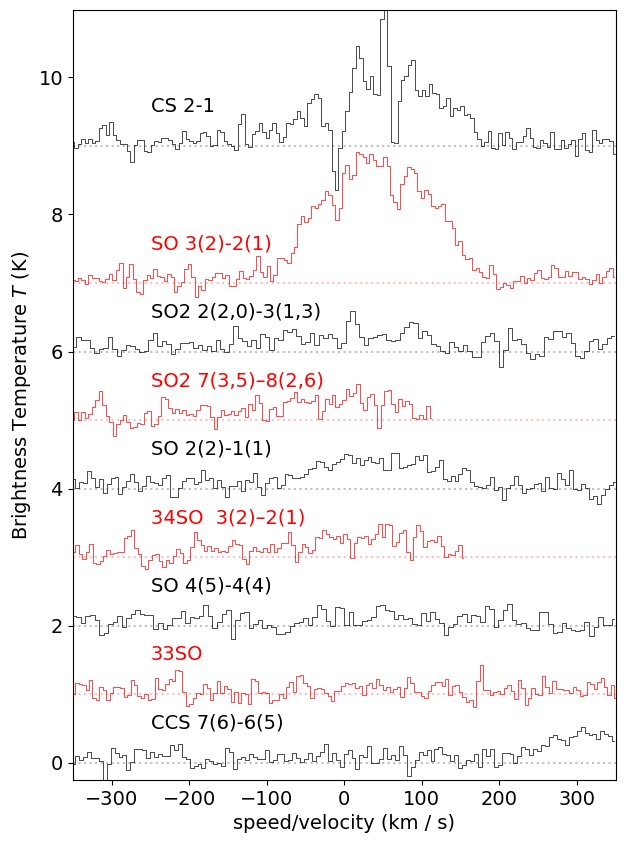

In [239]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays.pdf", bbox_inches='tight')

### CS cloud overlay

In [240]:
m0_cloud_4060 = cs_scube.spectral_slab(40*u.km/u.s, 60*u.km/u.s).moment0()
m0_cloud_4555 = cs_scube.spectral_slab(45*u.km/u.s, 55*u.km/u.s).moment0()

In [241]:
import reproject, reproject.mosaicking
reproject.mosaicking.find_optimal_celestial_wcs(m0_cloud_4060.hdu, frame='galactic')

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'GLON-TAN' 'GLAT-TAN' 
 CRVAL : 359.9988837198138 -0.08230253501374826 
 CRPIX : 397.0165955565129 -92.1270232756375 
 PC1_1 PC1_2  : 1.0 0.0 
 PC2_1 PC2_2  : 0.0 1.0 
 CDELT : -7.2222222222217e-05 7.2222222222217e-05 
 NAXIS : 0  0,
 (80, 80))

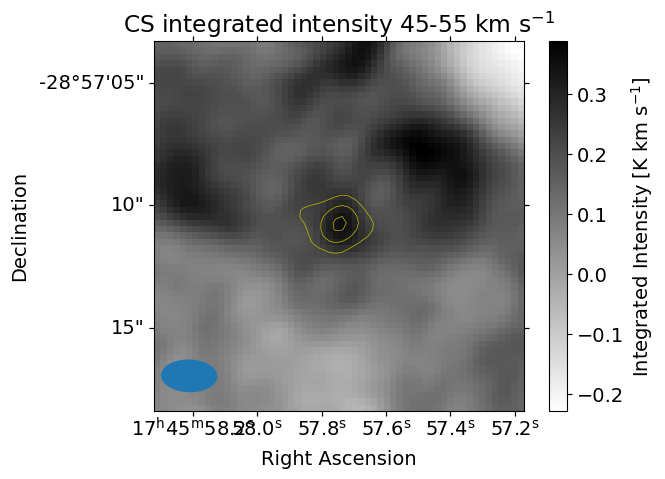

In [242]:

fig = pl.figure()
ax = pl.subplot(projection=m0_cloud_4555.wcs)
im = ax.imshow(m0_cloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")
ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));

overlay[1].set_ticklabel_position('l')


fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

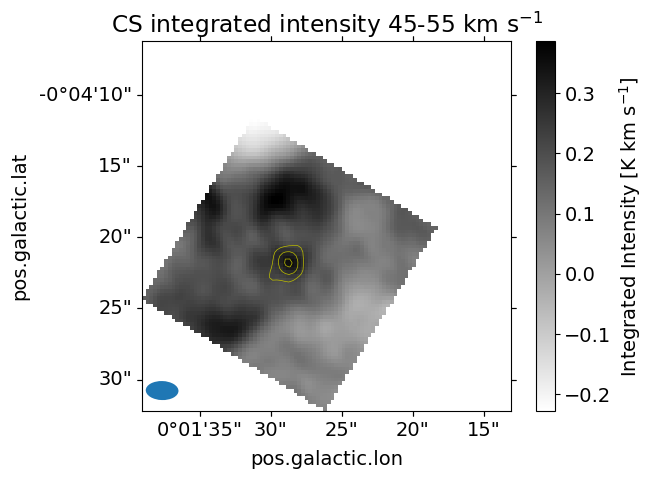

In [243]:
galwcs, outsz = reproject.mosaicking.find_optimal_celestial_wcs(m0_cloud_4555.hdu, frame='galactic')
repr, _ = reproject.reproject_interp(m0_cloud_4555.hdu, galwcs, shape_out=[100, 100])

fig = pl.figure()
ax = pl.subplot(projection=galwcs)
im = ax.imshow(repr, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
#ax.set_xlabel("Right Ascension")
#ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")
ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc_galactic.pdf', bbox_inches='tight')

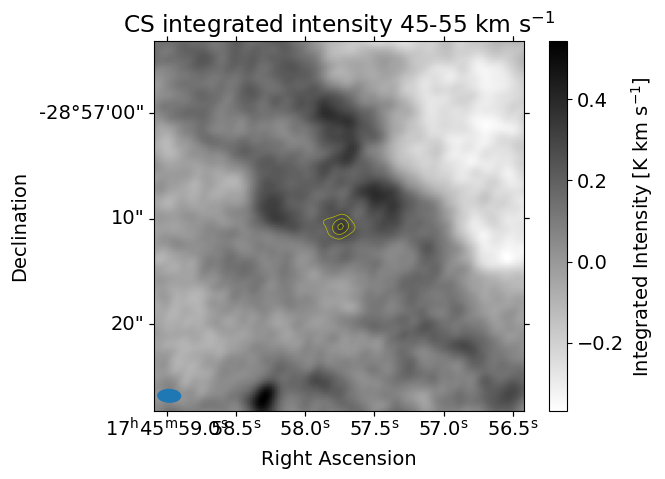

In [244]:
m0_bigcloud_4555 = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555.wcs)
im = ax.imshow(m0_bigcloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

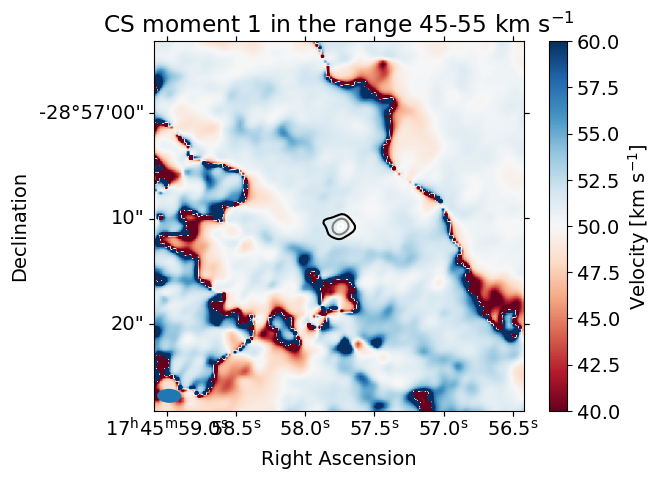

In [245]:
m1_bigcloud_4060 = (cubes[-2]
.subcube_from_regions([bigregion])
.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
.spectral_slab(45*u.km/u.s, 55*u.km/u.s)
).moment1()
fig = pl.figure()
ax = pl.subplot(projection=m1_bigcloud_4060.wcs)
im = ax.imshow(m1_bigcloud_4060.value, cmap='RdBu', vmin=40, vmax=60)
cb = pl.colorbar(mappable=im)
cb.set_label("Velocity [km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS moment 1 in the range 45-55 km s$^{-1}$");

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], cmap='gray', transform=ax.get_transform(m0_cs_ptsrc.wcs));

### TP Spectra


These are pretty much out of order in this notebook; this should get moved somewhere else

In [246]:
tpcubefns = sorted(glob.glob('/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X140/product/*.cube.I.sd.fits'))
tpcubes = [SpectralCube.read(fn) for fn in tpcubefns]

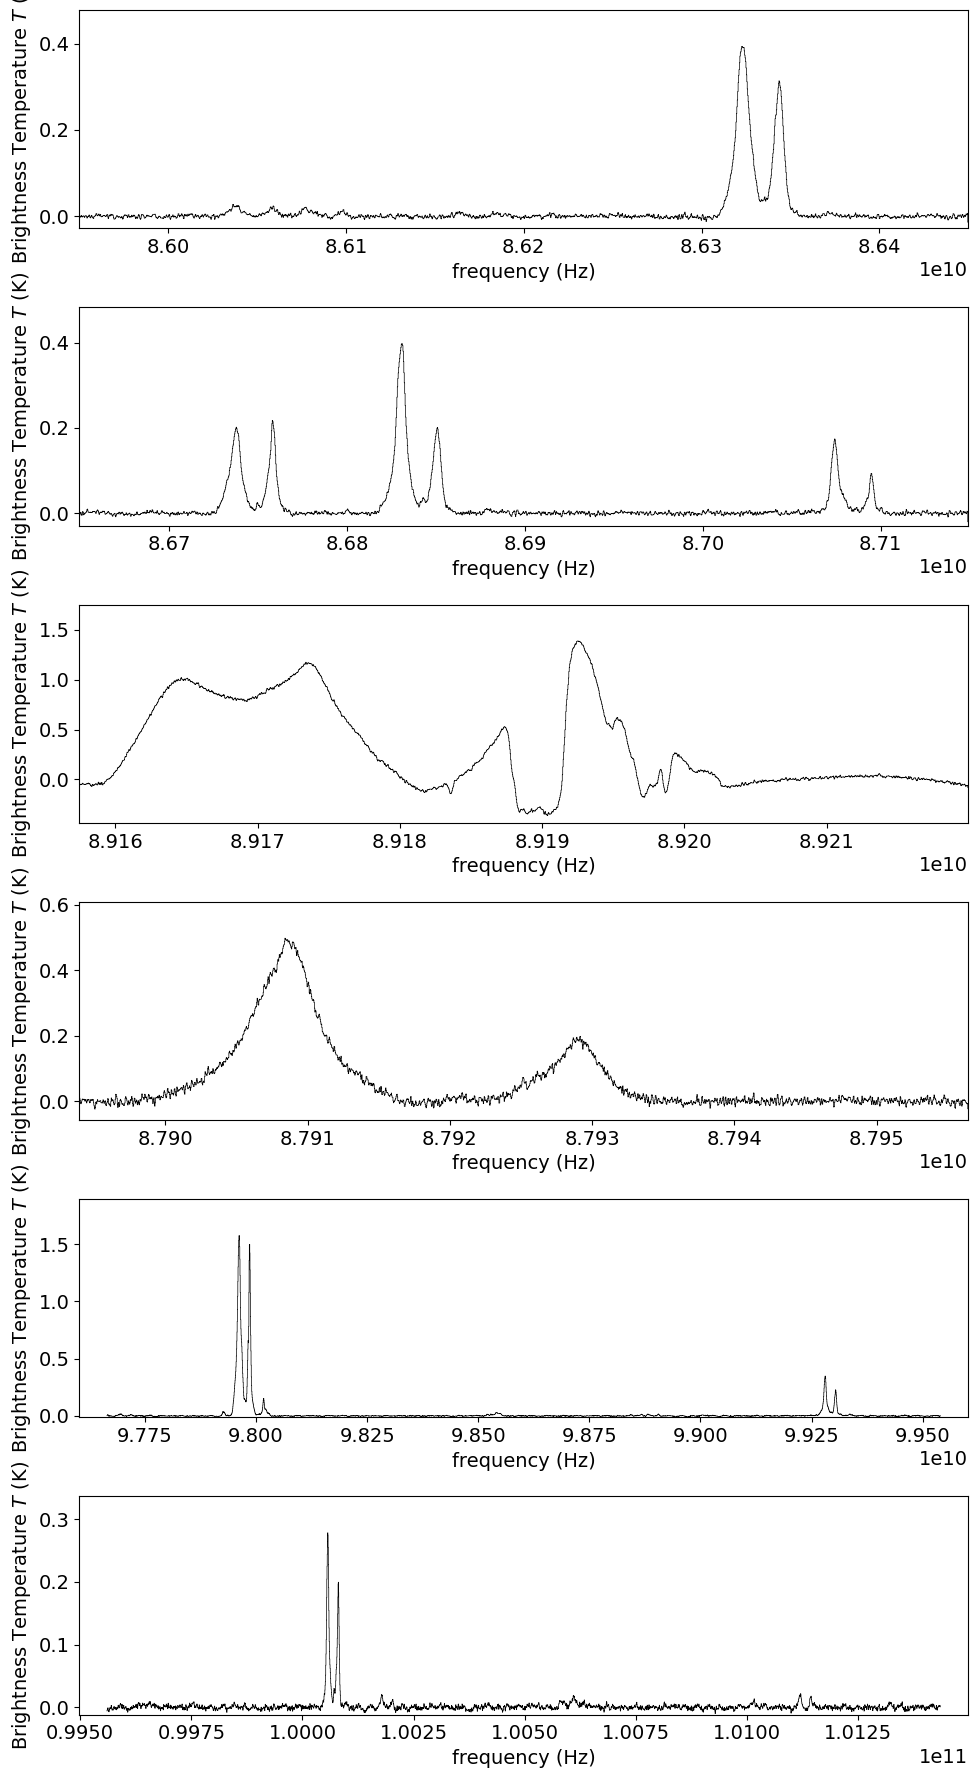

In [247]:
pl.figure(figsize=(10, 18))
for ii, cu in enumerate(tpcubes):
    xx, yy = cu.wcs.celestial.world_to_pixel(coord)
    sp_ = cu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=pl.subplot(6, 1, ii+1))
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
    if ii != 3:
        ax.set_ylabel("")
pl.tight_layout()

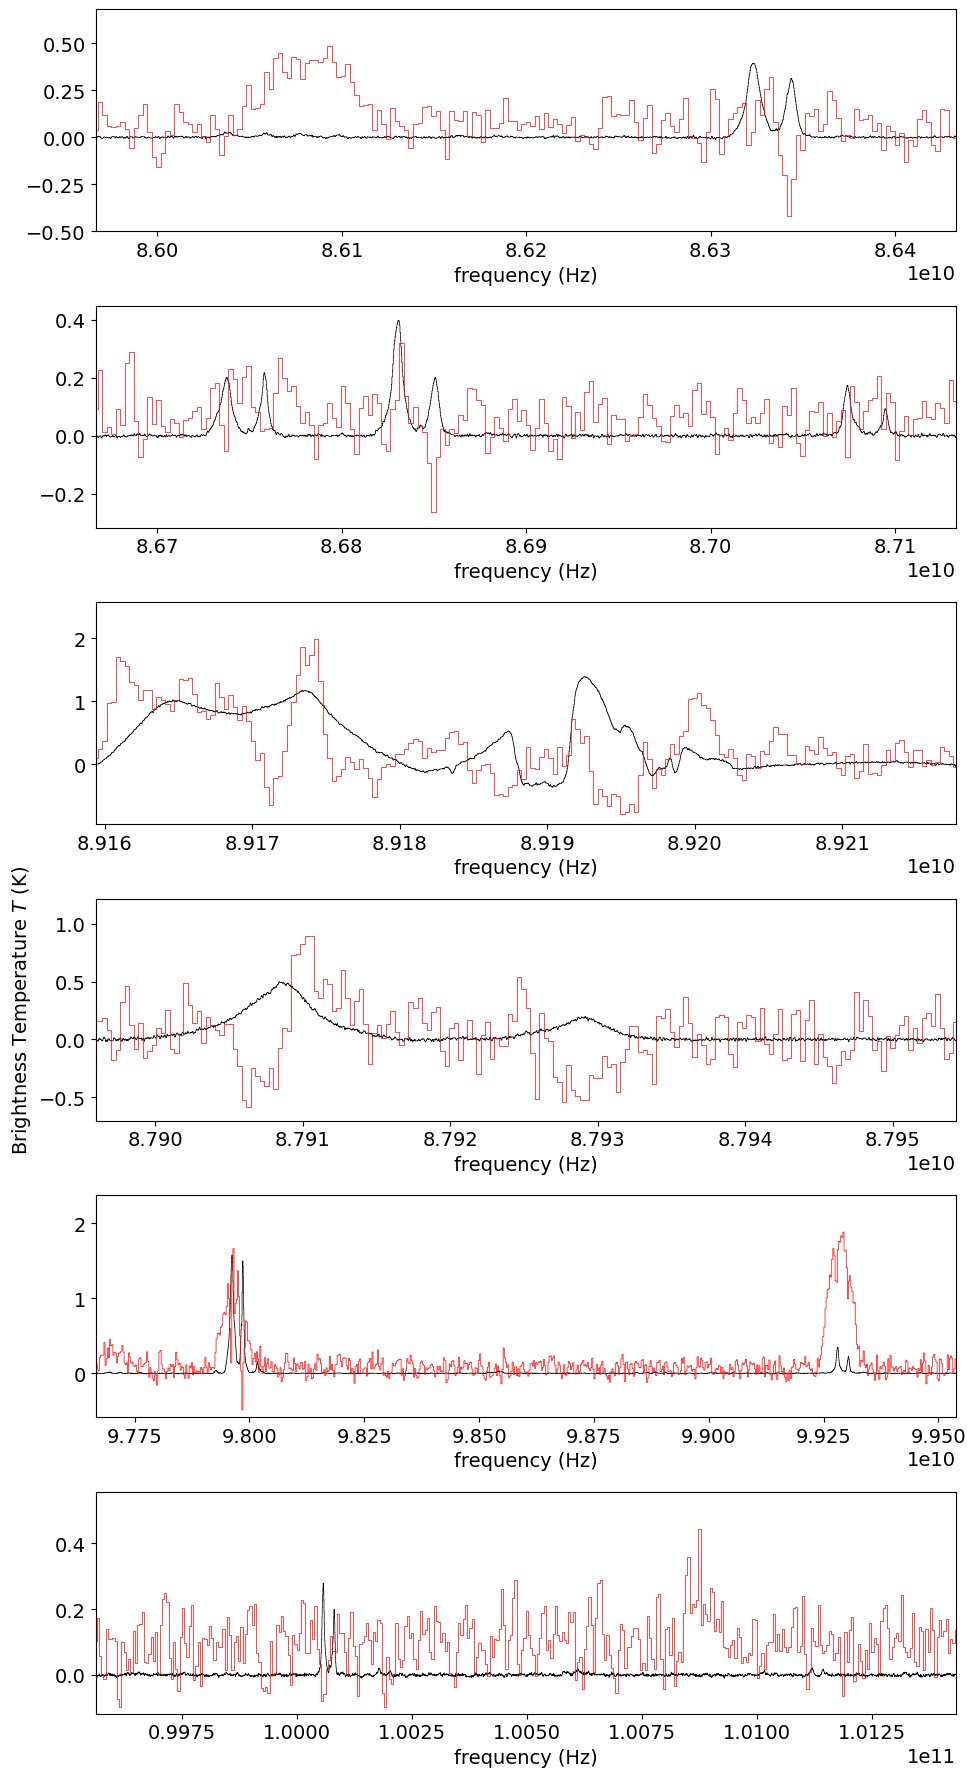

In [248]:
pl.figure(figsize=(10,18))
for ii, (tpcu, tmcu)  in enumerate(zip(tpcubes, cubes)):
    ax = pl.subplot(6, 1, ii+1)
    
    xx, yy = tpcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tpcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=ax)
    
    xx, yy = tmcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tmcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.smooth(5)
    sp.plotter(axis=ax, clear=False, color='r')
    if ii != 3:
        ax.set_ylabel("")
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
pl.tight_layout()

#### with TP

In [249]:
spw_inds_tp = {17: 0, 19: 1, 21: 2, 23: 3, 25: 4, 27: 5}

In [250]:
all_spectra_tp = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            scube = (tpcubes[spw_inds_tp[row['TP SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            #sp.smooth(smfac, downsample=True)
            all_spectra_tp[row['Line']] = sp
            print(row['Line'], end=', ')

HN13C 1-0, H13CO+ 1-0, H40 Alpha, SiO 2-1, CH3C3N, H13CN 1-0, SiO 2-1 v=1 maser, SO 3(2)-2(1), HNCO 4-3, CS 2-1, HC3N 11-10, HCO+ 1-0, SO 4(5)-4(4), SO2 2(2,0)-3(1,3), SO 2(2)-1(1), CCS 7(6)-6(5), SO2 7(3,5)–8(2,6), 34SO  3(2)–2(1), 33SO, 

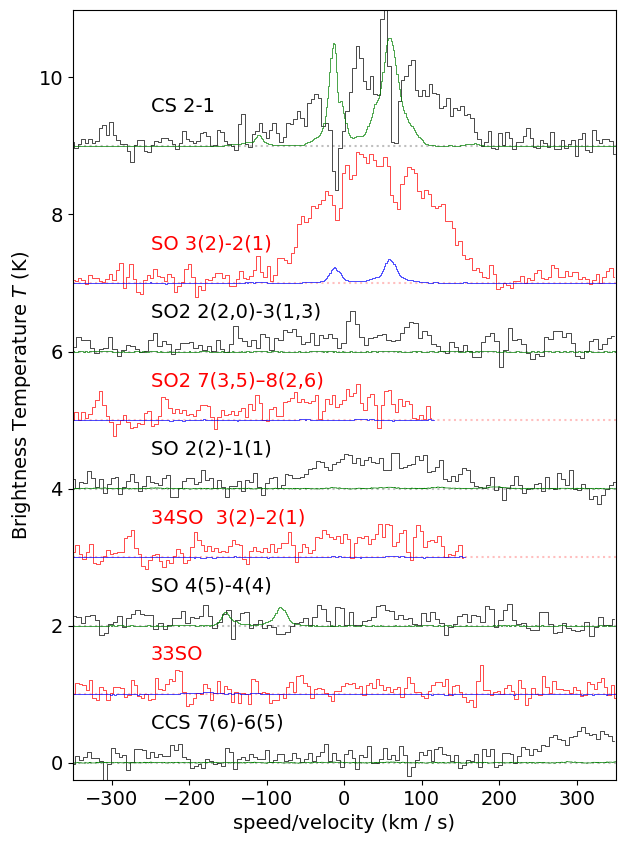

In [251]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    #ax.text(-250, offset + 0.5, linename, color='b' if ii%2 == 1 else 'g')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays_withTP.pdf", bbox_inches='tight')

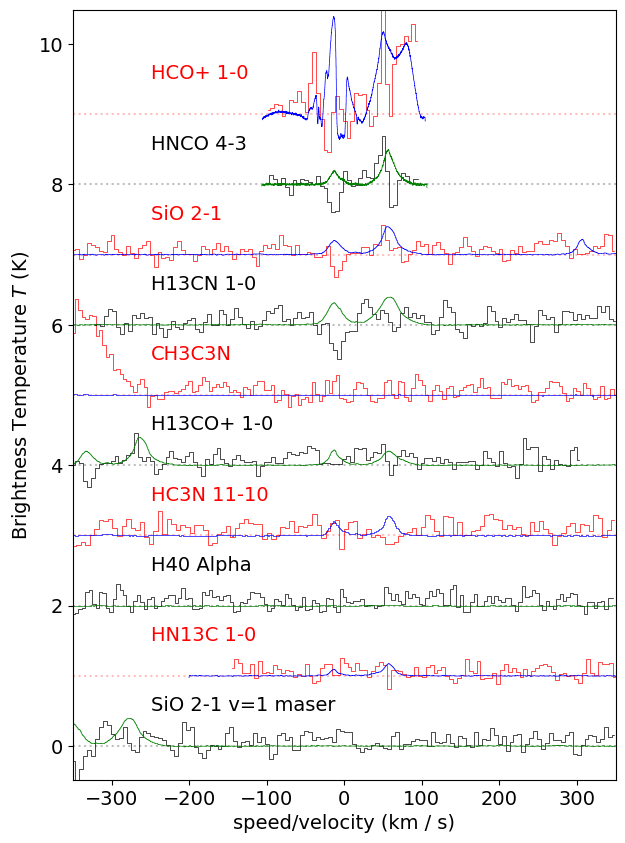

In [252]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k)]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays_withTP.pdf", bbox_inches='tight')

## Do the same for Betsy's data

In [253]:
ls /orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*image.pbcor -d

/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.mfs.I.manual.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_4_8_12.cube.I.manual.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud.spw0.contsub.cube.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud.spw1.cube.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/

In [254]:
fns_2017 = glob.glob("/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*cube*image.pbcor")
scubes2017 = [SpectralCube.read(fn, format='casa_image').subcube_from_regions([region]) for fn in fns_2017]

divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars


In [255]:
import imp
import astroquery.splatalogue, astroquery.splatalogue.core
imp.reload(astroquery.splatalogue.core)
imp.reload(astroquery.splatalogue)
from astroquery.splatalogue.core import Splatalogue
import astroquery.splatalogue
from astroquery import splatalogue;

the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses


In [256]:
scubes2017[1].find_lines(chemical_name=' SO ')

<Table length=6>
species_id                          name                          chemical_name        resolved_QNs      ... transitionBandColor searchErrorMessage sqlquery
  int64                            str53                              str15               str23          ...        str18               str1         object 
---------- ----------------------------------------------------- --------------- ----------------------- ... ------------------- ------------------ --------
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide            8( 8)- 7( 7) ...  datatablepalegreen                        None
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide            8( 8)- 7( 7) ...  datatablepalegreen                        None
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide               8(8)-7(7) ...  datatablepalegreen                        None
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide       8(  8    )- 7( 7) ...  datatablepalegreen                        None
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide            2( 3)- 2( 1) ...  datatablepalegreen                        None
       279 SO <font color="red"><sup>3</sup>&Sigma; v = 0</font> Sulfur Monoxide            2( 3)- 2( 1) ...  datatablepalegreen                        None

In [257]:
b7beam = scubes2017[0].beam
b7beam

Beam: BMAJ=4.741114054051525 arcsec BMIN=2.600191448624252 arcsec BPA=-85.31893012166081 deg

In [258]:
from astropy import table

In [259]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
            for cu in scubes2017 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
    tabs = [minimize_table(t, columns=('name', 'chemical_name', 'resolved_QNs', 'orderedfreq', 'upper_state_energy_K'), merge=False)
            for t in tabs if len(t) > 0]
b7linetable = table.vstack(tabs)
b7linetable['Freq'] = (b7linetable['orderedfreq']*u.MHz).to(u.GHz)
b7linetable['Species'] = b7linetable['chemical_name']
b7linetable['QNs'] = b7linetable['resolved_QNs']
b7linetable = b7linetable[b7linetable['upper_state_energy_K'] < 100]
b7linetable

<Table length=15>
                         name                           chemical_name        resolved_QNs    orderedfreq upper_state_energy_K        Freq             Species               QNs        
                                                                                                                                     GHz                                               
                        str53                               str18               str19          float64         float64             float64             str18               str19       
----------------------------------------------------- ------------------ ------------------- ----------- -------------------- ------------------ ------------------ -------------------
SO <font color="red"><sup>3</sup>&Sigma; v = 0</font>    Sulfur Monoxide        8( 8)- 7( 7)  344310.612             87.48155 344.31061200000005    Sulfur Monoxide        8( 8)- 7( 7)
SO <font color="red"><sup>3</sup>&Sigma; v = 0</font>    Sulfur Monoxide        2( 3)- 2( 1) 345704.4744             21.05114 345.70447440000004    Sulfur Monoxide        2( 3)- 2( 1)
                    CO <font color="red">v = 0</font>    Carbon Monoxide                 3-2 345795.9899             33.19169        345.7959899    Carbon Monoxide                 3-2
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  5( 5, 1)- 6( 4, 2) 345148.9708             75.14405 345.14897080000003     Sulfur dioxide  5( 5, 1)- 6( 4, 2)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide 13( 2,12)-12( 1,11) 345338.5377             92.98367        345.3385377     Sulfur dioxide 13( 2,12)-12( 1,11)
                                      <sup>34</sup>SO    Sulfur Monoxide        6( 7)- 7( 6) 356868.6927             63.83839        356.8686927    Sulfur Monoxide        6( 7)- 7( 6)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide 10( 4, 6)-10( 3, 7) 356755.1899             89.83365        356.7551899     Sulfur dioxide 10( 4, 6)-10( 3, 7)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide 11( 4, 8)-11( 3, 9) 357387.5795             99.95222        357.3875795     Sulfur dioxide 11( 4, 8)-11( 3, 9)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  8( 4, 4)- 8( 3, 5) 357581.4486             72.36335        357.5814486     Sulfur dioxide  8( 4, 4)- 8( 3, 5)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  9( 4, 6)- 9( 3, 7) 357671.8206             80.63687        357.6718206     Sulfur dioxide  9( 4, 6)- 9( 3, 7)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  7( 4, 4)- 7( 3, 5) 357892.4422             65.01106        357.8924422     Sulfur dioxide  7( 4, 4)- 7( 3, 5)
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  6( 4, 2)- 6( 3, 3) 357925.8478             58.57964        357.9258478     Sulfur dioxide  6( 4, 2)- 6( 3, 3)
                                      <sup>34</sup>SO    Sulfur Monoxide        2( 3)- 2( 1) 343851.1297             20.90551        343.8511297    Sulfur Monoxide        2( 3)- 2( 1)
                   CS <font color="red">v = 0 </font> Carbon Monosulfide                7- 6 342882.8503             65.82732        342.8828503 Carbon Monosulfide                7- 6
                   CS <font color="red">v = 0 </font> Carbon Monosulfide                7- 6 342882.8503             65.82732        342.8828503 Carbon Monosulfide                7- 6

In [260]:
rename_map = {"Carbon Monosulfide": 'CS',
              'Sulfur Monoxide': 'SO',
              '34Sulfur Monoxide': '$^{34}$SO',
              '34Carbon Monosulfide': 'C$^{34}$S',
              'Silicon Monoxide': 'SiO',
              'Carbon Monoxide': 'CO',
              'Sulfur dioxide': 'SO$_2$',
             }

In [261]:
all_spectra_b7 = {}

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b7linetable:
        for cube in scubes2017:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            try:
                sp.smooth(smfac, downsample=True)
            except TypeError:
                #edge of window / yspeckit bug
                continue
            line = f"{rename_map[row['Species']]} {row['QNs'].replace(' ','')}"
            all_spectra_b7[line] = sp
            print(line, end=', ')

SO 8(8)-7(7), SO 8(8)-7(7), SO 2(3)-2(1), CO 3-2, SO$_2$ 5(5,1)-6(4,2), SO$_2$ 13(2,12)-12(1,11), SO 6(7)-7(6), SO$_2$ 10(4,6)-10(3,7), SO$_2$ 11(4,8)-11(3,9), SO$_2$ 8(4,4)-8(3,5), SO$_2$ 9(4,6)-9(3,7), SO$_2$ 7(4,4)-7(3,5), SO$_2$ 6(4,2)-6(3,3), SO 2(3)-2(1), SO 2(3)-2(1), CS 7-6, CS 7-6, 

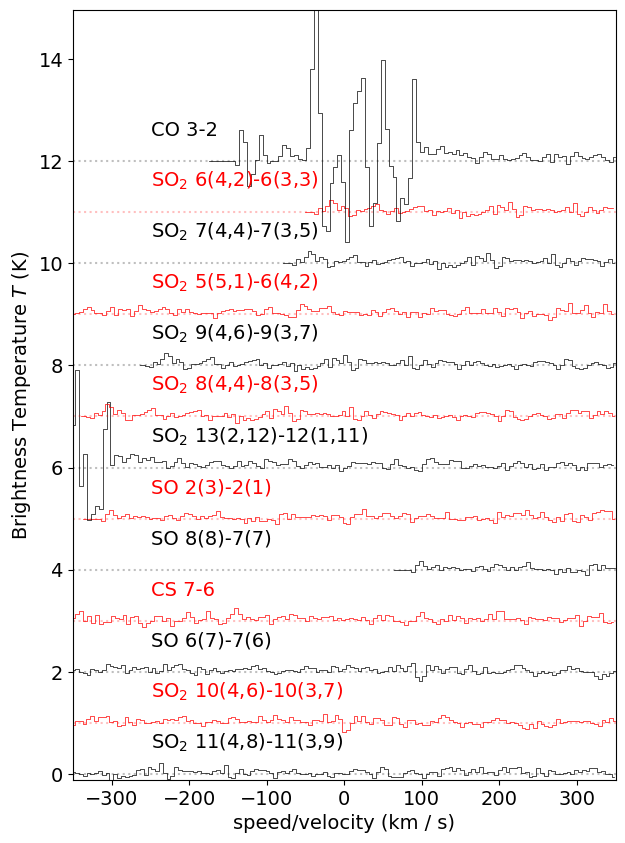

In [262]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b7, key=lambda x: all_spectra_b7[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra_b7[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_spectra_overlays.pdf", bbox_inches='tight')

## Do the same for Tsuboi's data

In [263]:
ls /orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/

casa-20231231-184029.log
casa-20240101-165736.log
casa-20240107-133831.log
casa-20240107-211347.log
casa-20240109-021504.log
casa-20240111-023402.log
casa-20240113-170013.log
casa-20240113-170739.log
casa-20240114-135112.log
casa-20240128-224210.log
casa-20240130-021859.log
casa-20240130-032337.log
exportfits.last
GC50MC_continuum_r-2.convmodel/
GC50MC_continuum_r-2.mask/
GC50MC_continuum_r-2.model/
GC50MC_continuum_r-2.partial.image/
GC50MC_continuum_r-2.partial.image.fits
GC50MC_continuum_r-2.partial.image.pbcor/
GC50MC_continuum_r-2.partial.image.pbcor.fits
GC50MC_continuum_r-2.pb/
GC50MC_continuum_r-2.psf/
GC50MC_continuum_r-2.residual/
GC50MC_continuum_r-2.sumwt/
GC50MC_continuum_r-2.weight/
GC50MC_spw0_cube.image/
GC50MC_spw0_cube.image.fits
GC50MC_spw0_cube.image.pbcor/
GC50MC_spw0_cube.image.pbcor.fits
GC50MC_spw0_cube.mask/
GC50MC_spw0_cube.mask.fits
GC50MC_spw0_cube_merge_script.py
GC50MC_spw0_cube.model/
GC50MC_spw0_cube.model.fits
GC50MC_spw0_cube_parallel_script.py
GC50MC_

<Quantity 70.34205249 km / s>

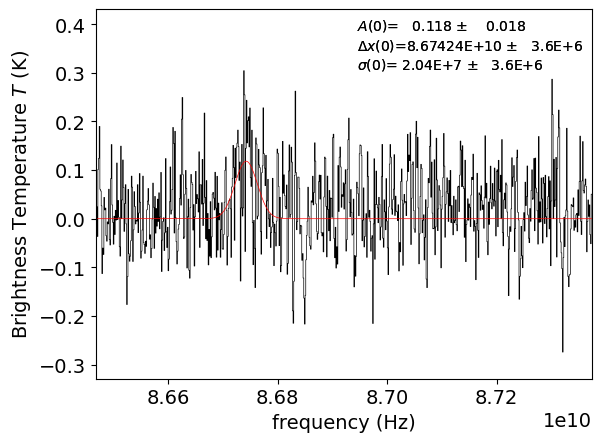

In [264]:
# H13CO+
sch13cop = [c for c in scubes2012 if c.spectral_axis.min() < nurest_h13cop and c.spectral_axis.max() > nurest_h13cop][0]
pxcrd = sch13cop.wcs.celestial.world_to_pixel(coord)
x, y = pxcrd
sp = pyspeckit.Spectrum.from_hdu(sch13cop[:, int(y), int(x)].to(u.K).hdu)
sp.smooth(5)
sp.plotter()
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
(sp.specfit.parinfo['WIDTH0'].value / sp.specfit.parinfo['SHIFT0'].value * constants.c).to(u.km/u.s)

29.757351073240784 29.622566351015166


29.757351073240784 29.622566351015166


29.757351073240784 29.622566351015166


29.757351073240784 29.622566351015166


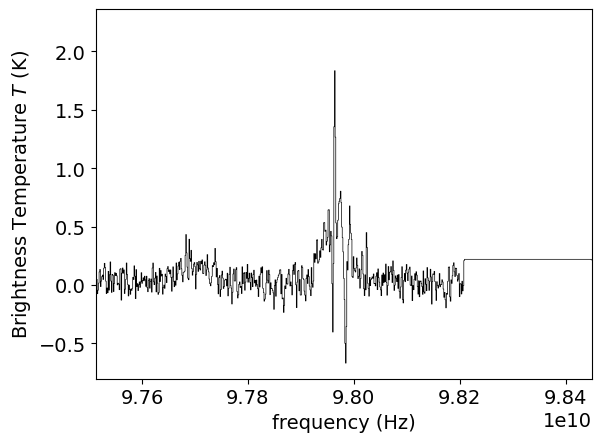

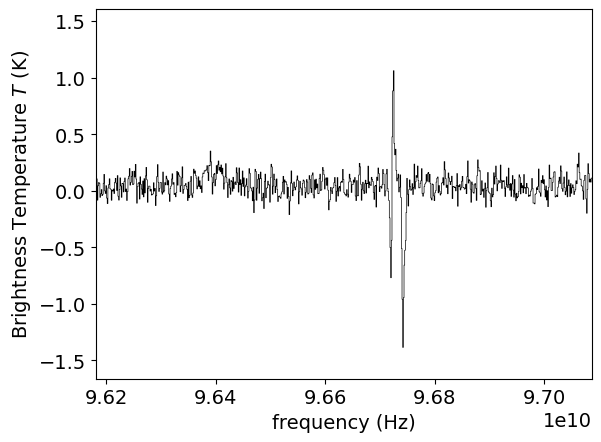

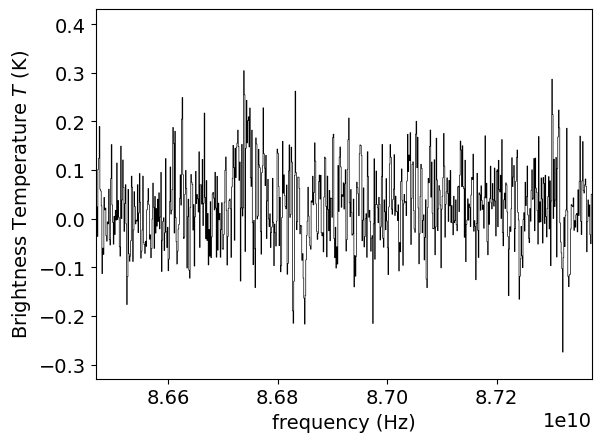

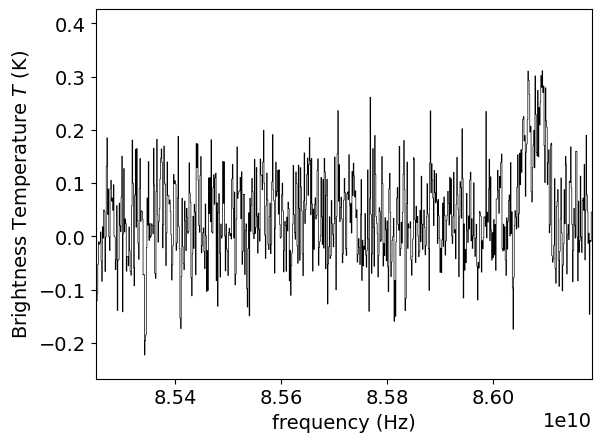

In [265]:
# if this cell fails, check that the right cubes are loaded
for scube in scubes2012:
    pxcrd = scube.wcs.celestial.world_to_pixel(coord)
    x, y = pxcrd
    print(x,y)
    sp = pyspeckit.Spectrum.from_hdu(scube[:, int(y), int(x)].to(u.K).hdu)
    sp.smooth(5)
    sp.plotter(figure=pl.figure())

In [266]:
from astropy import table

In [267]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
            for cu in scubes2012 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
    tabs = [minimize_table(t, columns=('name', 'chemical_name', 'resolved_QNs', 'orderedfreq', 'upper_state_energy_K'), merge=False)
            for t in tabs if len(t) > 0]
b3linetable = table.vstack(tabs)
b3linetable['Freq'] = (b3linetable['orderedfreq']*u.MHz).to(u.GHz)
b3linetable['Species'] = ['34'+x if '34' in nm else x for x,nm in zip(b3linetable['chemical_name'], b3linetable['name'])]
b3linetable['QNs'] = b3linetable['resolved_QNs']
b3linetable = b3linetable[b3linetable['upper_state_energy_K'] < 100]
b3linetable

<Table length=10>
                         name                           chemical_name        resolved_QNs    orderedfreq upper_state_energy_K        Freq             Species                QNs        
                                                                                                                                     GHz                                                
                        str53                               str18               str19          float64         float64             float64             str20                str19       
----------------------------------------------------- ------------------ ------------------- ----------- -------------------- ----------------- -------------------- -------------------
                                      <sup>34</sup>SO    Sulfur Monoxide        3( 2)- 2( 1)   97715.317              9.09292         97.715317    34Sulfur Monoxide        3( 2)- 2( 1)
                   CS <font color="red">v = 0 </font> Carbon Monosulfide                2- 1  97980.9533              7.05355        97.9809533   Carbon Monosulfide                2- 1
                   CS <font color="red">v = 0 </font> Carbon Monosulfide                2- 1  97980.9533              7.05355        97.9809533   Carbon Monosulfide                2- 1
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  7( 3, 5)- 8( 2, 6)  97702.3335             47.83503        97.7023335       Sulfur dioxide  7( 3, 5)- 8( 2, 6)
                                      <sup>34</sup>SO    Sulfur Monoxide        4( 5)- 4( 4)    96781.76             38.05571 96.78175999999999    34Sulfur Monoxide        4( 5)- 4( 4)
       C<sup>34</sup>S <font color="red">v = 0</font> Carbon Monosulfide                2- 1  96412.9495              6.24804 96.41294950000001 34Carbon Monosulfide                2- 1
        SO<sub>2</sub> <font color="red">v = 0</font>     Sulfur dioxide  8( 3, 5)- 9( 2, 8)  86639.0877              55.2022        86.6390877       Sulfur dioxide  8( 3, 5)- 9( 2, 8)
                  SiO <font color="red">v = 0 </font>   Silicon Monoxide                2- 1    86846.96              6.25203 86.84696000000001     Silicon Monoxide                2- 1
                  SiO <font color="red">v = 0 </font>   Silicon Monoxide                2- 1    86846.96              6.25203 86.84696000000001     Silicon Monoxide                2- 1
SO <font color="red"><sup>3</sup>&Sigma; v = 0</font>    Sulfur Monoxide        2( 2)- 1( 1)    86093.95             19.31372 86.09394999999999      Sulfur Monoxide        2( 2)- 1( 1)

In [268]:
all_spectra_b3 = {}
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b3linetable:
        for cube in scubes2012:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            line = f"{rename_map[row['Species']]} {row['QNs'].replace(' ','')}"
            all_spectra_b3[line] = sp
            print(line, end=', ')

$^{34}$SO 3(2)-2(1), CS 2-1, CS 2-1, SO$_2$ 7(3,5)-8(2,6), $^{34}$SO 4(5)-4(4), C$^{34}$S 2-1, SO$_2$ 8(3,5)-9(2,8), SiO 2-1, SiO 2-1, SO 2(2)-1(1), 

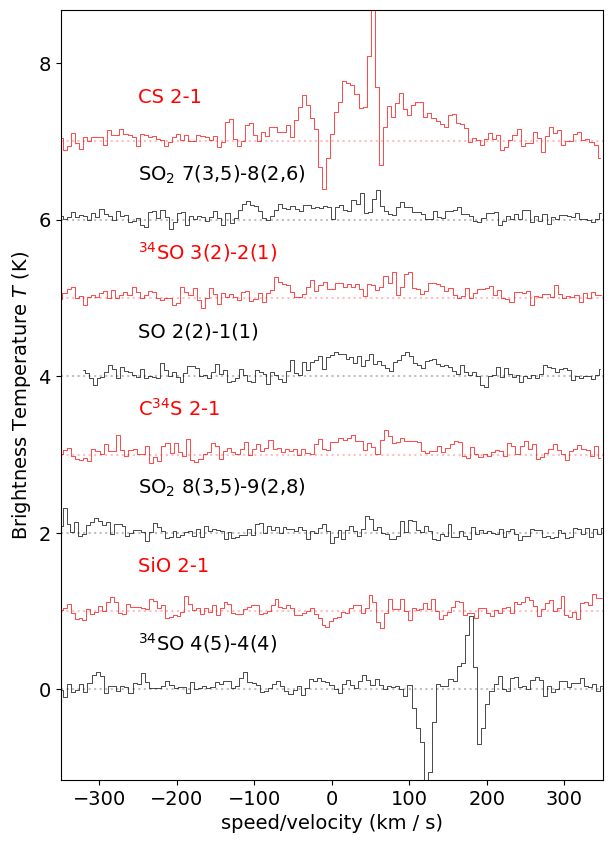

In [269]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b3, key=lambda x: all_spectra_b3[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra_b3[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B3Tsuboi_spectra_overlays.pdf", bbox_inches='tight')

### Tsuboi's w/model

In [270]:
scubes2012

[VaryingResolutionSpectralCube with shape=(3840, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 97512362524.760 Hz:98449559739.802 Hz,
 VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3712  type_s: FREQ      unit_s: Hz     range: 96180400540.670 Hz:97086349711.145 Hz,
 VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3712  type_s: FREQ      unit_s: Hz    

In [271]:
# debug

xx, yy = cube.wcs.celestial.world_to_pixel(coord)
scubes2012[0][:, int(yy), int(xx)]

<VaryingResolutionOneDSpectrum [-0.00739872, 0.00350259, 0.00208707,...,
                                        nan,        nan,        nan] Jy / beam>

In [272]:
cube = scubes2012[0]
xx, yy = cube.wcs.celestial.world_to_pixel(coord)
spw98GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[0][:, int(yy), int(xx)].to(u.K).hdu)
spw96GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[1][:, int(yy), int(xx)].to(u.K).hdu)
spw86GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[2][:, int(yy), int(xx)].to(u.K).hdu)
spw85GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[3][:, int(yy), int(xx)].to(u.K).hdu)
spw98GHz_2012sm = spw98GHz_2012.copy()
spw96GHz_2012sm = spw96GHz_2012.copy()
spw86GHz_2012sm = spw86GHz_2012.copy()
spw85GHz_2012sm = spw85GHz_2012.copy()
spw98GHz_2012sm.smooth(5)
spw96GHz_2012sm.smooth(5)
spw86GHz_2012sm.smooth(5)
spw85GHz_2012sm.smooth(5)

In [273]:
rslt.logcolumn, rslt.tem

(Parameter('logcolumn', value=32.64606395604551),
 Parameter('tem', value=13.413666368478774))

In [274]:
np.log10(np.exp(rslt.logcolumn))

14.178005431971208

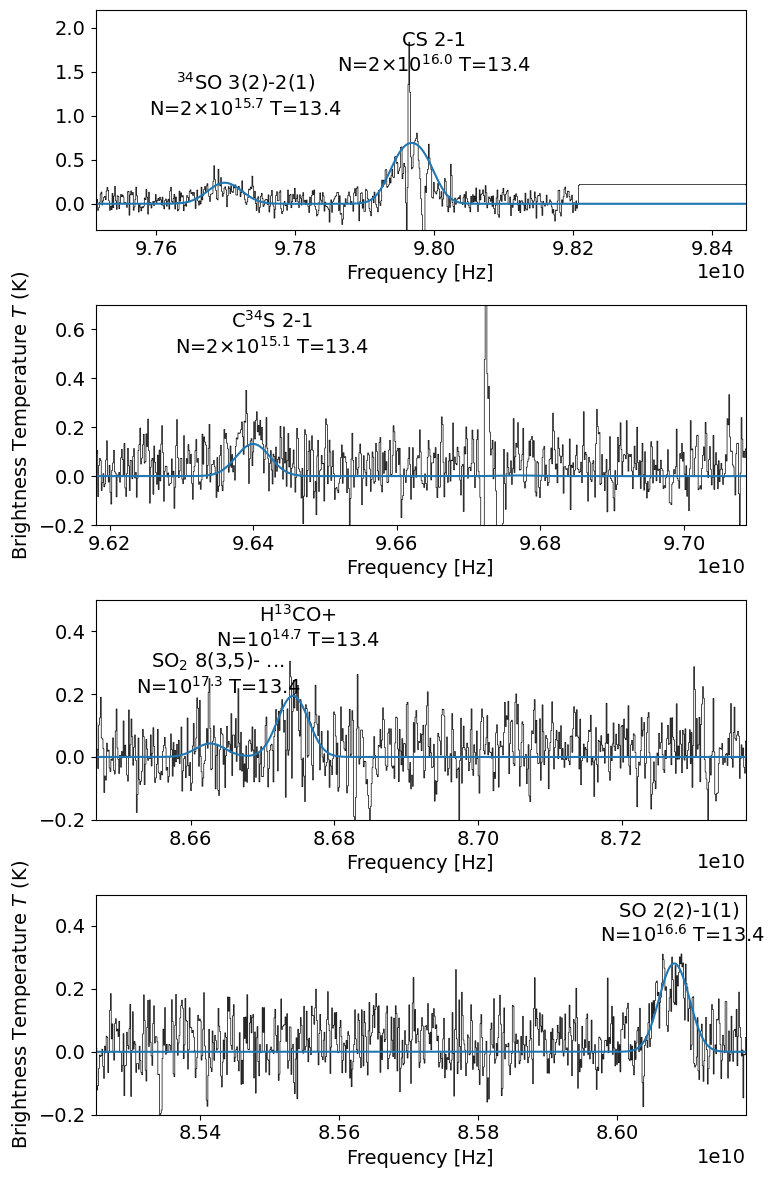

In [275]:
tex = 14.4 * u.K
tex = rslt.tem.value * u.K
ff = 0.1
column_SO = np.exp(rslt.logcolumn)*partfunc_SO(rslt.tem)*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = column_SO/8*u.cm**-2 
column_CS = 1e15*u.cm**-2 / ff
column_C34S = column_CS / 8
column_H13COp = 5e13*u.cm**-2 / ff

spw98GHz_2012.xarr.convert_to_unit(u.Hz)
spw96GHz_2012.xarr.convert_to_unit(u.Hz)
spw86GHz_2012.xarr.convert_to_unit(u.Hz)
spw98GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw96GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw86GHz_2012sm.xarr.convert_to_unit(u.Hz)

sospw98GHz_2012mod = (lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw96GHz_2012mod = (lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw86GHz_2012mod = (lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw85GHz_2012mod = (lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
pl.figure(figsize=(8, 12))
spw98GHz_2012sm.plotter(axis=pl.subplot(4,1,1))
spw98GHz_2012sm.plotter.axis.plot(spw98GHz_2012.xarr.value, sospw98GHz_2012mod)
pl.text(98.0e9, 1.5, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(97.715317e9*(1+40/3e5), 1.0, f"$^{{34}}$SO 3(2)-2(1)\nN=2$\\times10^{{{np.log10(column_34SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylim(-0.3, 2.2)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

#pl.text(99.28e9, 1.9, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw96GHz_2012sm.plotter(axis=pl.subplot(4,1,2))
spw96GHz_2012sm.plotter.axis.plot(spw96GHz_2012.xarr.value, sospw96GHz_2012mod)
spw96GHz_2012sm.plotter.axis.set_ylim(-0.2, 0.7)
pl.text(nurest_c34s21.to(u.Hz).value*(1+40/3e5), 0.5, f"C$^{{34}}$S 2-1\nN=2$\\times10^{{{np.log10(column_C34S.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

spw86GHz_2012sm.plotter(axis=pl.subplot(4,1,3))
spw86GHz_2012sm.plotter.axis.plot(spw86GHz_2012.xarr.value, sospw86GHz_2012mod)
pl.text(86.6390877e9, 0.2, f"SO$_2$ 8(3,5)- ... \nN=10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.75e9, 0.35, f"H$^{{13}}$CO+ \nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.suptitle(y=0.9, t=f"ff={ff}");
pl.ylim(-0.2, 0.5)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

spw85GHz_2012sm.plotter(axis=pl.subplot(4,1,4))
spw85GHz_2012sm.plotter.axis.plot(spw85GHz_2012.xarr.value, sospw85GHz_2012mod)
pl.ylim(-0.2, 0.5)
pl.text(86.09395e9, 0.35, f"SO 2(2)-1(1) \nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

pl.tight_layout()
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectra_with_fitted_model_ff0pt1_2012.pdf', bbox_inches='tight')

## CARMA


CARMA's beam is really big, so it's showing the surroundings.  The line profiles somewhat resemble our compact source, but is clearly coming from a broader area. Hrm.

In [276]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fns_carma = [fn for fn in sorted(glob.glob("/orange/adamginsburg/cmz/carma/*fits")) 
                 if 'mom0' not in fn and 'continuum' not in fn]
    scubescarma = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_carma]
fns_carma

['/orange/adamginsburg/cmz/carma/combined_HCN.fits',
 '/orange/adamginsburg/cmz/carma/combined_HCO%2b.fits',
 '/orange/adamginsburg/cmz/carma/combined_HCO+.fits',
 '/orange/adamginsburg/cmz/carma/combined_N2H%2b.fits',
 '/orange/adamginsburg/cmz/carma/combined_N2H+.fits',
 '/orange/adamginsburg/cmz/carma/combined_SiO.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_CS.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_HCN.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_HCO%2b.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_N2H%2b.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_SiO.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma8_20arcsec.fits']

In [277]:
all_spectra_carma = {}
all_spectra_carma_combined = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fn, cube in zip(fns_carma, scubescarma):
        scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                     )
        if len(scube) <= 2:
            continue
        xx, yy = scube.wcs.celestial.world_to_pixel(coord)
        sp_ = scube[:, int(yy), int(xx)]
        sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
        smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
        sp.smooth(smfac, downsample=True)
        line = fn.split("_")[-1].split(".")[0].replace("%2b", "+")
        if 'combined' in fn:
            all_spectra_carma_combined[line] = sp
        else:
            all_spectra_carma[line] = sp
        print(line, end=', ')

HCN, HCO+, HCO+, N2H+, N2H+, SiO, CS, HCN, HCO+, N2H+, SiO, 

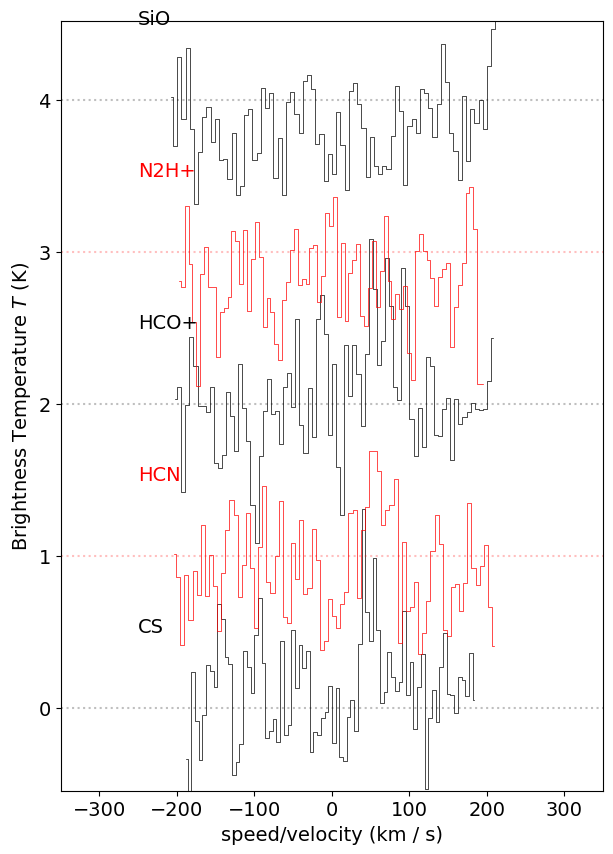

In [278]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma):
    sp = all_spectra_carma[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_spectra_overlays.pdf", bbox_inches='tight')

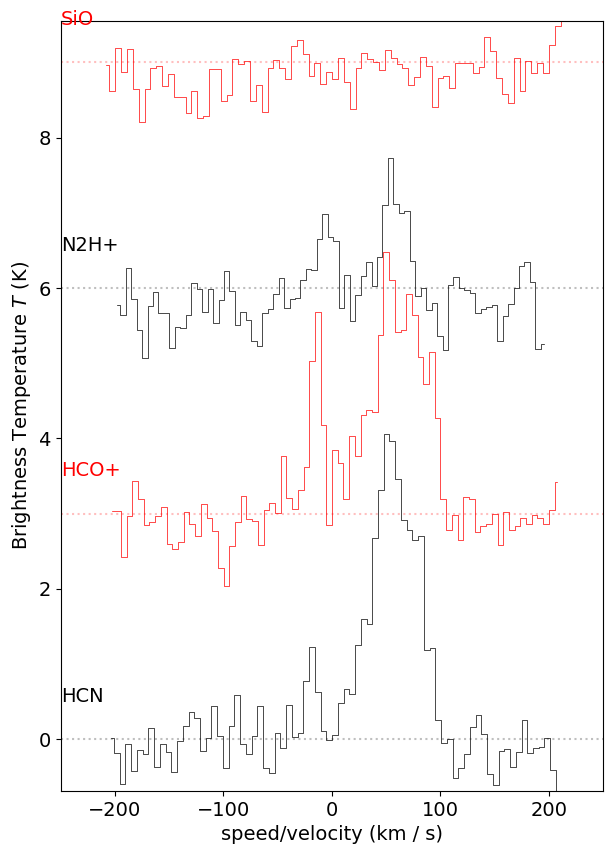

In [279]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma_combined):
    sp = all_spectra_carma_combined[linename]
    offset = 3 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-250, 250);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_combined_spectra_overlays.pdf", bbox_inches='tight')

# Search for other data

In [280]:
from astroquery.alma import Alma
from astroquery.alma.utils import parse_frequency_support
alma = Alma()

In [281]:
result = alma.query(payload=dict(project_code='2012.1.00080.S'), public=None)
frqsupp_201280 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

<Table length=17>
                    obs_id                        s_resolution     proposal_id       frequency     sensitivity_10kms 
                                                     arcsec                             GHz            mJy / beam    
                    str64                           float64           str64           float64           float64      
---------------------------------------------- ------------------ -------------- ----------------- ------------------
    uid://A002/X6444ba/Xe.source.GC50MC.spw.23 0.5987782639694592 2012.1.00080.S 85.71771313212062  6.490800809659072
    uid://A002/X6444ba/Xe.source.GC50MC.spw.19 0.5987782639694592 2012.1.00080.S 96.64909564104646  6.146312079315578
    uid://A002/X6444ba/Xe.source.GC50MC.spw.17 0.5987782639694592 2012.1.00080.S 97.98097165693267  6.124005218012061
    uid://A002/X6444ba/Xe.source.GC50MC.spw.21 0.5987782639694592 2012.1.00080.S  86.9046904502033    6.4322258240111
    uid://A002/X6444ba/X10.source.GC50MC.spw.5   9.54937696964876 2012.1.00080.S 96.68126878928751  47.01043556525447
   uid://A002/X6444ba/X10.source.GC50MC.spw.16   9.54937696964876 2012.1.00080.S 97.98096985505885 47.954956594579826
   uid://A002/X6444ba/X10.source.GC50MC.spw.18   9.54937696964876 2012.1.00080.S 96.64860569801101  48.50494723849789
   uid://A002/X6444ba/X10.source.GC50MC.spw.20   9.54937696964876 2012.1.00080.S 86.90467467272077  50.83011340056173
   uid://A002/X6444ba/X10.source.GC50MC.spw.22   9.54937696964876 2012.1.00080.S  85.7175361322138  52.83164245979768
    uid://A002/X8981ca/X5.source.GC50MC.spw.19  63.40277163177141 2012.1.00080.S 96.54156911746472 16.158283657133353
    uid://A002/X8981ca/X5.source.GC50MC.spw.21  63.40277163177141 2012.1.00080.S 86.79992736369624   18.0241315358307
    uid://A002/X8981ca/X5.source.GC50MC.spw.17  63.40277163177141 2012.1.00080.S  97.9809529996788 16.044090684398615
    uid://A002/X8981ca/X5.source.GC50MC.spw.23  63.40277163177141 2012.1.00080.S  85.7002703129451 18.135622459683336
uid://A002/X8981ca/X3.source.J2253+1608.spw.39  63.39784497492764 2012.1.00080.S 85.71214713670295 22.649393986449816
uid://A002/X8981ca/X3.source.J2253+1608.spw.33  63.39784497492764 2012.1.00080.S 97.98187723143462 21.268906889877318
uid://A002/X8981ca/X3.source.J2253+1608.spw.35  63.39784497492764 2012.1.00080.S 97.02475325315575 21.369175216411943
uid://A002/X8981ca/X3.source.J2253+1608.spw.37  63.39784497492764 2012.1.00080.S 86.73265670946229  22.52010325931357

In [282]:
result_ACES = alma.query_region(coord, radius=2*u.arcsec, payload=dict(project_code='2021.1.00172.L'), public=None)
frqsupp_ACES = parse_frequency_support(result_ACES['frequency_support'][0])
result_ACES['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

<Table length=12>
                    obs_id                        s_resolution     proposal_id       frequency      sensitivity_10kms 
                                                     arcsec                             GHz             mJy / beam    
                    str64                           float64           str64           float64            float64      
---------------------------------------------- ------------------ -------------- ------------------ ------------------
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.35 1.2686830556494908 2021.1.00172.L 100.49772710266514  4.168545162805784
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.25 1.2686830556494908 2021.1.00172.L  86.19998076411858   4.60287357869494
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.31 1.2686830556494908 2021.1.00172.L   87.9251758255454  4.558996663013012
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.27 1.2686830556494908 2021.1.00172.L  86.90003817836697  4.584906044993563
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.33 1.2686830556494908 2021.1.00172.L  98.60210469011402  4.206680625541019
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.29 1.2686830556494908 2021.1.00172.L  89.18859357276138  4.527703284336675
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.18  12.37757749115874 2021.1.00172.L  86.89921089741469  32.75894576927359
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.20  12.37757749115874 2021.1.00172.L  89.18871114209297 32.548198485140915
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.22  12.37757749115874 2021.1.00172.L  87.92520743221294  32.41299168182736
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.26  12.37757749115874 2021.1.00172.L 100.49771651595893   33.7797240863861
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.24  12.37757749115874 2021.1.00172.L   98.6021025311493  31.47269964483055
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.16  12.37757749115874 2021.1.00172.L  86.19995010029461  33.84179823085587

In [283]:
result = alma.query(payload=dict(project_code='2017.1.01185.S'), public=None)
frqsupp_20171185 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency',]# 'frequency_support']

<Table length=16>
                     obs_id                        s_resolution     proposal_id       frequency     
                                                      arcsec                             GHz        
                     str64                           float64           str64           float64      
----------------------------------------------- ------------------ -------------- ------------------
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.20  2.945666865406293 2017.1.01185.S 343.23833623583937
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.16  2.945666865406293 2017.1.01185.S 355.04009270740573
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.22  2.945666865406293 2017.1.01185.S   344.997455911628
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.18  2.945666865406293 2017.1.01185.S 356.98786421840634
     uid://A001/X12a3/X109.source.Sgr_B2.spw.20 3.2306945441385917 2017.1.01185.S 343.23823271447424
     uid://A001/X12a3/X109.source.Sgr_B2.spw.22 3.2306945441385917 2017.1.01185.S 344.99735558062855
     uid://A001/X12a3/X109.source.Sgr_B2.spw.16 3.2306945441385917 2017.1.01185.S  355.0399819516899
     uid://A001/X12a3/X109.source.Sgr_B2.spw.18 3.2306945441385917 2017.1.01185.S 356.98775417652155
     uid://A001/X12a3/X101.source.50_kms.spw.20 3.3022446744307485 2017.1.01185.S 343.23834669405403
     uid://A001/X12a3/X101.source.50_kms.spw.22 3.3022446744307485 2017.1.01185.S  344.9974662600166
     uid://A001/X12a3/X101.source.50_kms.spw.16 3.3022446744307485 2017.1.01185.S 355.04010365765464
     uid://A001/X12a3/X101.source.50_kms.spw.18 3.3022446744307485 2017.1.01185.S  356.9878759775914
     uid://A001/X12a3/X111.source.Sgr_B2.spw.20 3.3177258973355515 2017.1.01185.S  343.2382383750628
     uid://A001/X12a3/X111.source.Sgr_B2.spw.16 3.3177258973355515 2017.1.01185.S  355.0399247359627
     uid://A001/X12a3/X111.source.Sgr_B2.spw.22 3.3177258973355515 2017.1.01185.S  344.9974255277649
     uid://A001/X12a3/X111.source.Sgr_B2.spw.18 3.3177258973355515 2017.1.01185.S  356.9876722974956

In [284]:
result = alma.query_region(coord, radius=5*u.arcsec, public=None)
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'frequency_support']

<Table length=29>
                     obs_id                     ...
                                                ...
                     str64                      ...
----------------------------------------------- ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.35 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.25 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.27 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.33 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.29 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.31 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.20 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.16 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.18 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.22 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.20 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.22 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.26 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.24 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.16 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.18 ...
     uid://A001/X12a3/X101.source.50_kms.spw.22 ...
     uid://A001/X12a3/X101.source.50_kms.spw.16 ...
     uid://A001/X12a3/X101.source.50_kms.spw.18 ...
     uid://A001/X12a3/X101.source.50_kms.spw.20 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.23 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.19 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.21 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.17 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.16 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.18 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.20 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.22 ...
     uid://A002/X6444ba/X10.source.GC50MC.spw.5 ...

# Continuum Analysis

see [Spectral Index](#Spectral_Index)

Betsy's 2017.1.01185.S gives a flux of 86 mJy at 350.1 GHz

We measure 1.5 mJy at 95 GHz

In [285]:
np.log(86/1.5)/np.log(350.1/95)

3.1041570275998556

Spectral index is 3.1: this is a dust source.

## how much mass?

Assuming X_SO ~ 10^-8, N(SO) ~ 10^16, r=10^4 au (all of these are probably high):

In [286]:
((1e4*u.au)**2 * (1e24*u.cm**-2 * 2.8*u.Da)).to(u.M_sun)

<Quantity 52.33015758 solMass>

In [287]:
import dust_emissivity

In [288]:
dust_emissivity.dust.massofsnu(snu=1.5*u.mJy, nu=95*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 51.1631143 solMass>

In [289]:
dust_emissivity.dust.tauofsnu(snu_per_beam=1.5*u.mJy/b3beam.sr, nu=95*u.GHz, temperature=20*u.K)

<Quantity 0.00377163>

In [290]:
b3r['Amp[Jy]']

0.0017704635890274662

### Dust Mass Estimate from B3

In [291]:
u.Quantity(b3r['Amp[Jy]'], u.Jy)

<Quantity 0.00177046 Jy>

In [292]:
dust_emissivity.dust.massofsnu(snu=u.Quantity(b3r['Amp[Jy]'], u.Jy), nu=102*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 46.66368645 solMass>

In [293]:
dust_emissivity.dust.tauofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K)

<Quantity 0.00389573>

### Dust Mass from B7

In [294]:
u.Quantity(b7r['Amp[Jy]'], u.Jy)

<Quantity 0.09821868 Jy>

In [295]:
# what exactly is nu...
dust_emissivity.dust.massofsnu(snu=u.Quantity(b7r['Amp[Jy]'], u.Jy), nu=350*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 35.15256329 solMass>

In [296]:
dust_emissivity.dust.massofsnu(snu=90*u.mJy, nu=350*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 32.21125363 solMass>

In [297]:
dust_emissivity.dust.tauofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K)

<Quantity 0.00572284>

In [298]:
f"{((50*u.M_sun / (4/3.*np.pi*(5000*u.au)**3) / (2.8*u.Da)).to(u.cm**-3)):0.3e}"

'1.220e+07 1 / cm3'

In [299]:
dust_emissivity.dust.kappa(102*u.GHz)

<Quantity 0.00206053 cm2 / g>

In [300]:
dust_emissivity.dust.kappa(350*u.GHz)

<Quantity 0.01782573 cm2 / g>

In [301]:
colb7 = dust_emissivity.dust.colofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K, beta=1.25)
colb7

<Quantity 7.78893177e+22 1 / cm2>

In [302]:
b3beam

Beam: BMAJ=1.9257872153987963 arcsec BMIN=1.5734451566902963 arcsec BPA=-71.8496817278145 deg

In [303]:
colb3 = dust_emissivity.dust.colofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K, beta=1.25)
colb3

<Quantity 2.47622559e+23 1 / cm2>

In [304]:
av_to_ak = 0.1
A_K = colb7/(2e21*u.cm**-2) * av_to_ak
A_K

<Quantity 3.89446588>

In [305]:
av_to_ak = 0.1
A_K = colb3/(2e21*u.cm**-2) * av_to_ak
A_K

<Quantity 12.38112796>

In [306]:
column_SO / colb3

<Quantity 1.56980927e-07>

In [307]:
column_CS / colb3

<Quantity 4.03840427e-08>

In [308]:
column_H13COp / colb3

<Quantity 2.01920213e-09>

In [309]:
column_H13CN / colb3

<Quantity 8.07680854e-11>

In [310]:
column_HC3N / colb3

<Quantity 2.01920213e-10>

#### What's the spectral index as a function of beta, temperature?

$$\frac{S_1}{S_2} = \left(\frac{\nu_1}{\nu_2}\right)^{\alpha}$$
$$\log \left( \frac{S_1}{S_2} \right) = {\alpha}\log \left(\frac{\nu_1}{\nu_2}\right)$$
$$\frac{\log \left( S_1/ S_2 \right)}{\log \left({\nu_1}/ {\nu_2}\right)} = {\alpha}$$

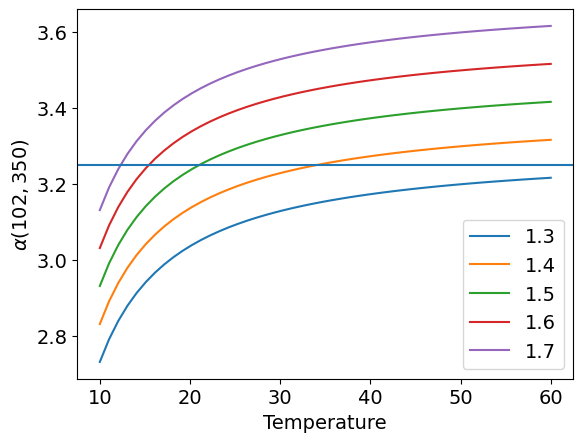

In [311]:
nus = [350, 102]*u.GHz
tems = np.linspace(10, 60)*u.K
column = 3e22*u.cm**-2

for beta in (1.3, 1.4, 1.5, 1.6, 1.7):
    mbbs = u.Quantity([dust_emissivity.blackbody.modified_blackbody(nus,
                                                       temperature=tem,
                                                       beta=beta,
                                                       nu0=271.1*u.GHz, 
                                                       kappa0=0.0114*u.cm**2*u.g**-1*100,
                                                       column=column,
                                                      )
            for tem in tems])
    alphas =  np.log10(mbbs[:,1] / mbbs[:,0]) / np.log10(nus[1]/nus[0])
    alphas
    
    pl.plot(tems.value, alphas.value, '-', label=beta);
pl.axhline(3.25)
pl.legend(loc='best')
pl.xlabel("Temperature")
pl.ylabel("$\\alpha(102, 350)$");

### Age limit from size?  Weak

In [312]:
size = 1e4*u.au
vhwhm = 75*u.km/u.s
(size/vhwhm).to(u.yr)

<Quantity 632.06272847 yr>

# Multiwavelength cutout

moved to MUBLO_MultiwavelengthCutouts.ipynb

# Global CMZ chemistry
to check whether a galaxy might look like this

In [313]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw25_mosaic.fits')
cube.allow_huge_operations = True
cs_tp = cube.with_spectral_unit(u.km/u.s, rest_value=97.98095*u.GHz, velocity_convention='radio').spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_tp = cube.with_spectral_unit(u.km/u.s, rest_value=99.29987*u.GHz, velocity_convention='radio').spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
m0cs = cs_tp.to(u.K).moment0(axis=0)
m0so = so_tp.to(u.K).moment0(axis=0)

In [314]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw27_mosaic.fits')
cube.allow_huge_operations = True
h3cn_tp = cube.with_spectral_unit(u.km/u.s, rest_value=100.0763*u.GHz, velocity_convention='radio').spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
m0hc3n = h3cn_tp.to(u.K).moment0(axis=0)

In [315]:
cube = SpectralCube.read('/orange/adamginsburg/ACES/mosaics/cubes/ACES_TP_spw25_mosaic.fits')
cube.allow_huge_operations = True
so21_tp = cube.with_spectral_unit(u.km/u.s, rest_value=nurest_so21, velocity_convention='radio').spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
m0so21 = h3cn_tp.to(u.K).moment0(axis=0)

In [316]:
np.nanmean(m0so)

<Projection 9.87240244 K km / s>

In [317]:
np.nanmean(m0so21)

<Projection 6.35026863 K km / s>

In [318]:
np.nanmean(m0cs)

<Projection 53.37283593 K km / s>

In [319]:
np.nanmean(m0hc3n)

<Projection 6.35026863 K km / s>

In [320]:
np.nanmean(m0hc3n) /  np.nanmean(m0cs)

<Projection 0.11897941>

In [321]:
 np.nanmean(m0so) /  np.nanmean(m0so21)

<Projection 1.55464328>

#### Intensity Limits from Models

In [322]:
lte_molecule.generate_model(spw35.xarr,
            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N).max()

0.04424744368719075

In [323]:
(
lte_molecule.generate_model(spw35.xarr,
            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N).max() / 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS).max())

0.006405865576392011

# Merger hypothesis: energy limits

In [324]:
(constants.G*u.M_sun**2/u.R_sun).to(u.erg)

<Quantity 3.7931109e+48 erg>

In [325]:
print("TEST")

TEST
